In [46]:
import h5py
import numpy as np
import seaborn as sns
import operator
import visualisation
import pandas as pd
import matplotlib.pyplot as plt
from dtw import dtw

from sporco import plot, util
from sporco.admm import cbpdn
from sporco.dictlrn import cbpdndl
from numpy.fft import rfft, rfftfreq
from itertools import tee

import scipy.signal as sg
import pandas as pd
from scipy.signal import butter, lfilter, freqz

In [47]:
PATH_TO_TESTING_DATA = "data/X_train_denoised_array.h5"
PATH_TO_TRAINING_TARGET = "data/y_train_tX9Br0C.csv"
h5_file = h5py.File(PATH_TO_TESTING_DATA,'r')
mask = np.array(pd.read_csv(PATH_TO_TRAINING_TARGET))

In [49]:
X_train = np.array(h5_file.get('data'))
print(X_train.shape)
apnea_events = np.load('data/location_apnea_events.npy')
print(np.shape(apnea_events))
nonapnea_events = np.load('data/location_nonapnea_events.npy')
print(np.shape(nonapnea_events))

(1486, 3)
(5360, 3)


In [50]:
X_EEG1 = X_train[6]
X_EEG2 = X_train[7]
WINDOW_SIZE = 10 * FREQUENCY ## 10 SECONDS
FREQUENCY = 100
fs = 100

In [52]:
## bandpass filter on EEG - USEFUL FUNCTIONS

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def response_filters_energy(signal):
    """
    Compute energy of responses of each filter of interest for a given signal
    """
    
    y_alpha = butter_bandpass_filter(signal, 8, 12, fs, order=3)
    y_beta = butter_bandpass_filter(signal, 16, 40, fs, order=3)
    y_sigma = butter_bandpass_filter(signal, 12, 16, fs, order=3)
    y_delta = butter_bandpass_filter(signal, 0.25, 4, fs, order=3)
    y_theta = butter_bandpass_filter(signal, 4, 8, fs, order=3)

    return np.array([np.linalg.norm(y_delta, ord=2), 
                     np.linalg.norm(y_theta, ord=2), 
                     np.linalg.norm(y_alpha, ord=2), 
                     np.linalg.norm(y_sigma, ord=2), 
                     np.linalg.norm(y_beta, ord=2)])**2


In [79]:
def features_boxplots(X_train_0, dimension, outliers_boolean=False, window_size = WINDOW_SIZE):
    """
    
    Input : the signal corresponding to a dimension of X to be considered (dimension between 0 and 7)
    Parameter window_size : size of each subsignal from which statistical features (mean, variance, ...)
                            are computed
    Output : A dataframe with relevant caracteristics that can be compared between Apnea and NonApnea sleep

    """

    X_apnea = list()
    for a,b,c in apnea_events: 
        a,b,c = int(a), int(b), int(c)
        if a < len(X_train_0):
            X_apnea.append(X_train_0[a, b*FREQUENCY:(b+c)*FREQUENCY+1])

    X_nonapnea = list()
    for a,b,c in nonapnea_events: 
        a,b,c = int(a), int(b), int(c)
        if a < len(X_train_0):
            X_nonapnea.append(X_train_0[a, b*FREQUENCY:(b+c)*FREQUENCY+1])


    apneas = list()
    for i in range(len(X_apnea)):
        for j in range(len(X_apnea[i])):
            if j%window_size ==0:
                apneas.append(X_apnea[i][j:j+window_size])
    apneas=np.array(apneas)

    nonapneas = list()
    for i in range(len(X_nonapnea)):
        for j in range(len(X_nonapnea[i])):
            if j%window_size ==0:
                nonapneas.append(X_nonapnea[i][j:j+window_size])
    nonapneas=np.array(nonapneas)

    total_size = np.shape(apneas)[0] + np.shape(nonapneas)[0]
    category = list()
    patient_id = list()
    delta, theta, alpha, sigma, beta = np.zeros(total_size), np.zeros(total_size), np.zeros(total_size),np.zeros(total_size), np.zeros(total_size)
    i=0
    for signal in apneas:
        signal = np.array(signal)
        features = response_filters_energy(signal)
        delta[i] = features[0]
        theta[i] = features[1]
        alpha[i] = features[2]
        sigma[i] = features[3]
        beta[i] = features[4]
        category.append('Apnea')

        i+=1

    for signal in nonapneas:
        signal = np.array(signal)
        features = response_filters_energy(signal)
        delta[i] = features[0]
        theta[i] = features[1]
        alpha[i] = features[2]
        sigma[i] = features[3]
        beta[i] = features[4]
        category.append('Non Apnea')
        i+=1

    category = np.array(category)

    ## construction of a dataframe
    d = {'delta': delta, 'theta':theta,'alpha' : alpha, 'sigma': sigma, 'beta': beta, 'category':category}
    df_train = pd.DataFrame(data=d)
    
    d_bis = {"delta-theta":delta/theta, "delta-alpha": delta/alpha, "delta-sigma": delta/sigma,
                    "delta-beta":delta/beta, "theta-alpha":theta/alpha, 'category':category}
    df_train_bis = pd.DataFrame(data=d_bis)

    ## plots
    fig, axes = plt.subplots(1,len(df_train_bis.columns[:-1]), figsize=(25, 10))
    fig.suptitle('Comparison of filter responses of dimension '+ str(dimension) +
                 ' of the multivariate time series among Apnea and Non Apnea')
    c=0
    for col in df_train_bis.columns[:-1]:

        sns.boxplot(ax = axes[c], y=col, x='category', data=df_train_bis, showfliers=outliers_boolean)
        c+=1
    
    plt.show()

## Analysis of EEG1

<ipython-input-60-3c6096d5983d>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-60-3c6096d5983d>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


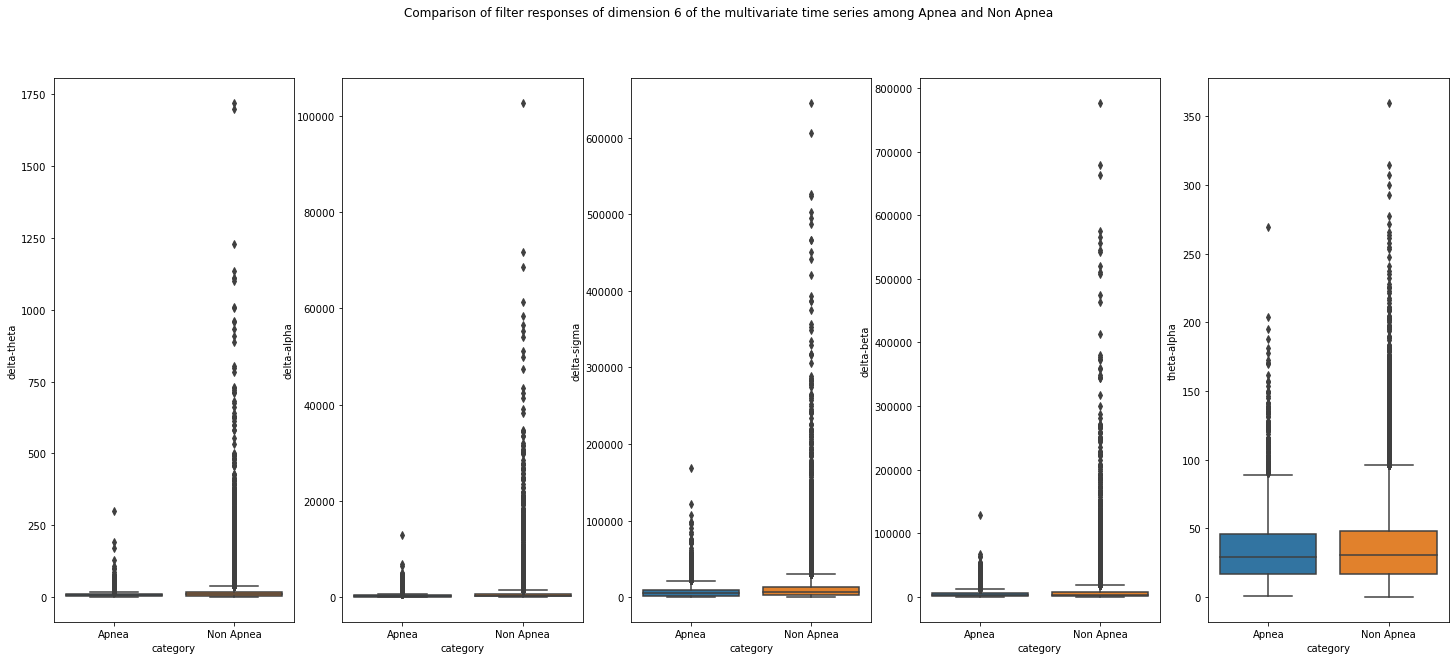

In [61]:
## all patients in one shot

features_boxplots(X_EEG1, 6, outliers_boolean=True)

<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


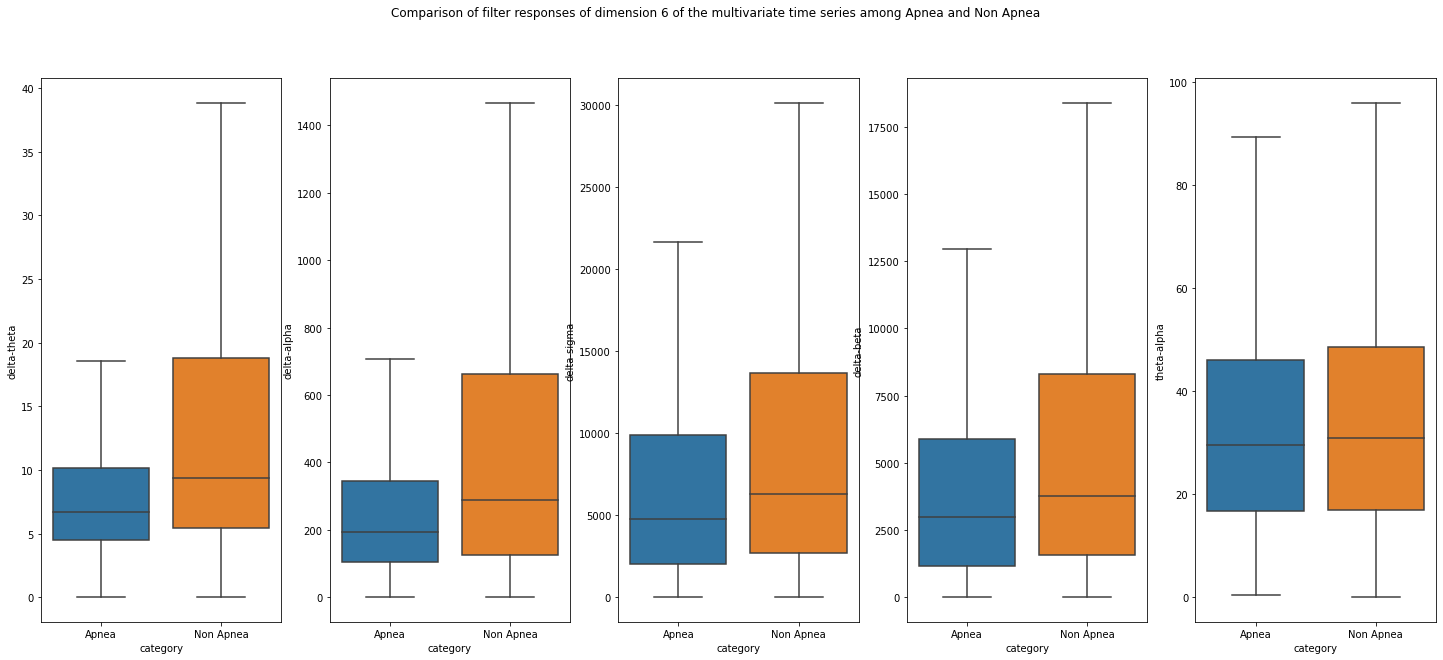

In [71]:
## same but without outliers in the plots

features_boxplots(X_EEG1, 6, , outliers_boolean=False)

- - - - - - - - - - - - - - - PATIENT 0- - - - - - - - - - - - - - - 


<ipython-input-64-15bc0551fb79>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-64-15bc0551fb79>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


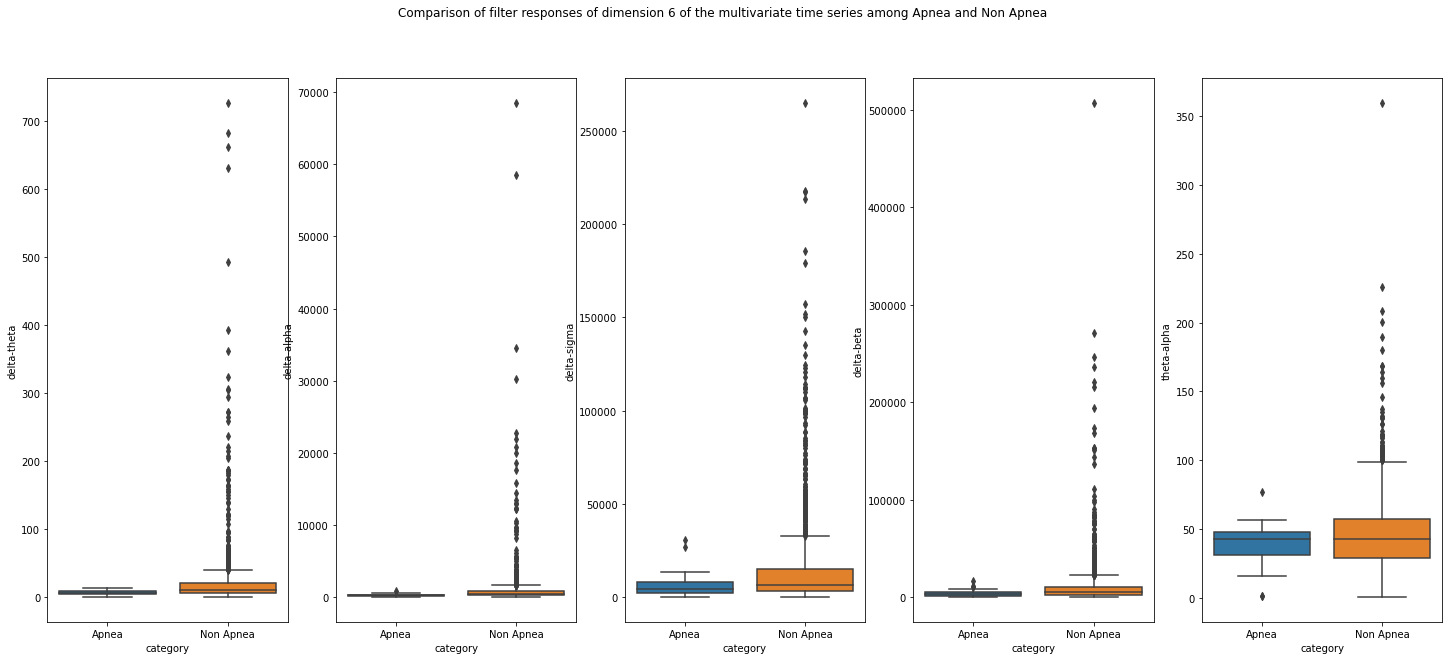

- - - - - - - - - - - - - - - PATIENT 1- - - - - - - - - - - - - - - 


<ipython-input-64-15bc0551fb79>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-64-15bc0551fb79>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


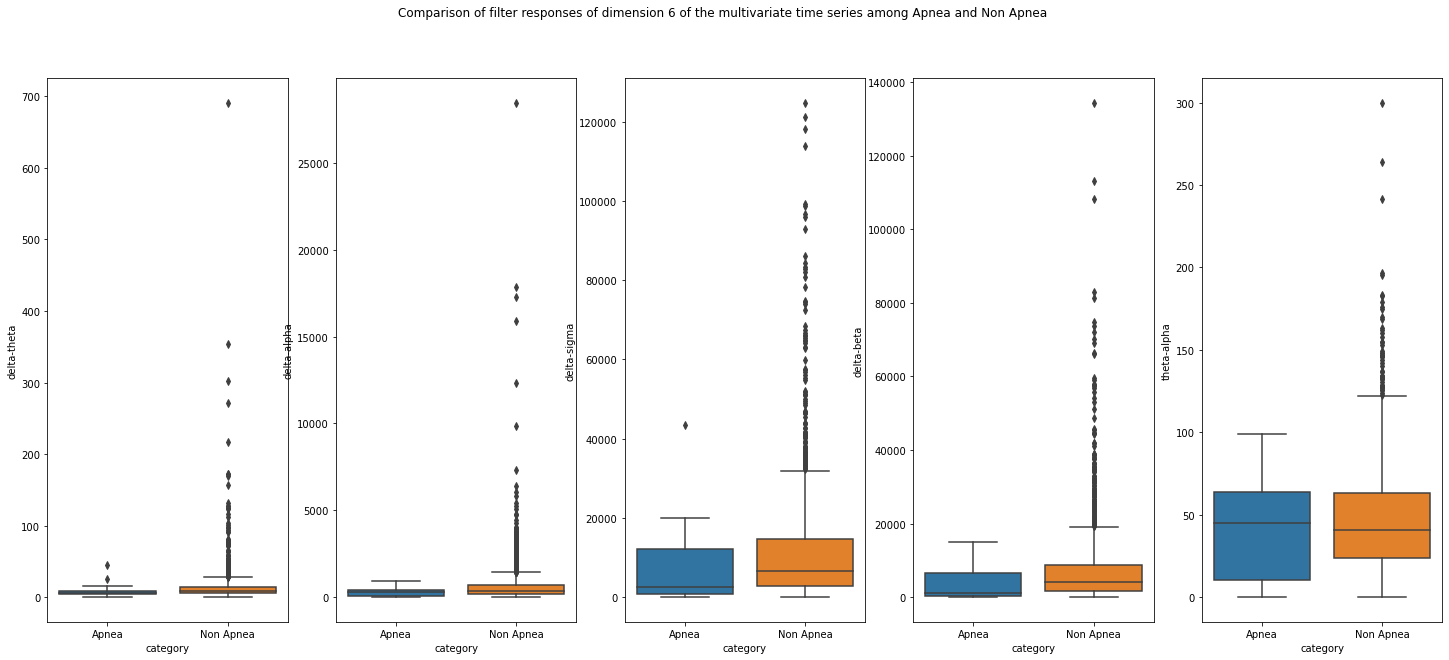

- - - - - - - - - - - - - - - PATIENT 2- - - - - - - - - - - - - - - 


<ipython-input-64-15bc0551fb79>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-64-15bc0551fb79>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


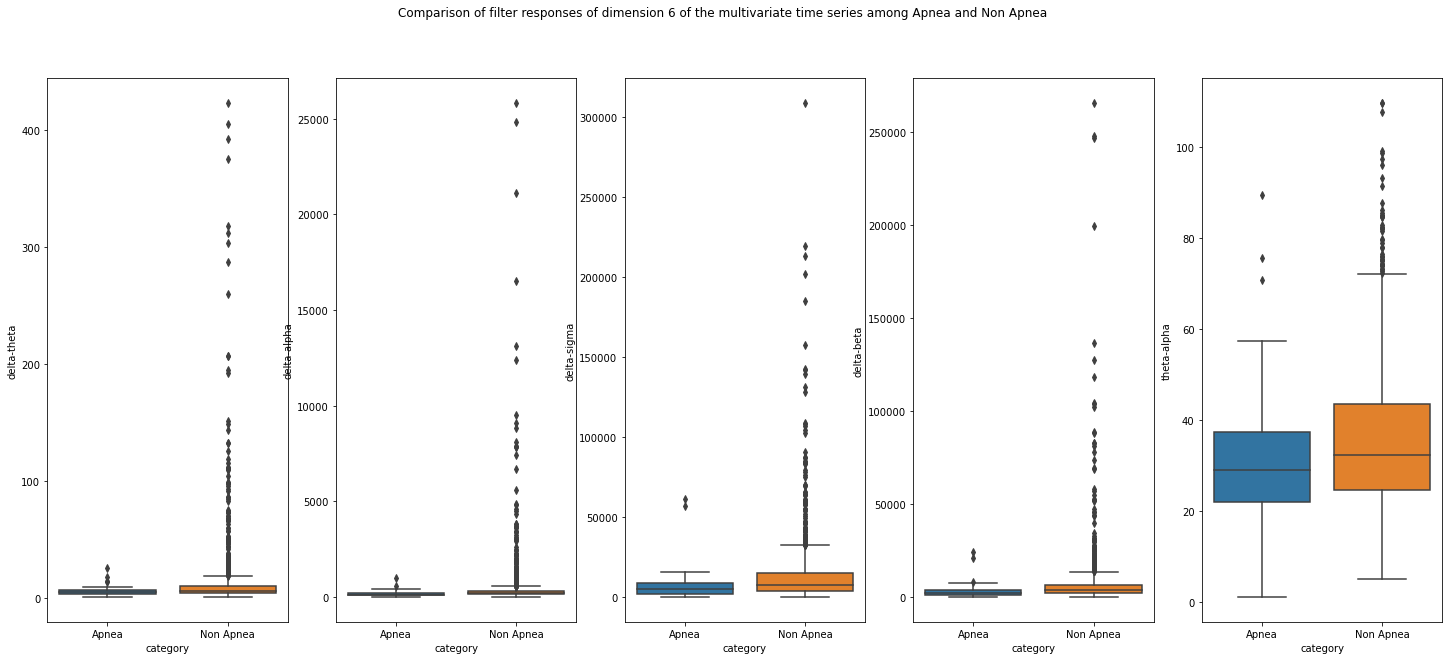

- - - - - - - - - - - - - - - PATIENT 3- - - - - - - - - - - - - - - 


<ipython-input-64-15bc0551fb79>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-64-15bc0551fb79>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


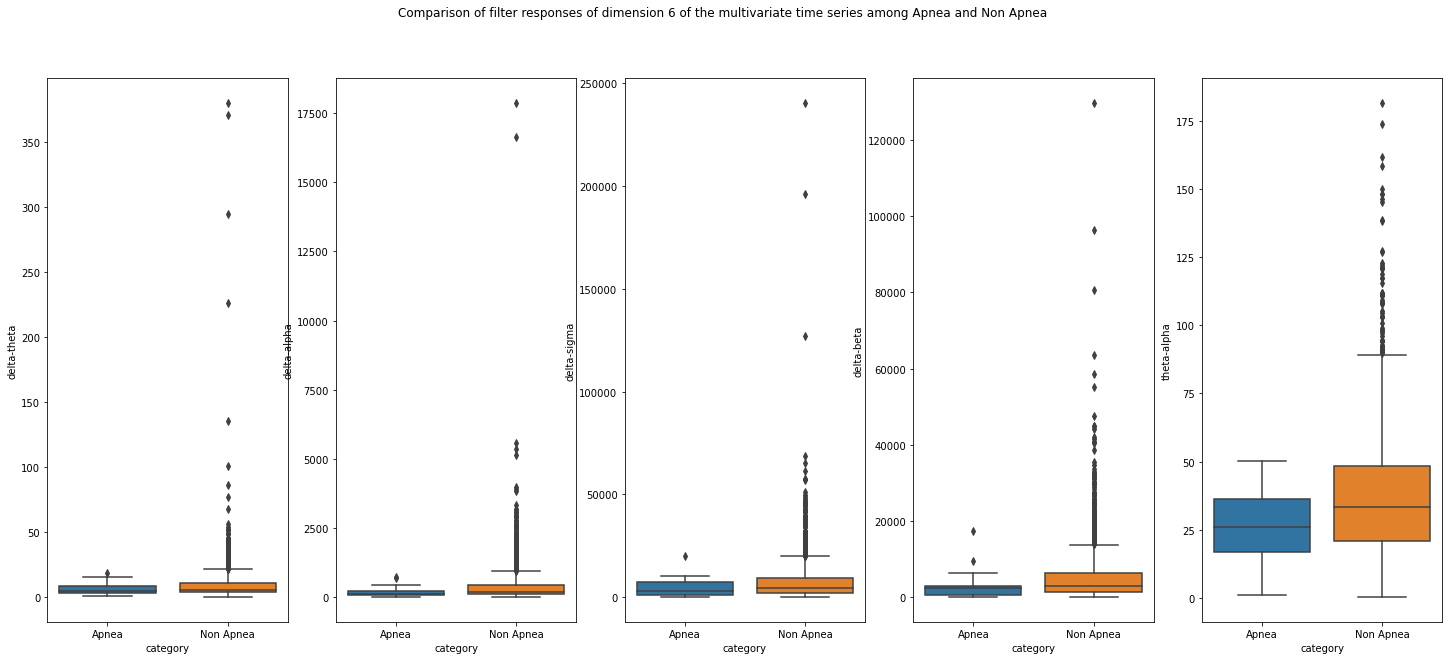

- - - - - - - - - - - - - - - PATIENT 4- - - - - - - - - - - - - - - 


<ipython-input-64-15bc0551fb79>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-64-15bc0551fb79>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


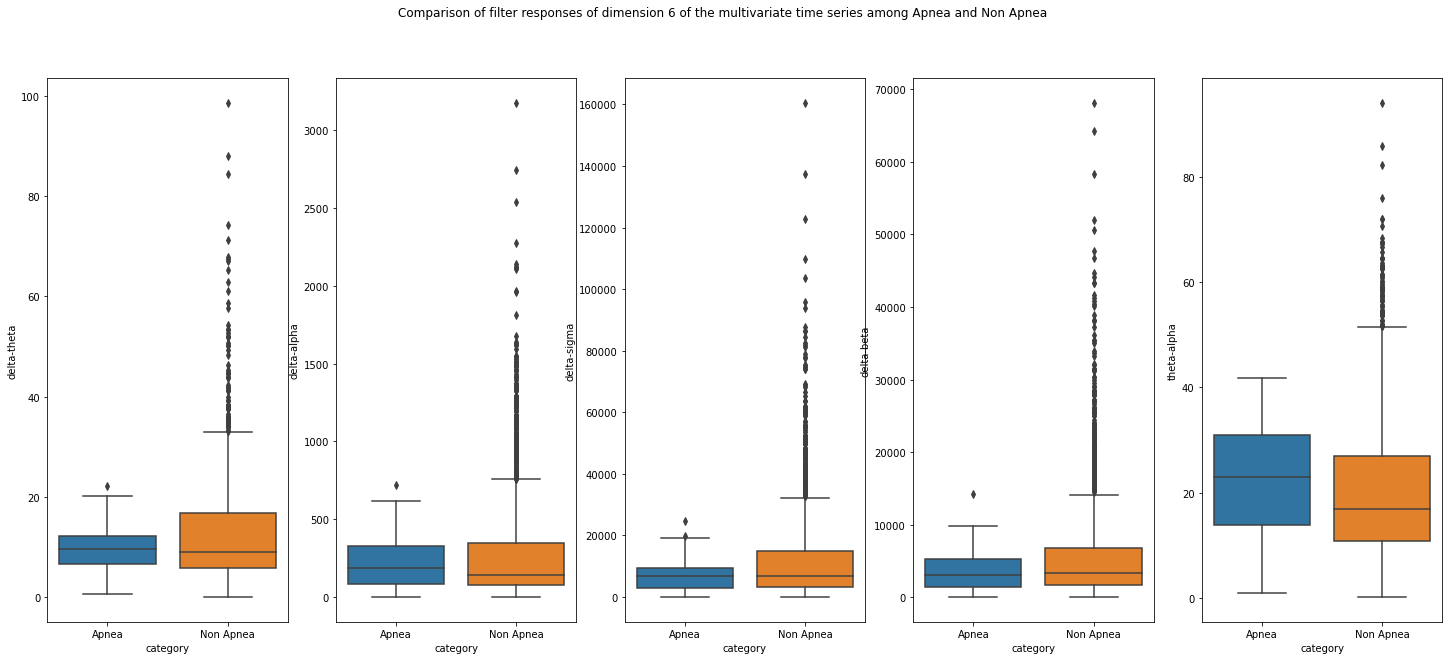

- - - - - - - - - - - - - - - PATIENT 5- - - - - - - - - - - - - - - 


<ipython-input-64-15bc0551fb79>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-64-15bc0551fb79>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


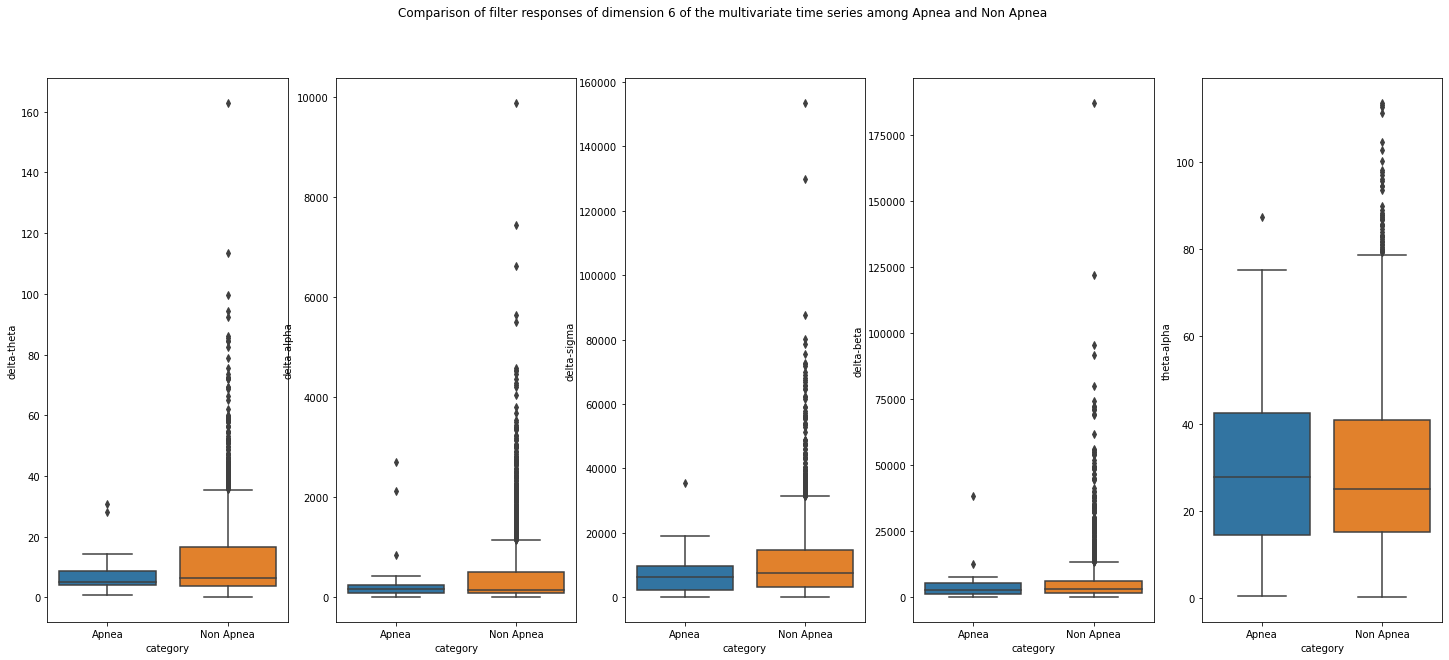

- - - - - - - - - - - - - - - PATIENT 6- - - - - - - - - - - - - - - 


<ipython-input-64-15bc0551fb79>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-64-15bc0551fb79>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


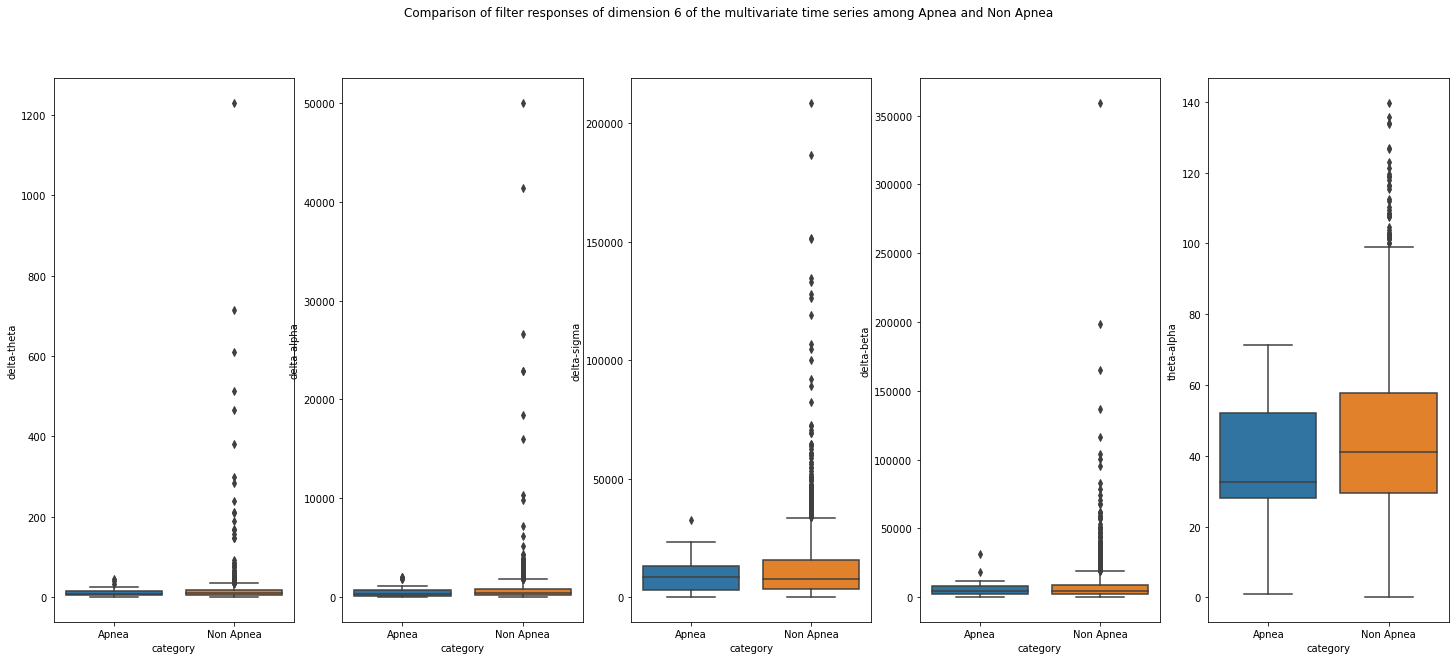

- - - - - - - - - - - - - - - PATIENT 7- - - - - - - - - - - - - - - 


<ipython-input-64-15bc0551fb79>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-64-15bc0551fb79>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


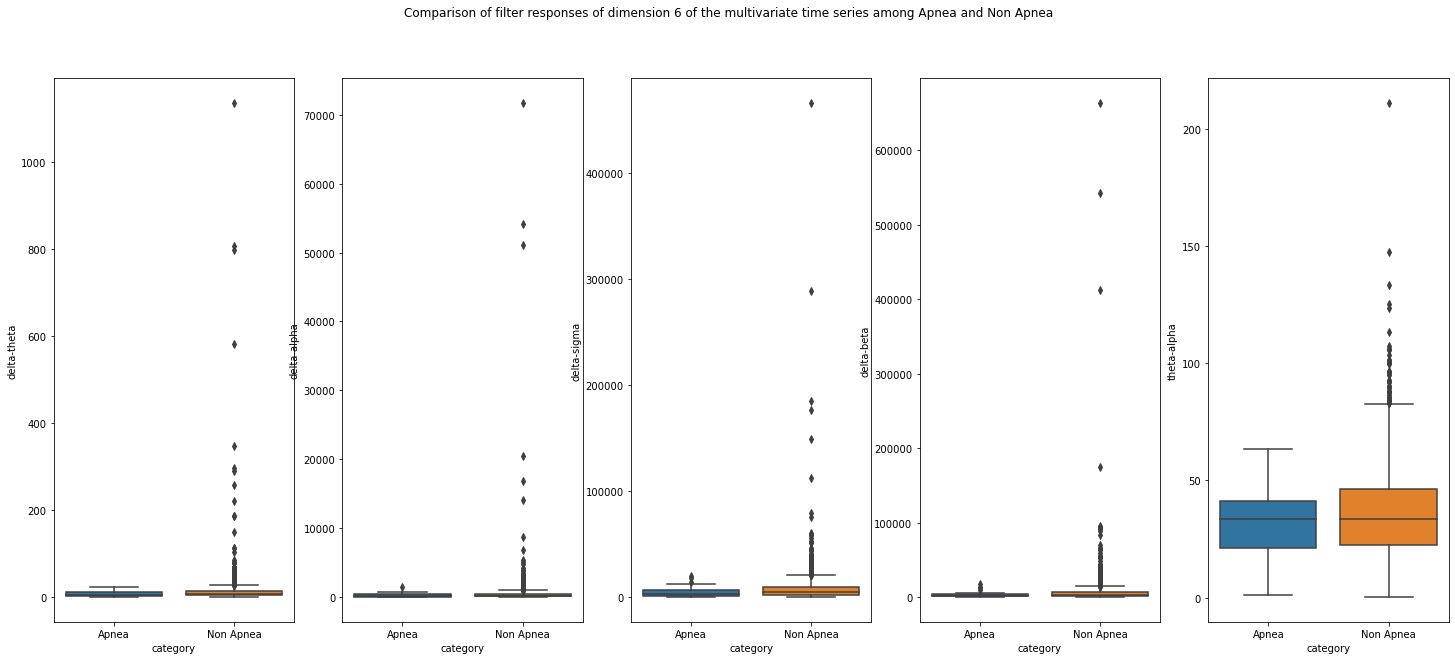

- - - - - - - - - - - - - - - PATIENT 8- - - - - - - - - - - - - - - 


<ipython-input-64-15bc0551fb79>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-64-15bc0551fb79>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


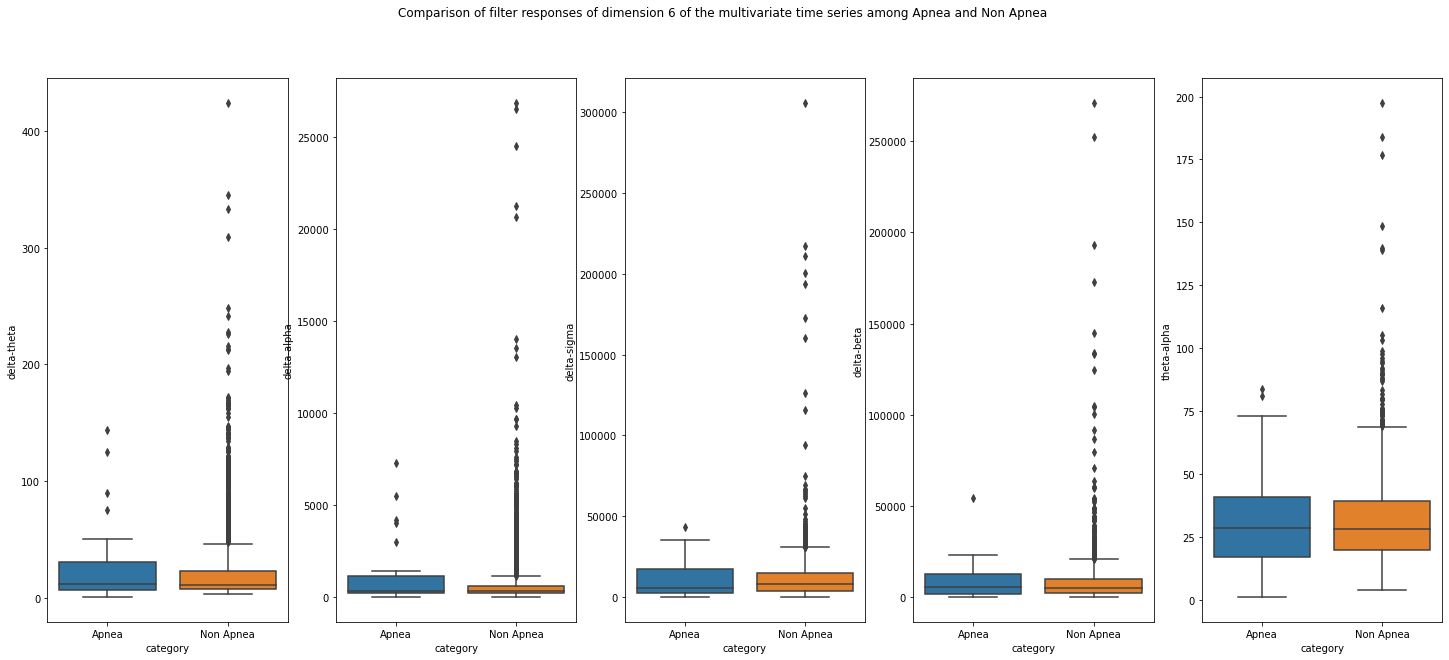

- - - - - - - - - - - - - - - PATIENT 9- - - - - - - - - - - - - - - 


<ipython-input-64-15bc0551fb79>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-64-15bc0551fb79>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


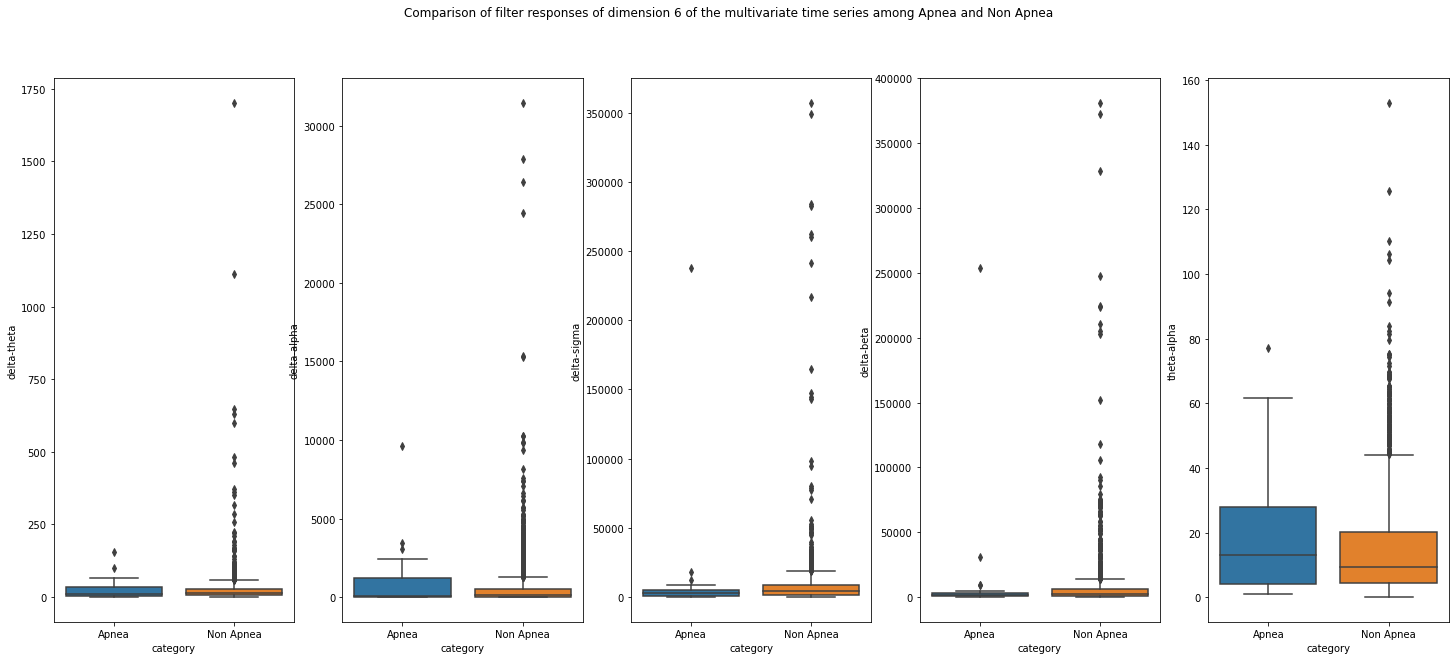

- - - - - - - - - - - - - - - PATIENT 10- - - - - - - - - - - - - - - 


<ipython-input-64-15bc0551fb79>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-64-15bc0551fb79>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


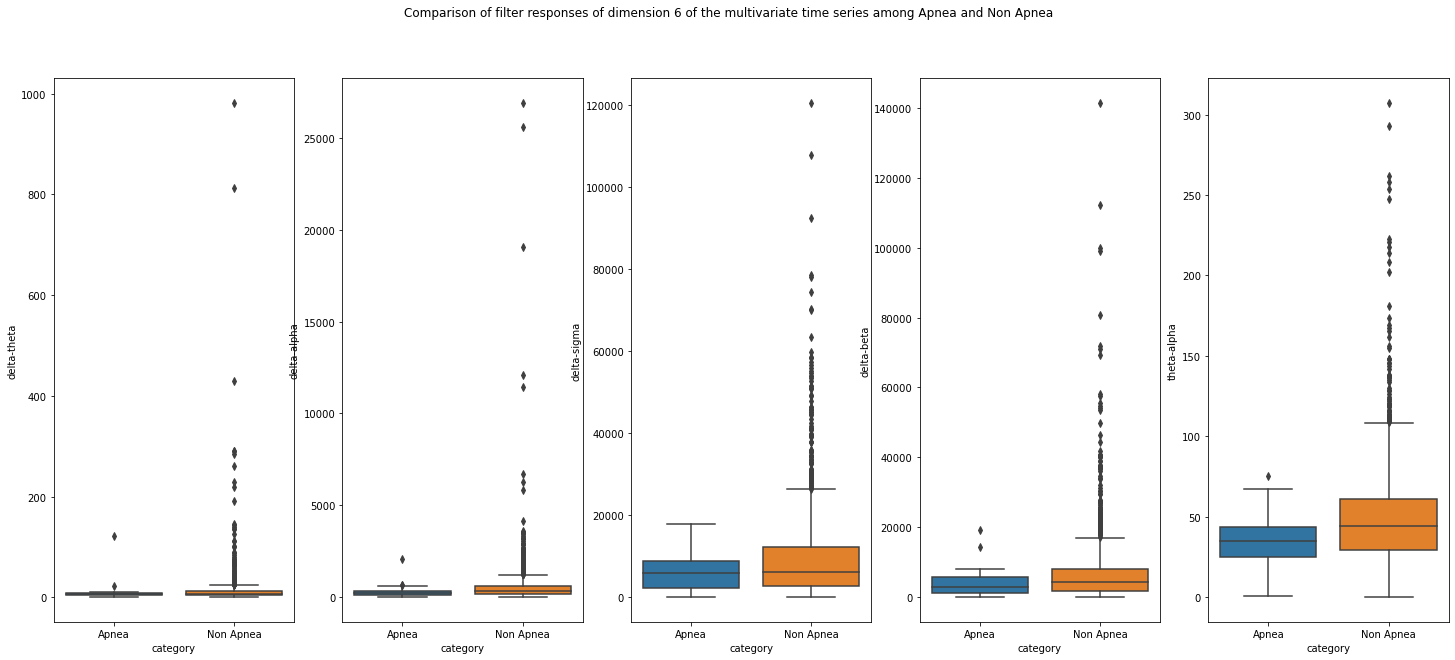

- - - - - - - - - - - - - - - PATIENT 11- - - - - - - - - - - - - - - 


<ipython-input-64-15bc0551fb79>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-64-15bc0551fb79>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


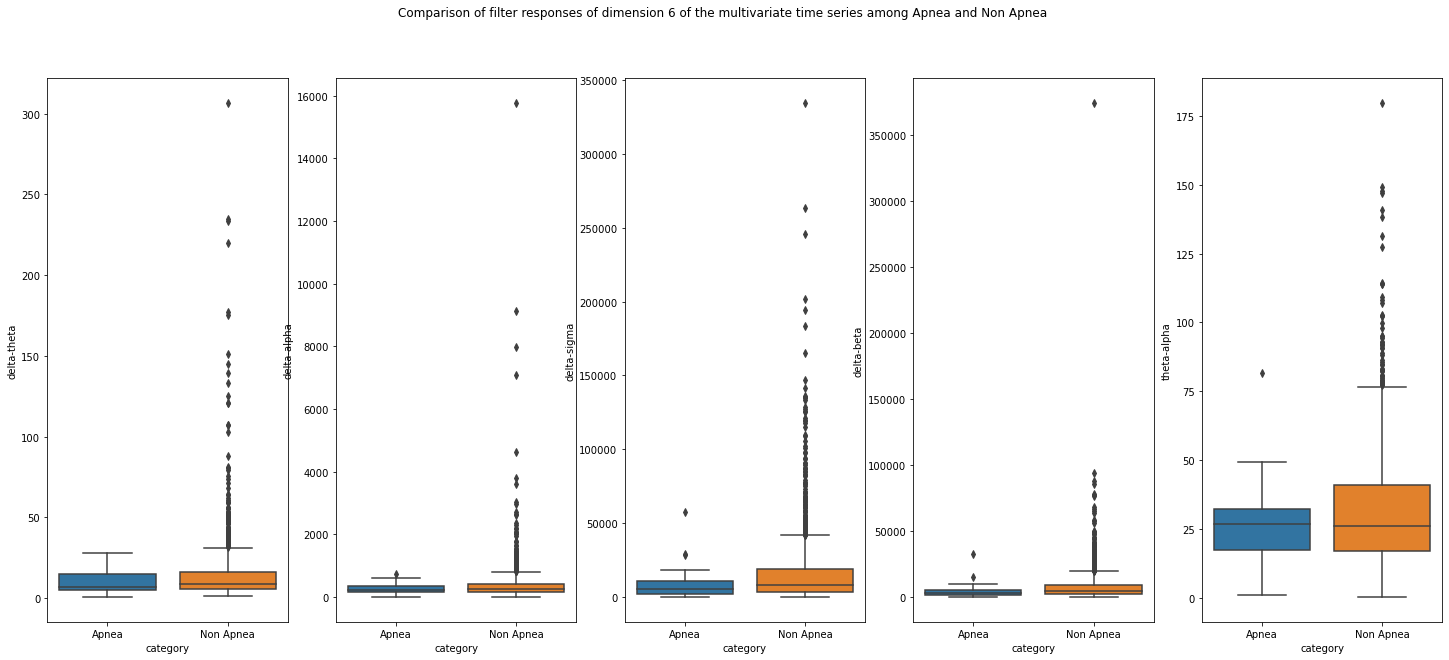

- - - - - - - - - - - - - - - PATIENT 12- - - - - - - - - - - - - - - 


<ipython-input-64-15bc0551fb79>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-64-15bc0551fb79>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


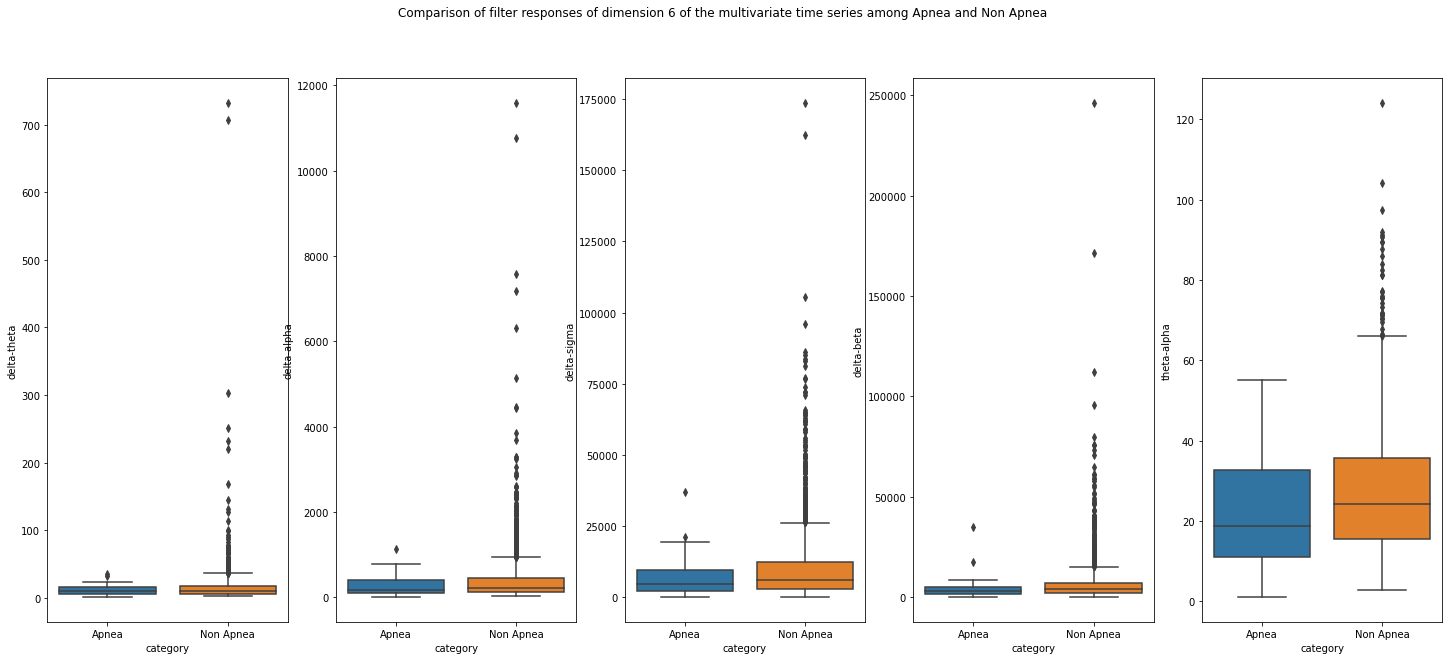

- - - - - - - - - - - - - - - PATIENT 13- - - - - - - - - - - - - - - 


<ipython-input-64-15bc0551fb79>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-64-15bc0551fb79>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


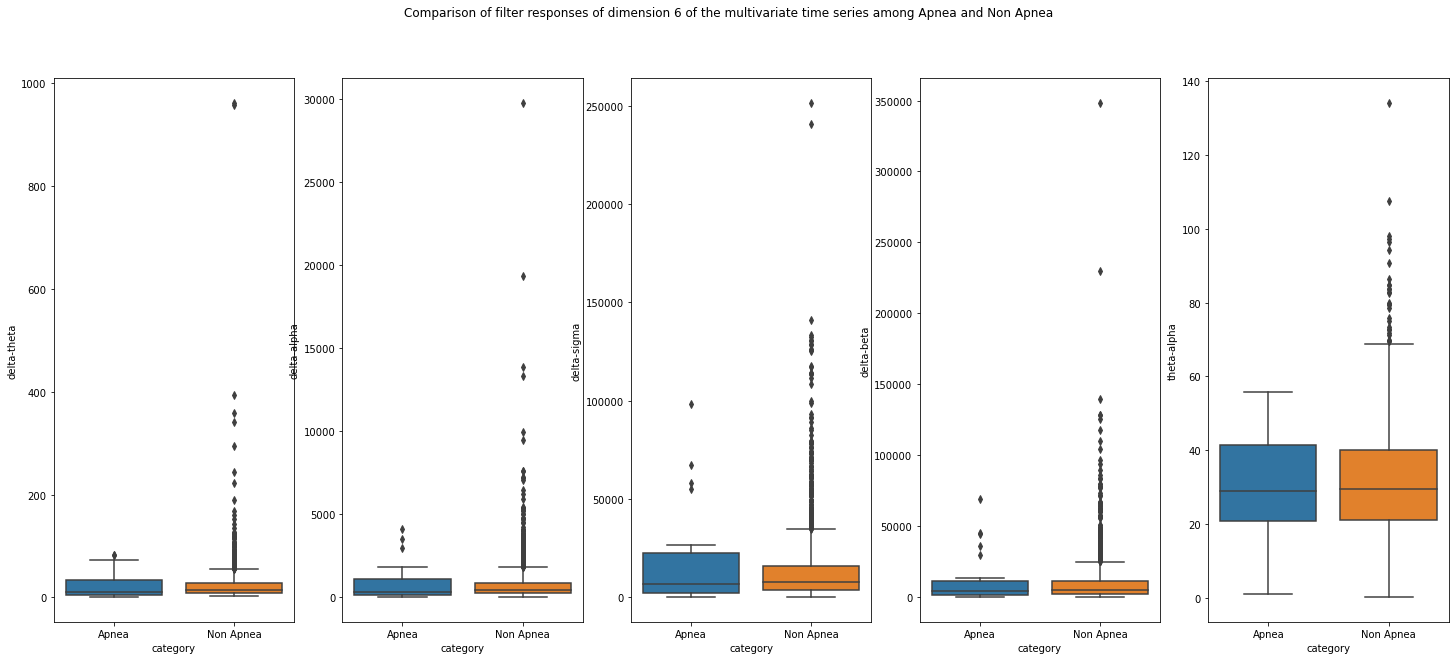

- - - - - - - - - - - - - - - PATIENT 14- - - - - - - - - - - - - - - 


<ipython-input-64-15bc0551fb79>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-64-15bc0551fb79>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


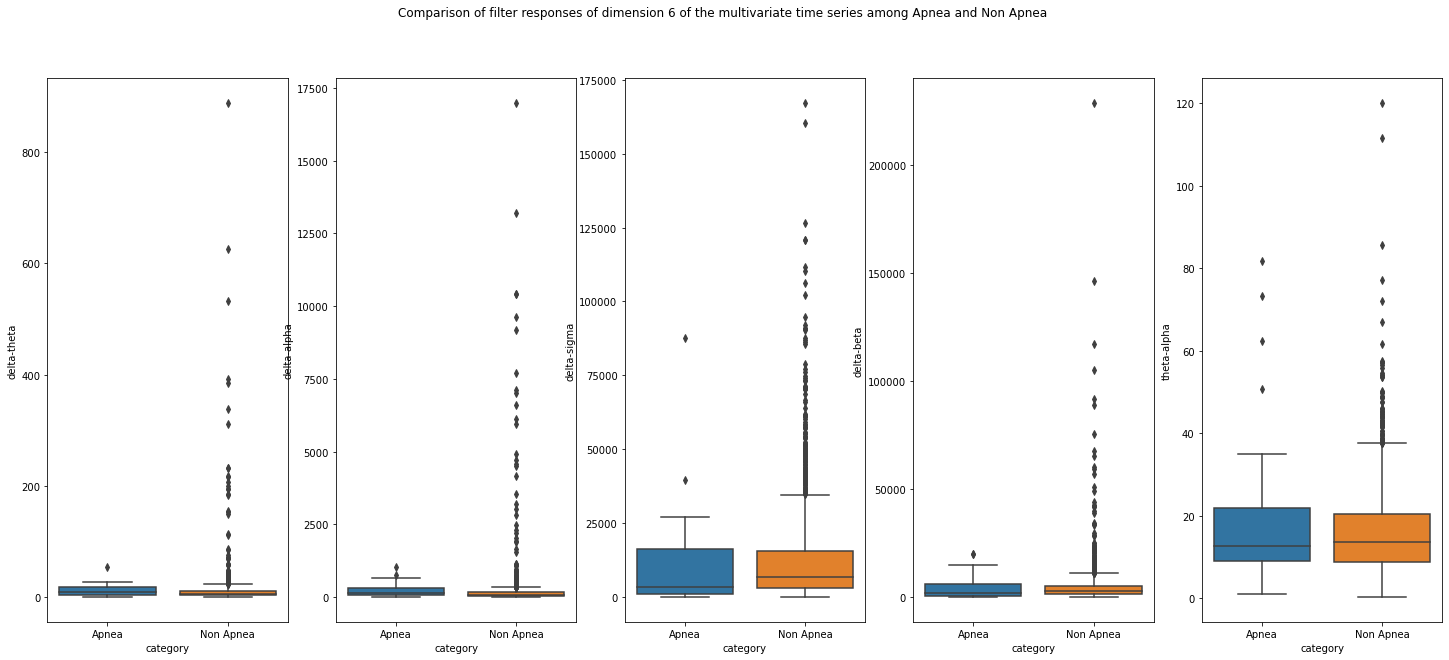

- - - - - - - - - - - - - - - PATIENT 15- - - - - - - - - - - - - - - 


<ipython-input-64-15bc0551fb79>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-64-15bc0551fb79>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


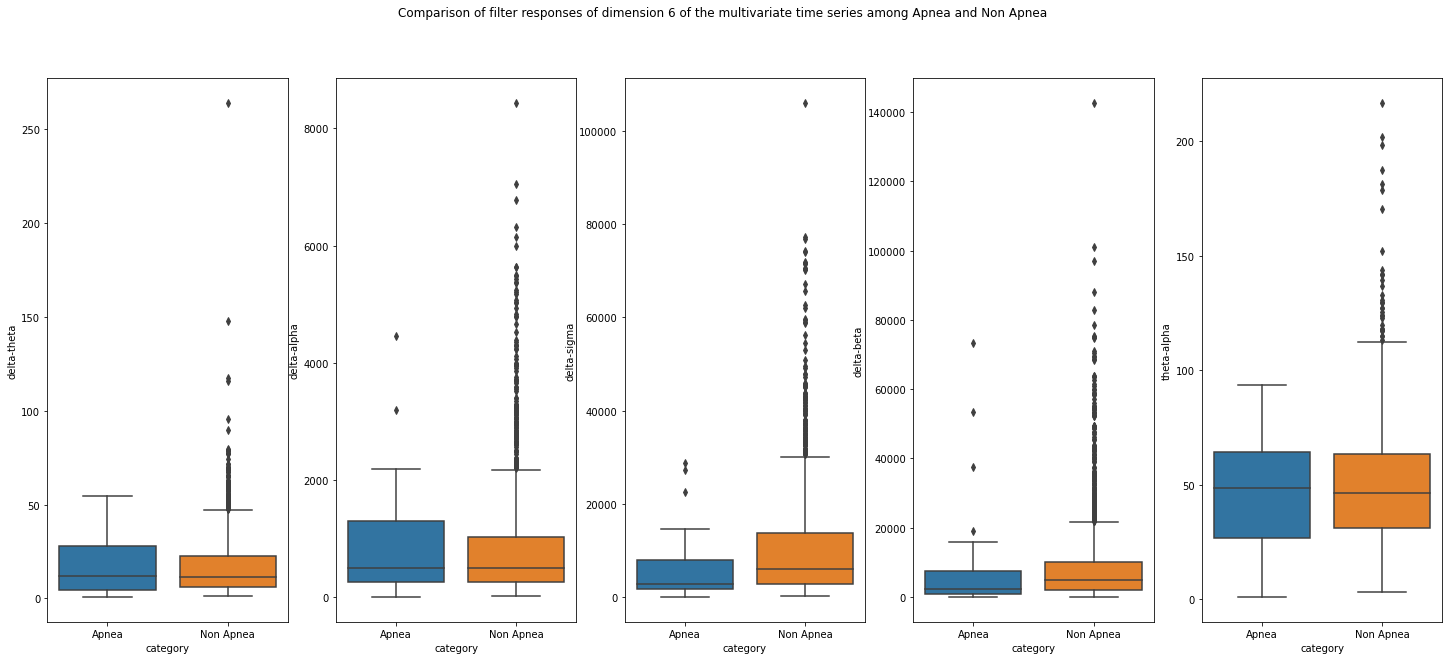

- - - - - - - - - - - - - - - PATIENT 16- - - - - - - - - - - - - - - 


<ipython-input-64-15bc0551fb79>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-64-15bc0551fb79>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


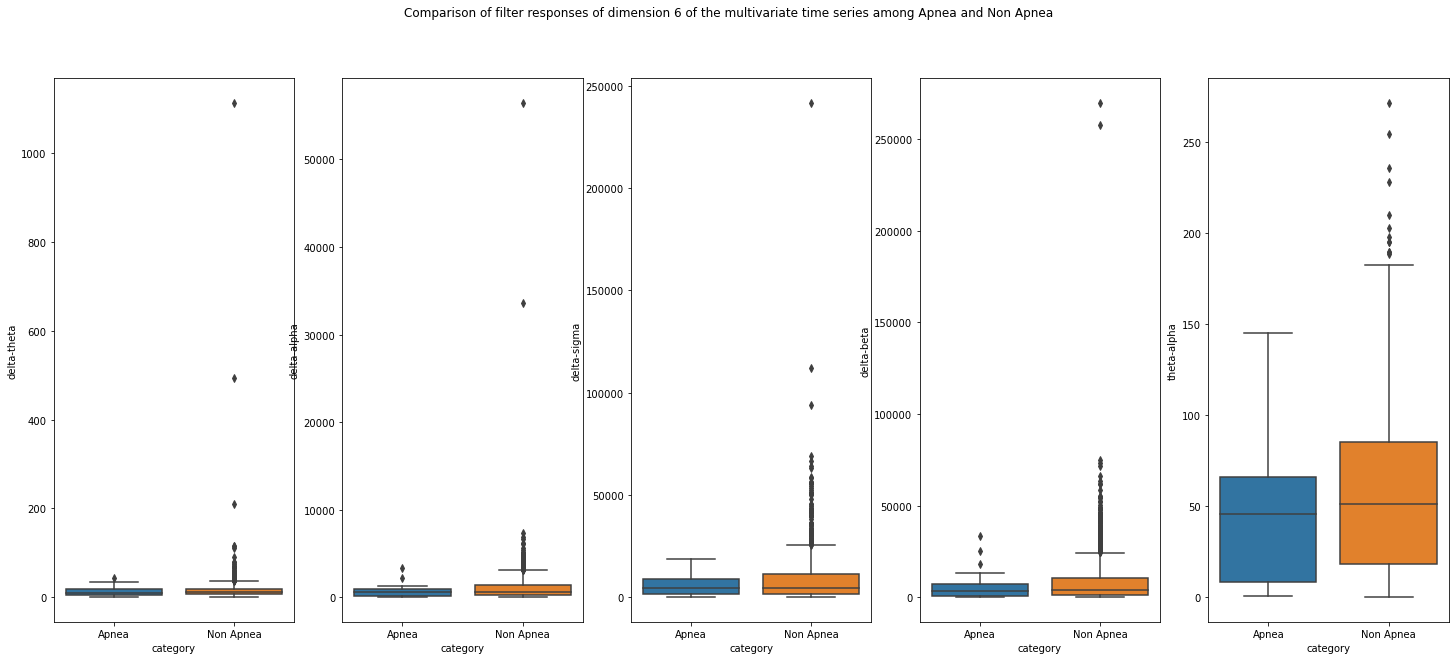

- - - - - - - - - - - - - - - PATIENT 17- - - - - - - - - - - - - - - 


<ipython-input-64-15bc0551fb79>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-64-15bc0551fb79>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


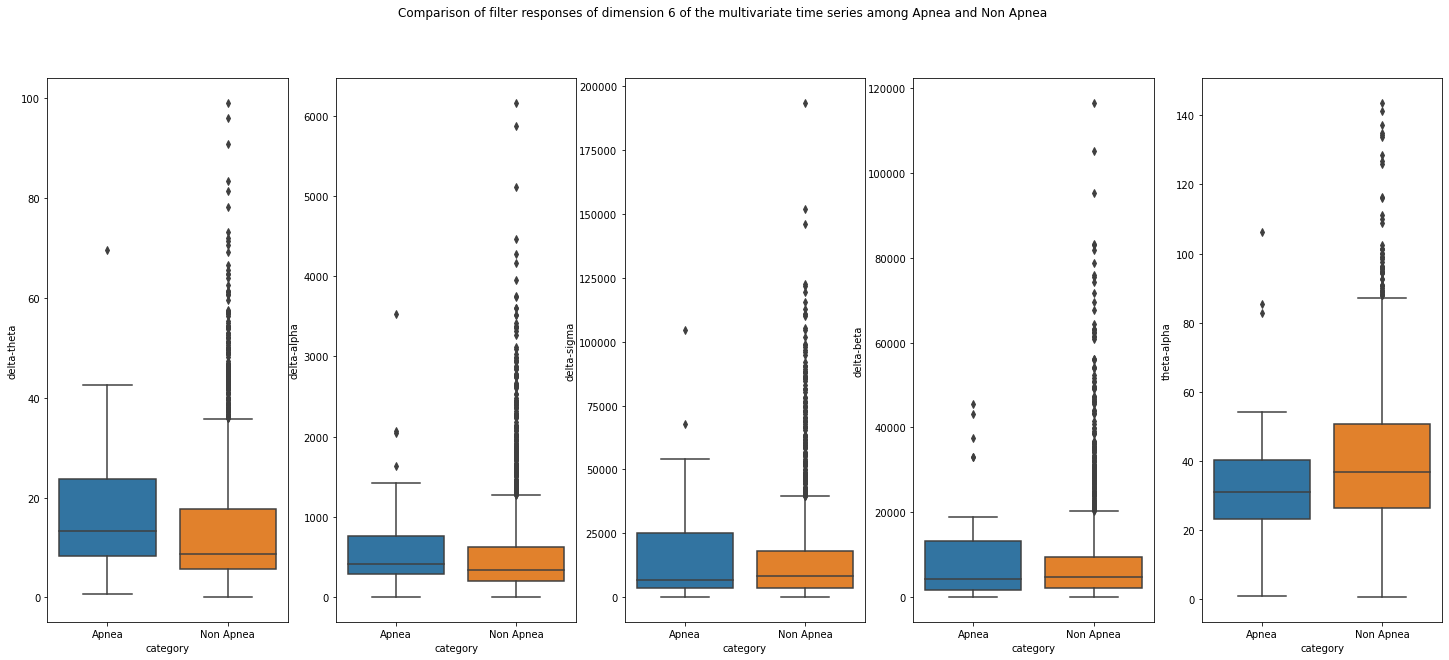

- - - - - - - - - - - - - - - PATIENT 18- - - - - - - - - - - - - - - 


<ipython-input-64-15bc0551fb79>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-64-15bc0551fb79>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


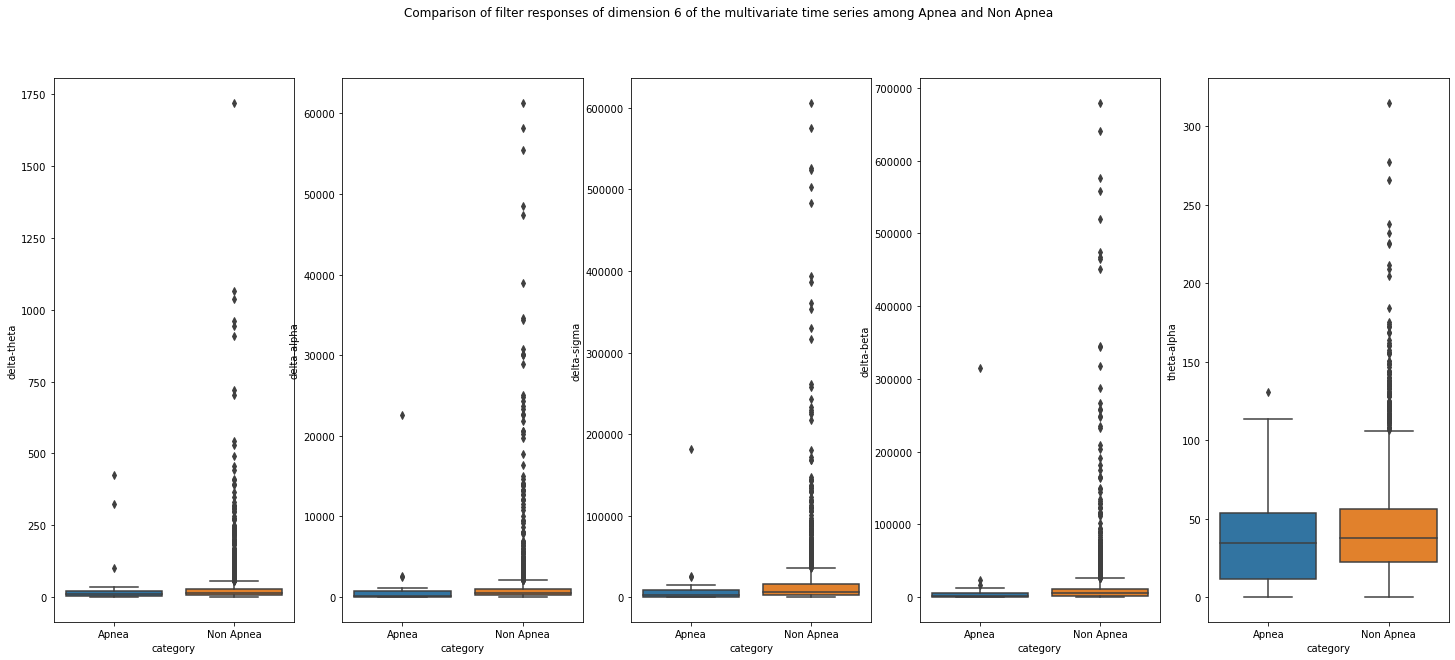

- - - - - - - - - - - - - - - PATIENT 19- - - - - - - - - - - - - - - 


<ipython-input-64-15bc0551fb79>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-64-15bc0551fb79>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


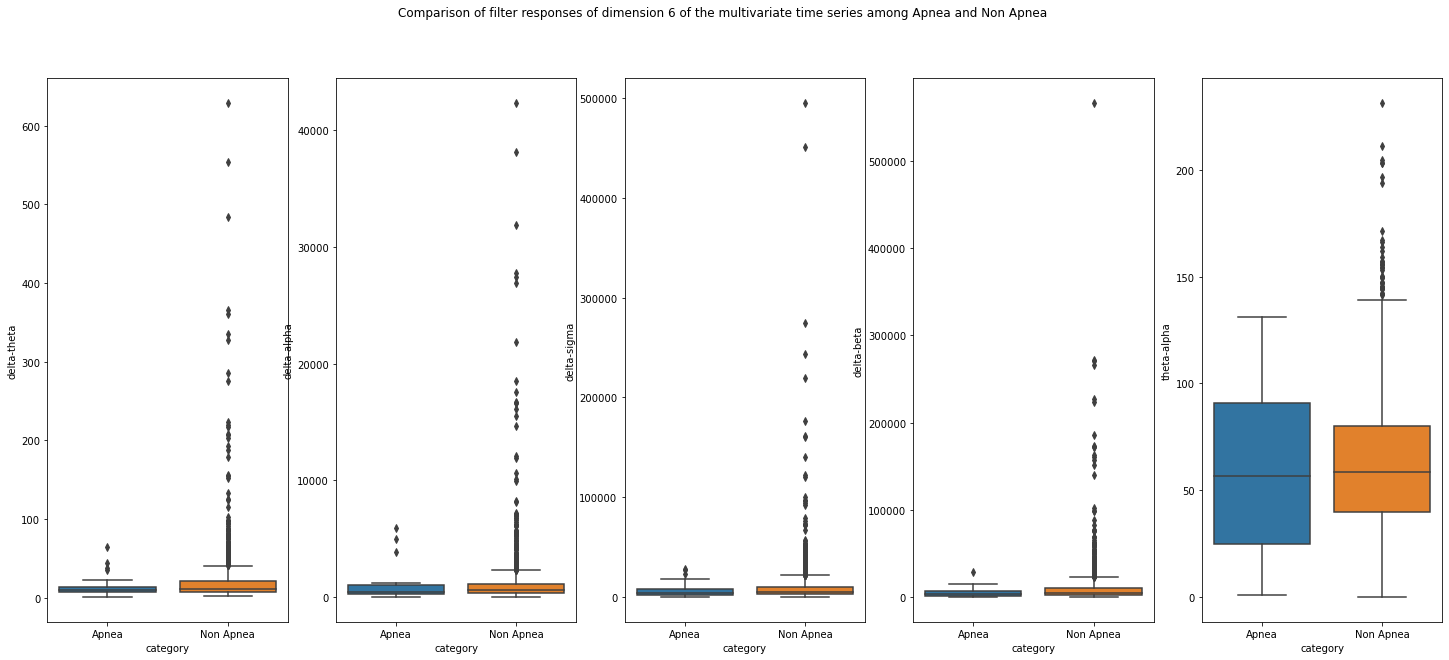

- - - - - - - - - - - - - - - PATIENT 20- - - - - - - - - - - - - - - 


<ipython-input-64-15bc0551fb79>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-64-15bc0551fb79>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


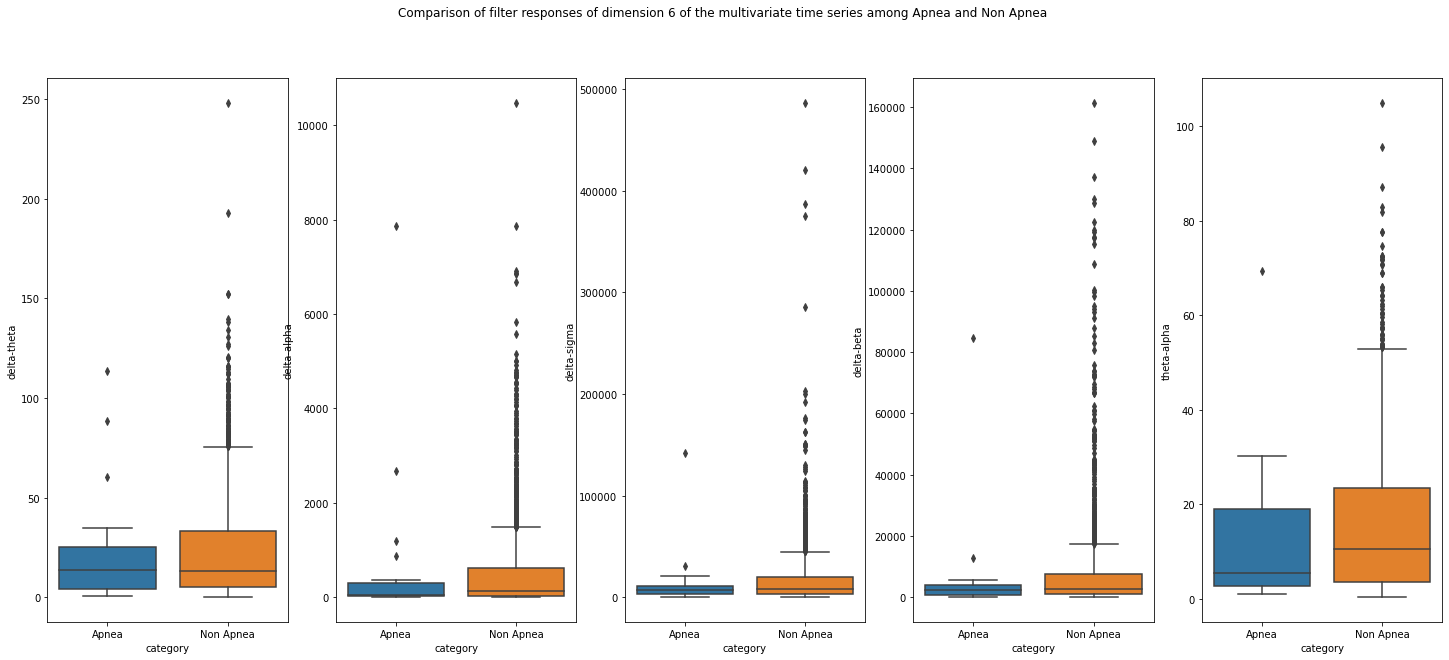

- - - - - - - - - - - - - - - PATIENT 21- - - - - - - - - - - - - - - 


<ipython-input-64-15bc0551fb79>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-64-15bc0551fb79>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


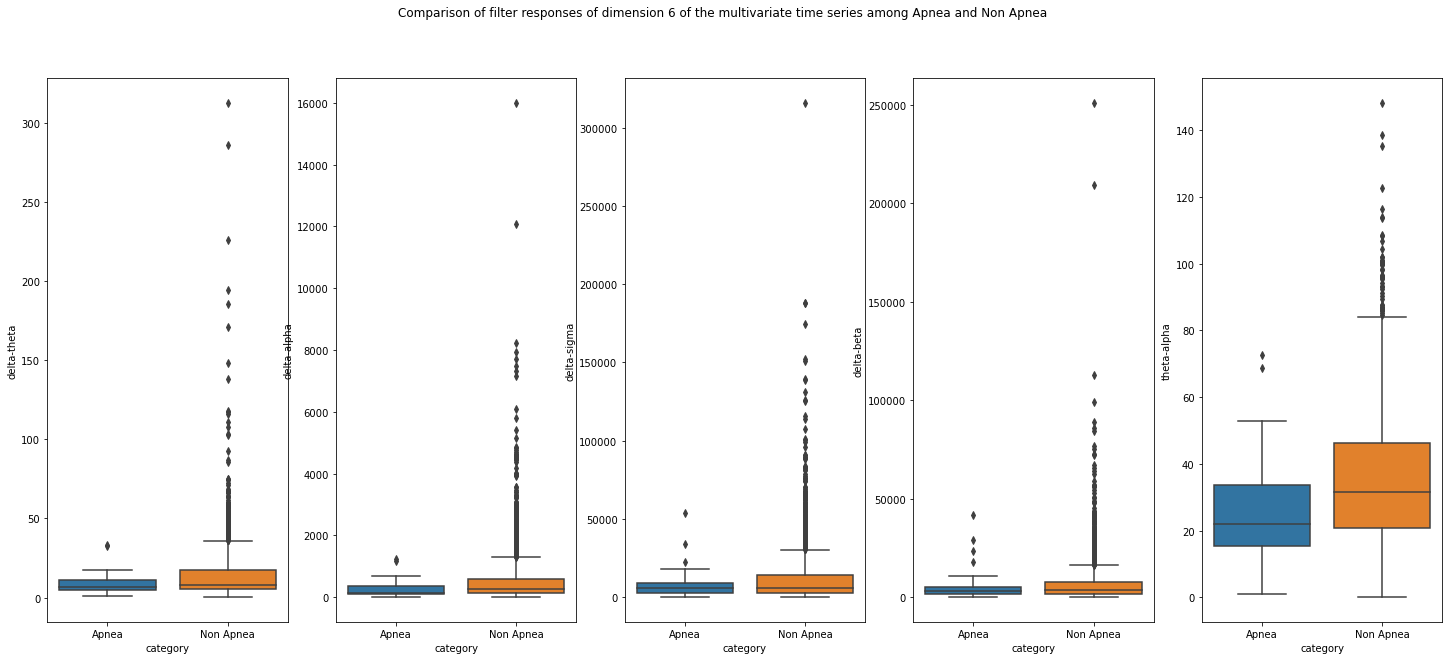

In [67]:
## for each patient individually now (it is said to be subject-specific criterion between A and NA in the paper)
## https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6595536/?fbclid=IwAR1UsmNTauyQKvl1QmunZjow9sSk-SGDrDMt00KyWhhNAkuXnAXkXJc7WRI


for i in range(22):
    print(15*"- " + 'PATIENT '+str(i) + 15*"- " )
    features_boxplots(X_EEG1[i*200:(i+1)*200,:], 6, , outliers_boolean=True)

- - - - - - - - - - - - - - - PATIENT 0- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


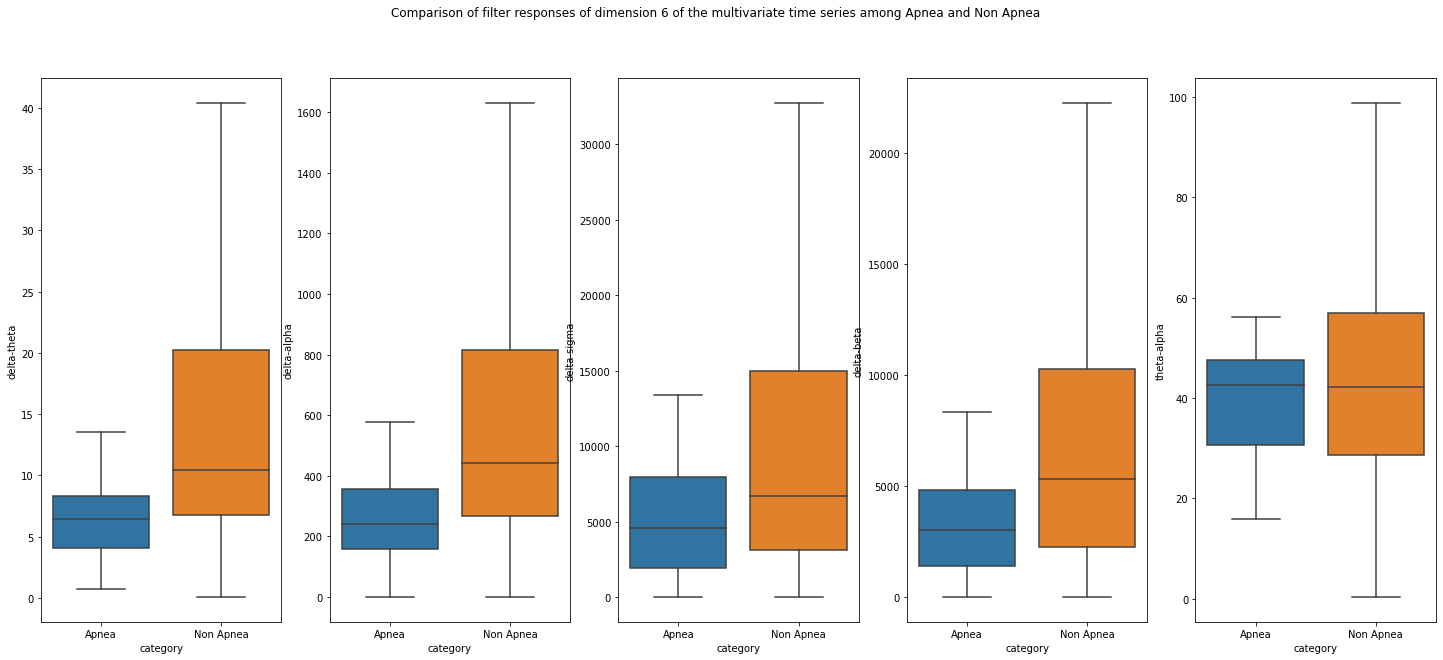

- - - - - - - - - - - - - - - PATIENT 1- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


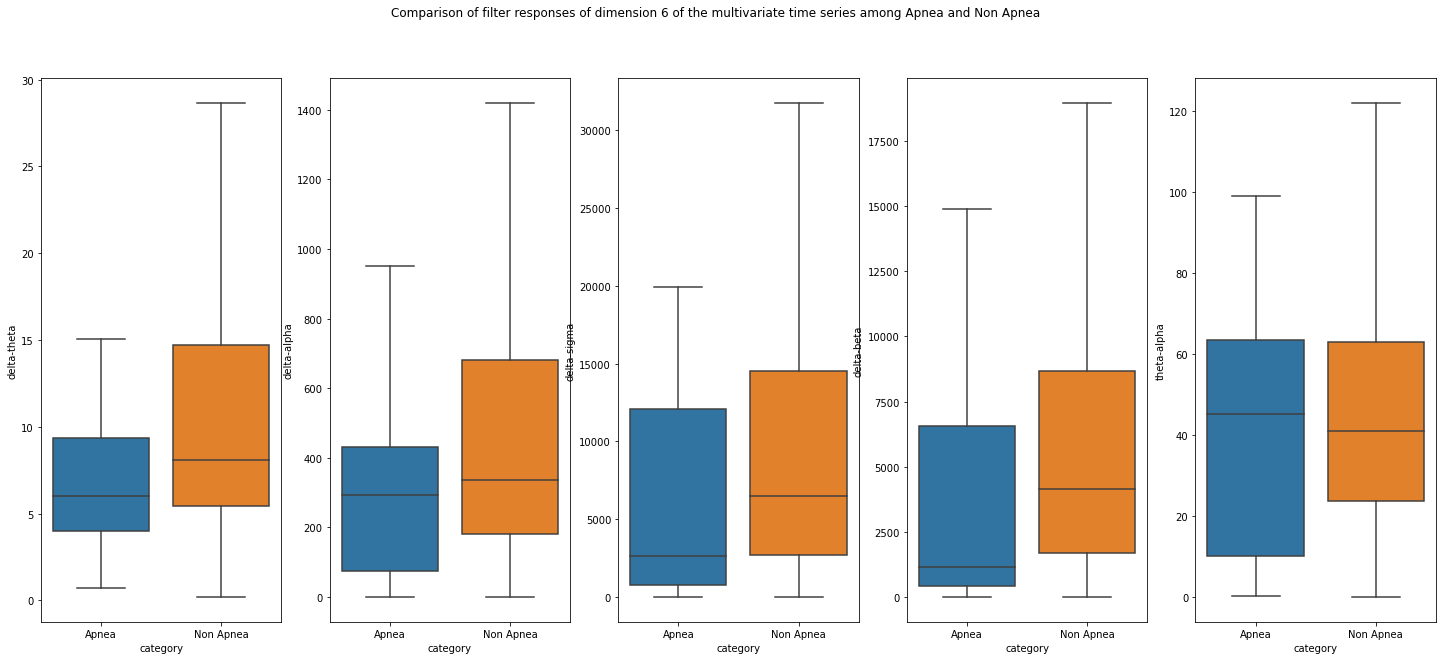

- - - - - - - - - - - - - - - PATIENT 2- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


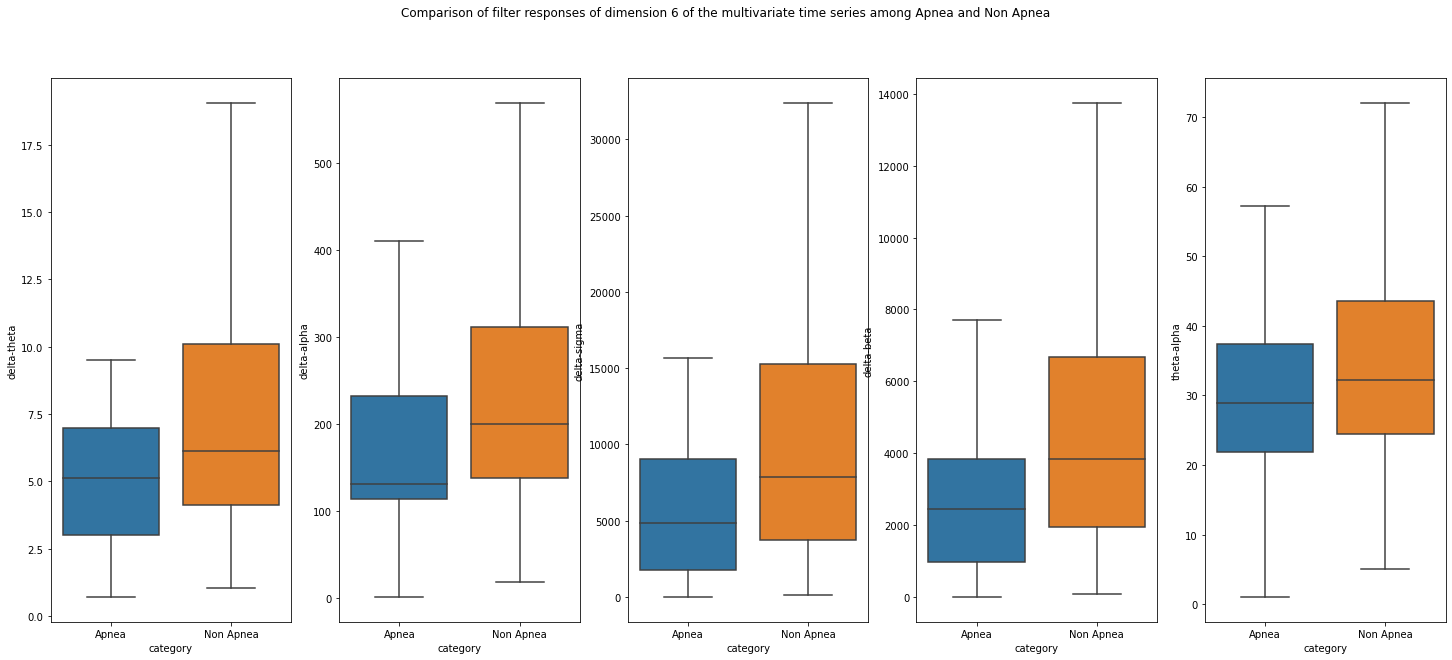

- - - - - - - - - - - - - - - PATIENT 3- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


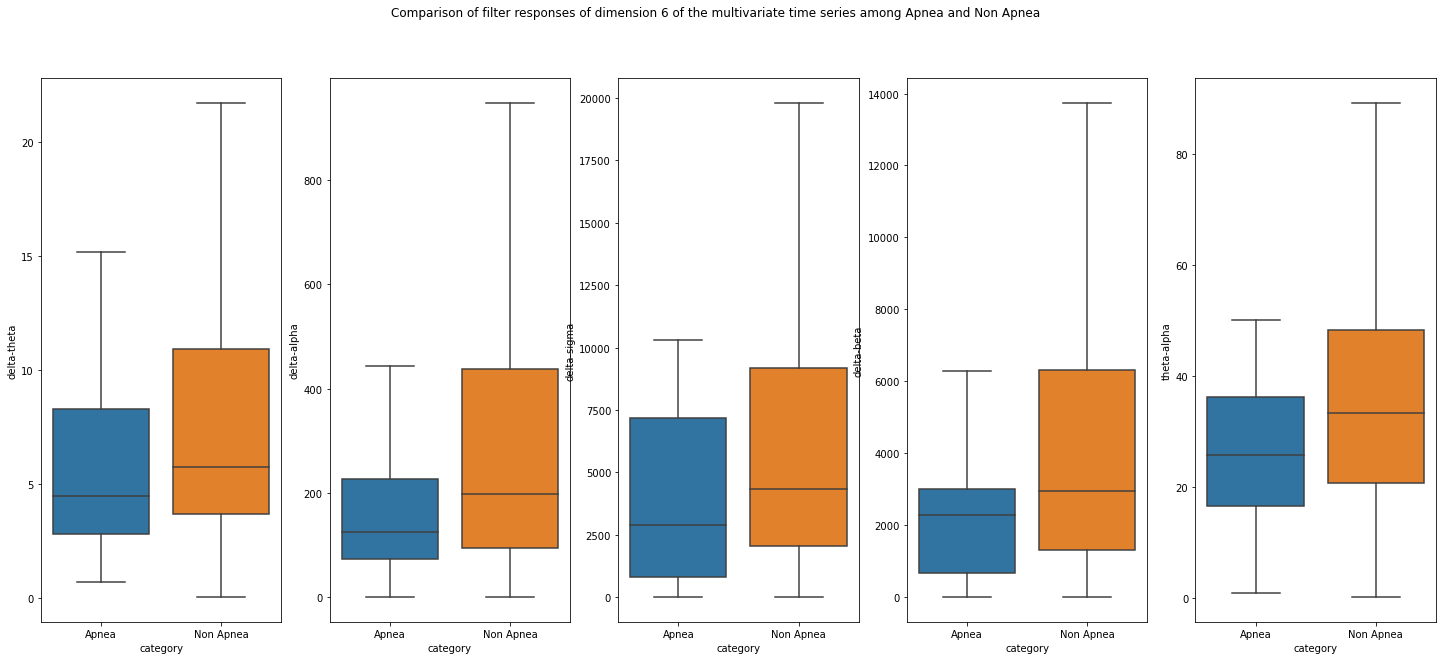

- - - - - - - - - - - - - - - PATIENT 4- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


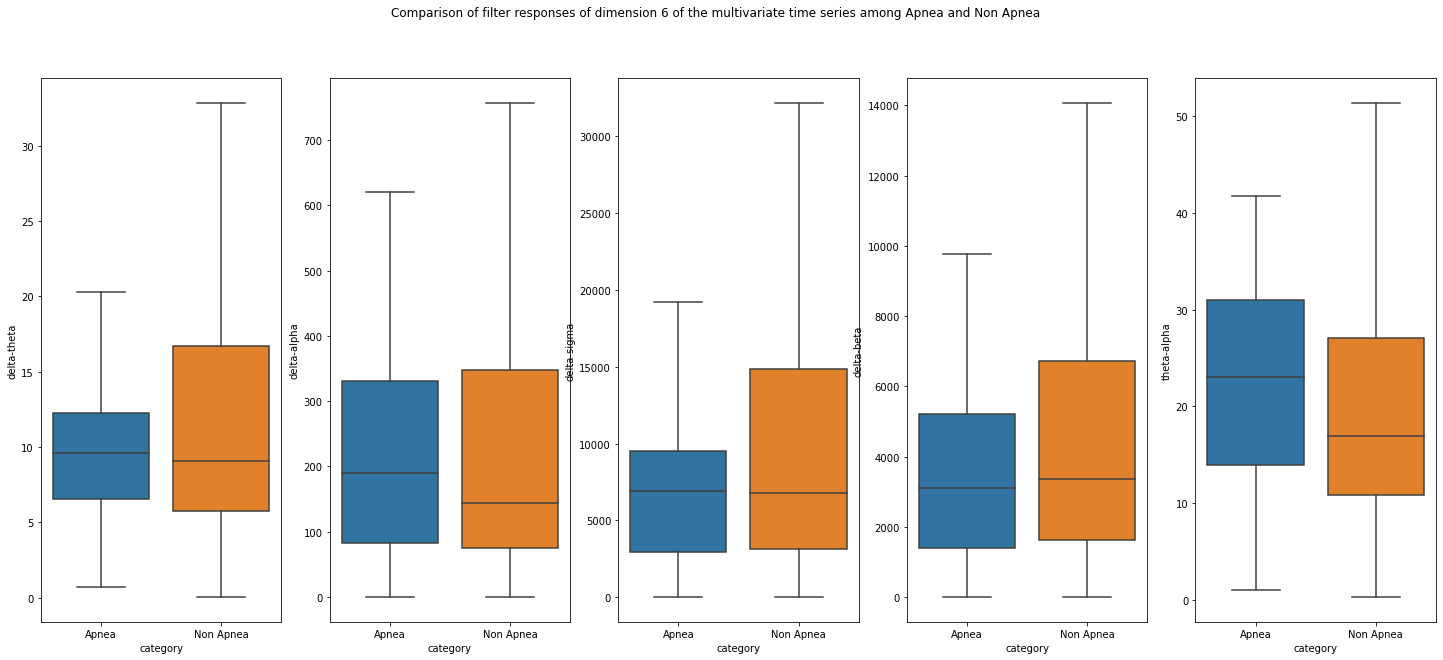

- - - - - - - - - - - - - - - PATIENT 5- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


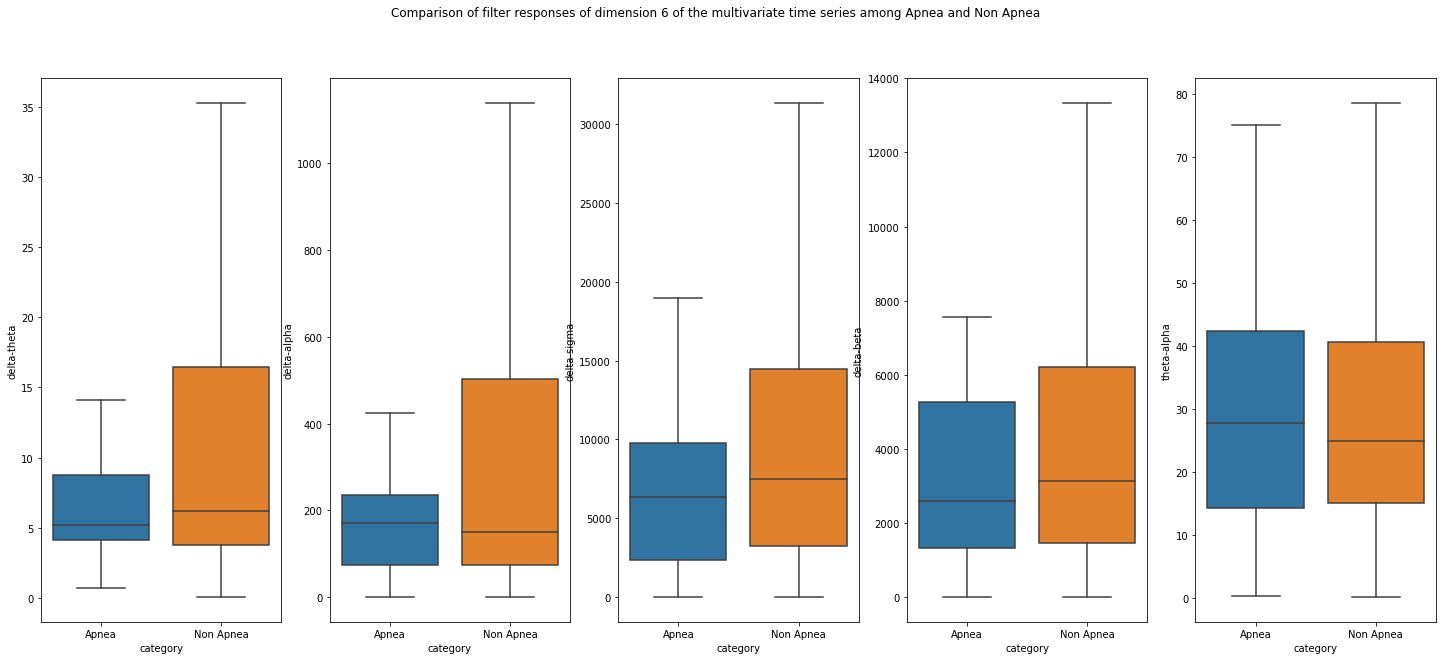

- - - - - - - - - - - - - - - PATIENT 6- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


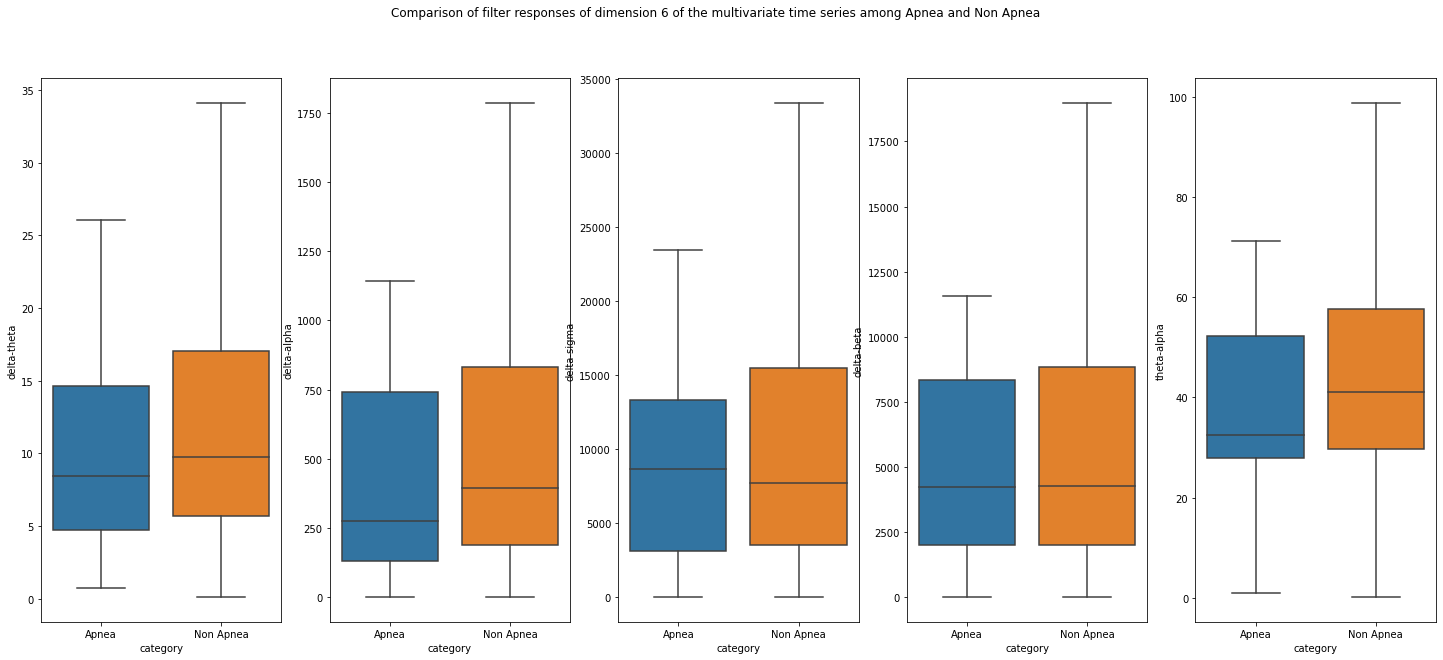

- - - - - - - - - - - - - - - PATIENT 7- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


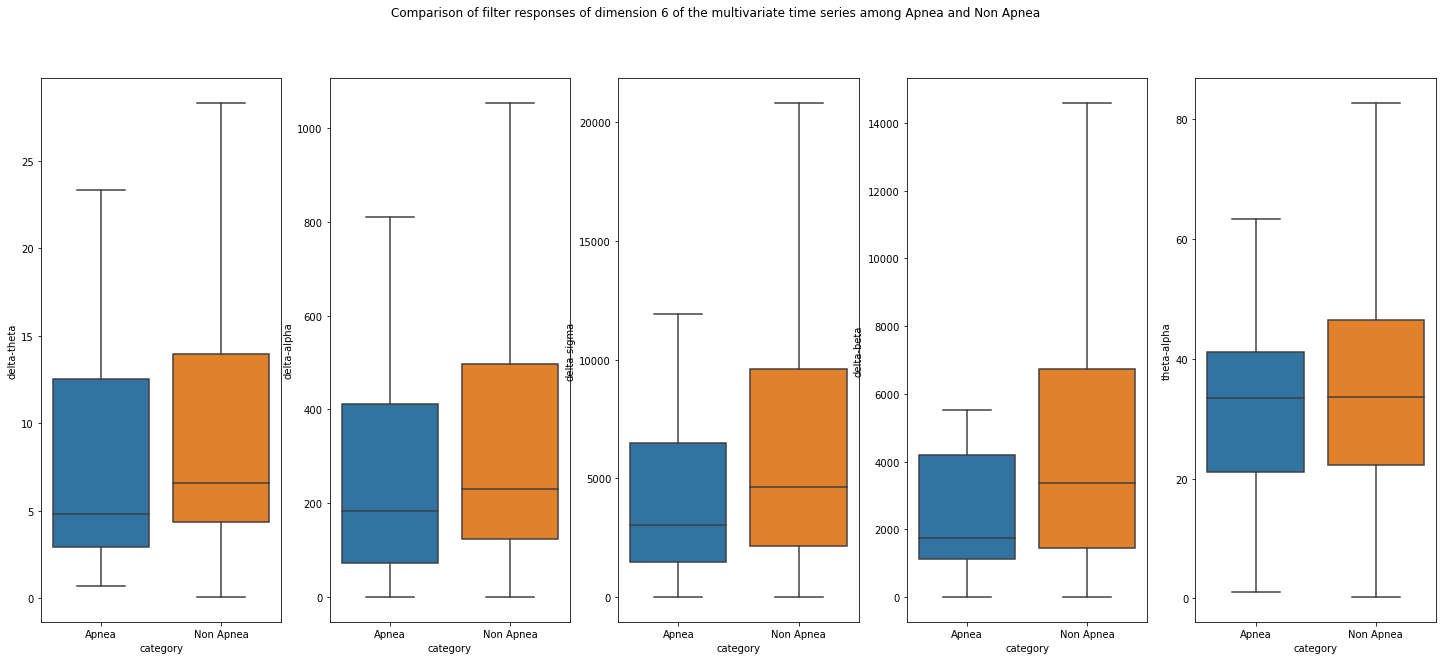

- - - - - - - - - - - - - - - PATIENT 8- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


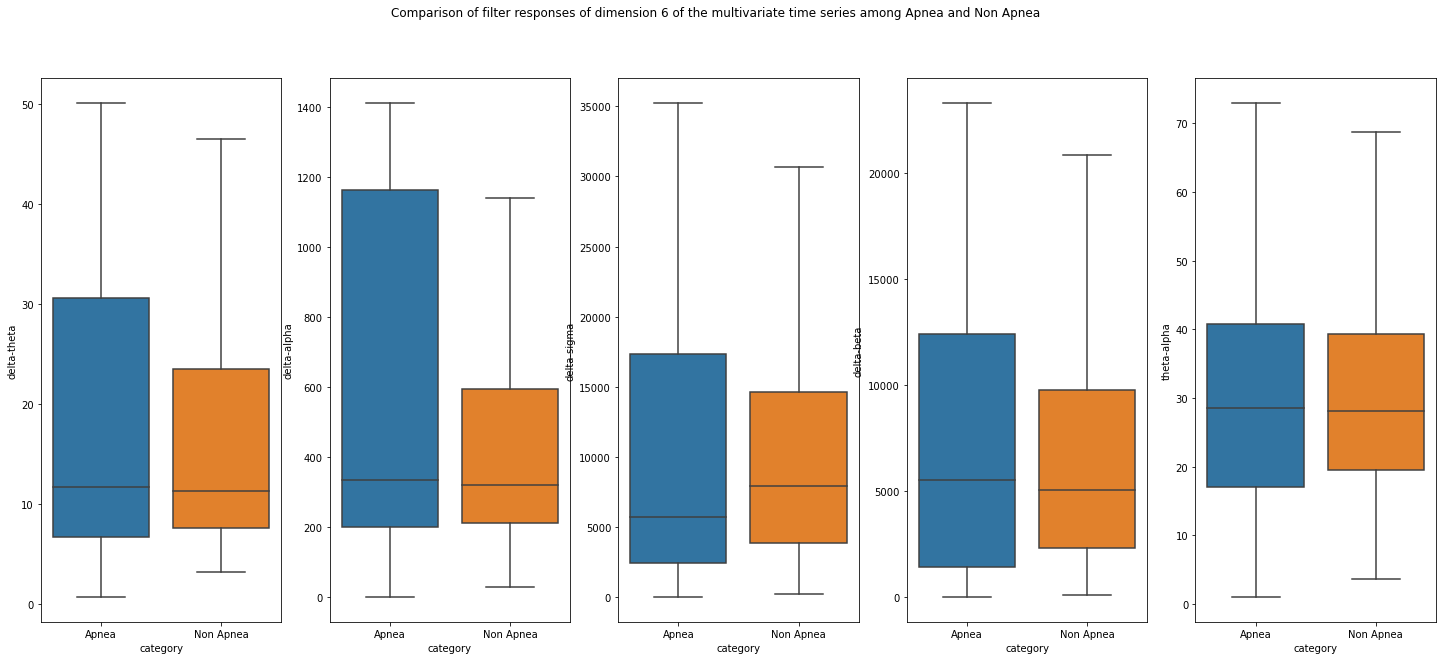

- - - - - - - - - - - - - - - PATIENT 9- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


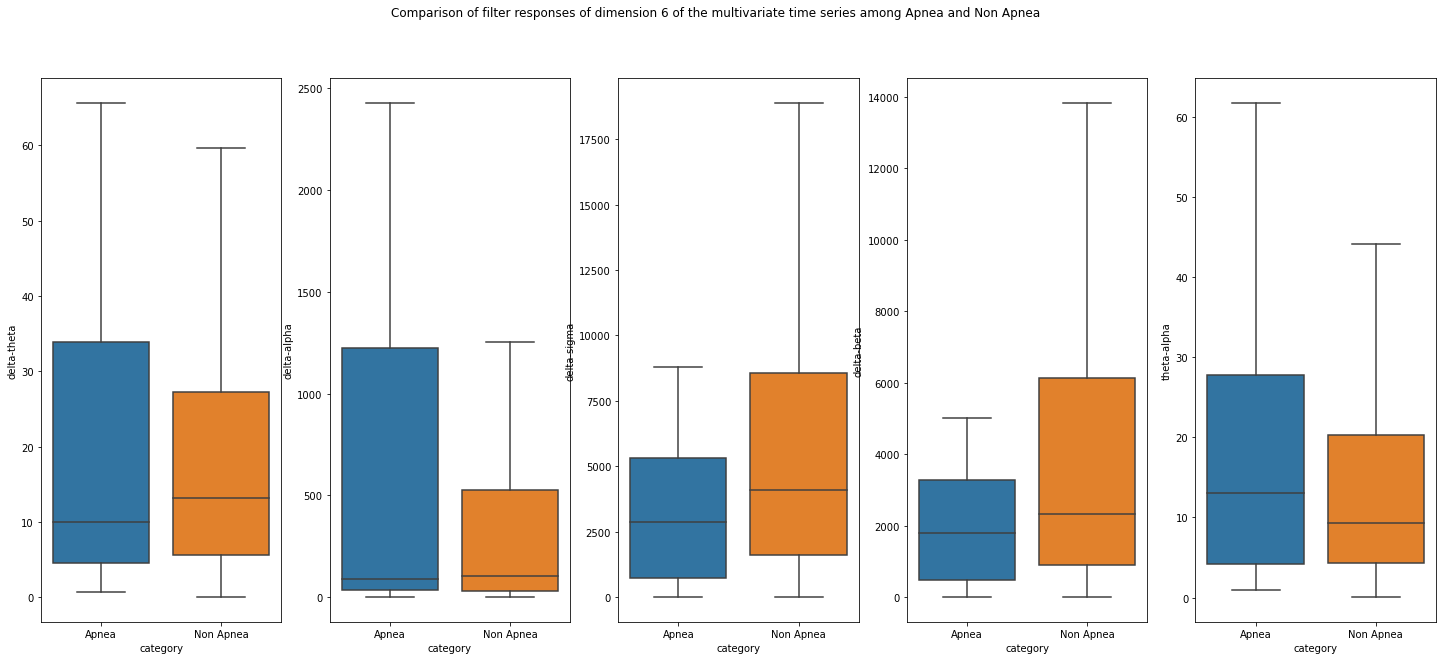

- - - - - - - - - - - - - - - PATIENT 10- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


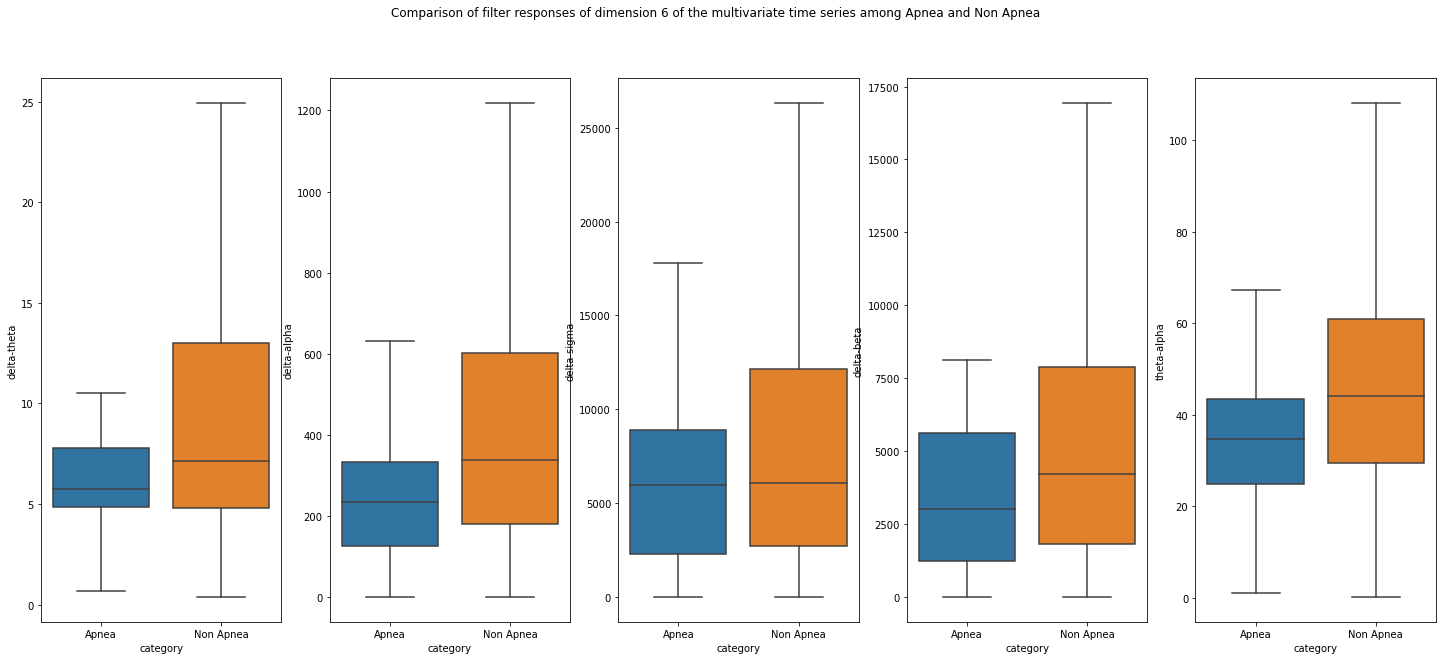

- - - - - - - - - - - - - - - PATIENT 11- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


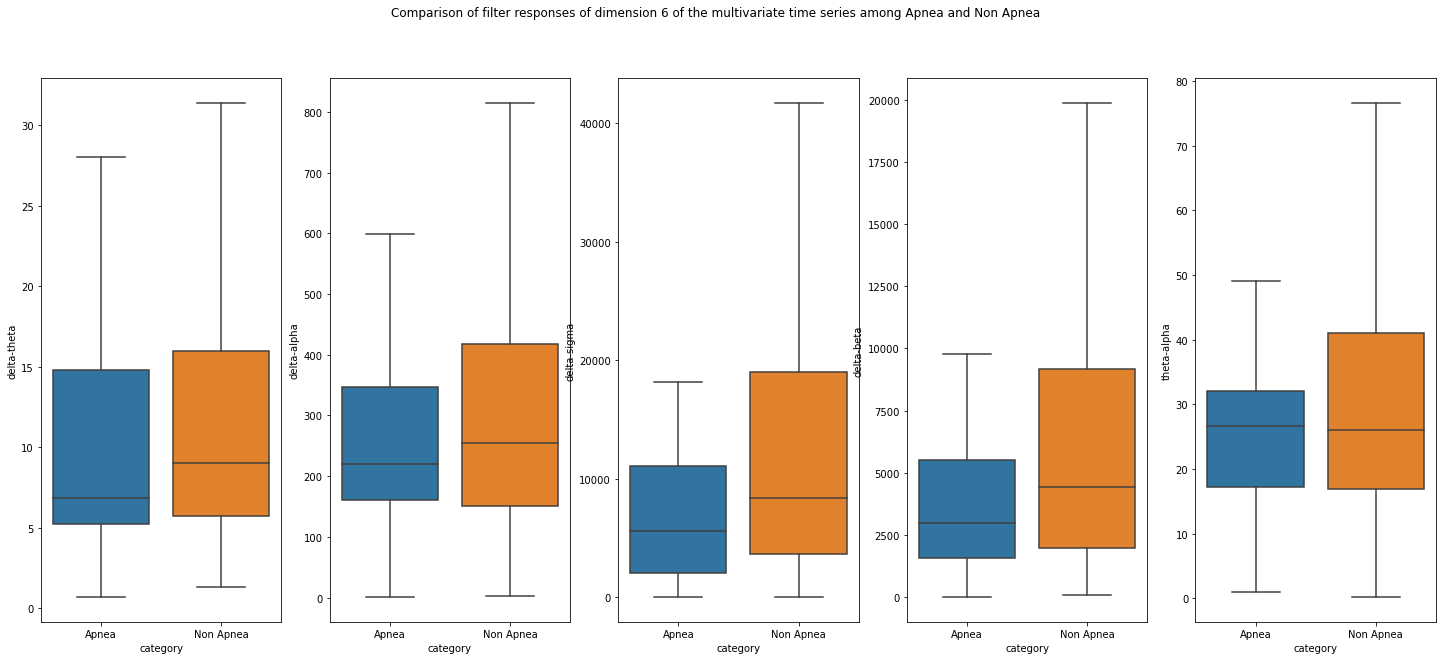

- - - - - - - - - - - - - - - PATIENT 12- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


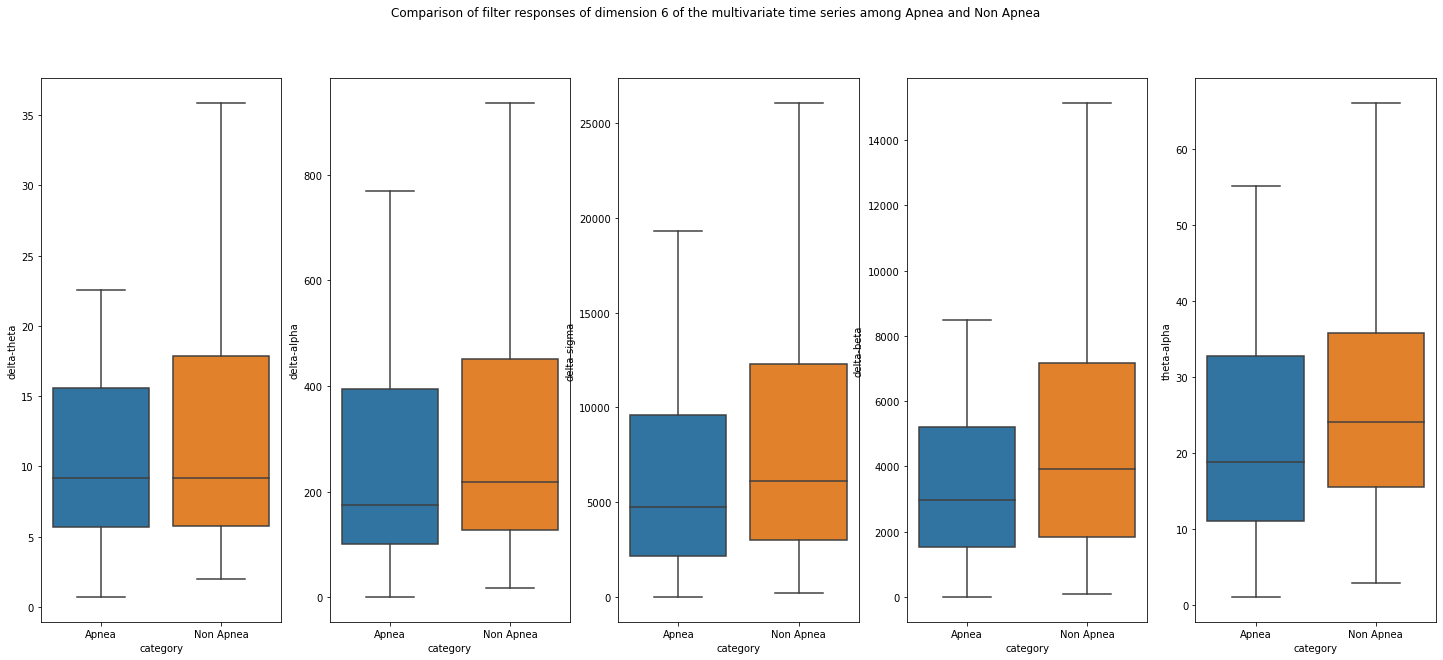

- - - - - - - - - - - - - - - PATIENT 13- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


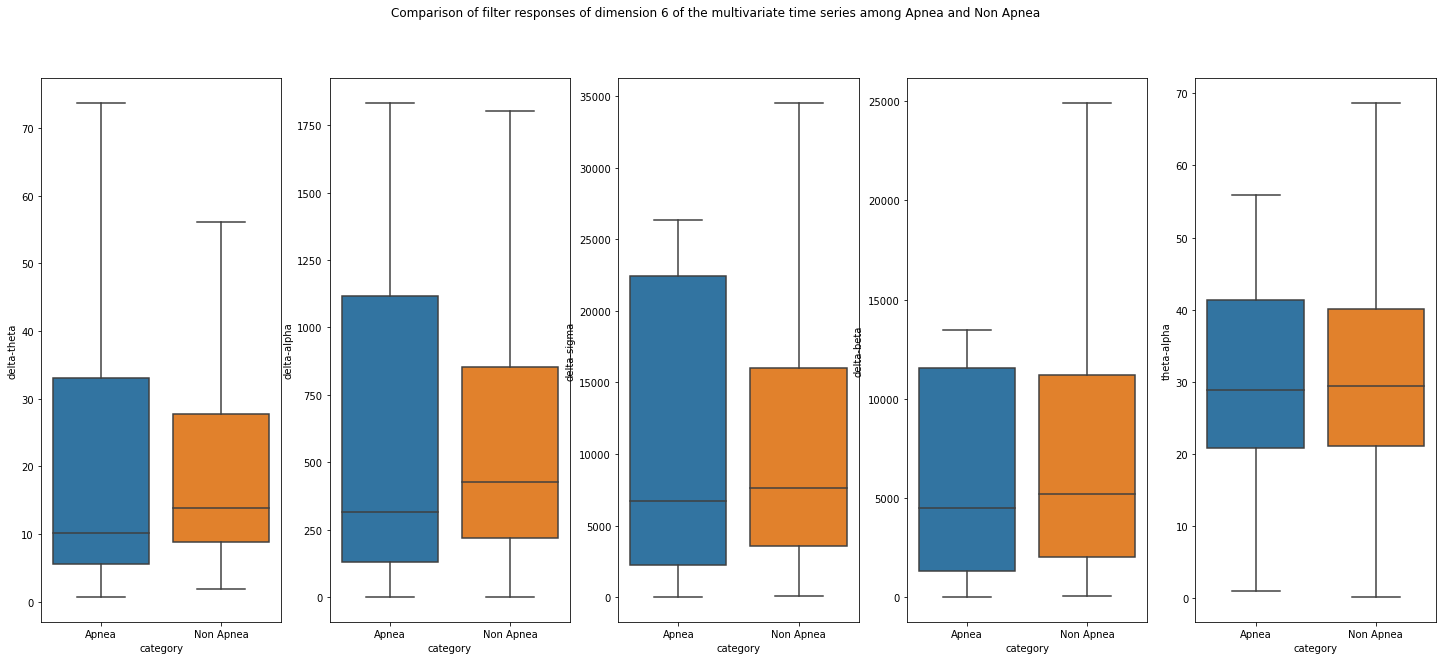

- - - - - - - - - - - - - - - PATIENT 14- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


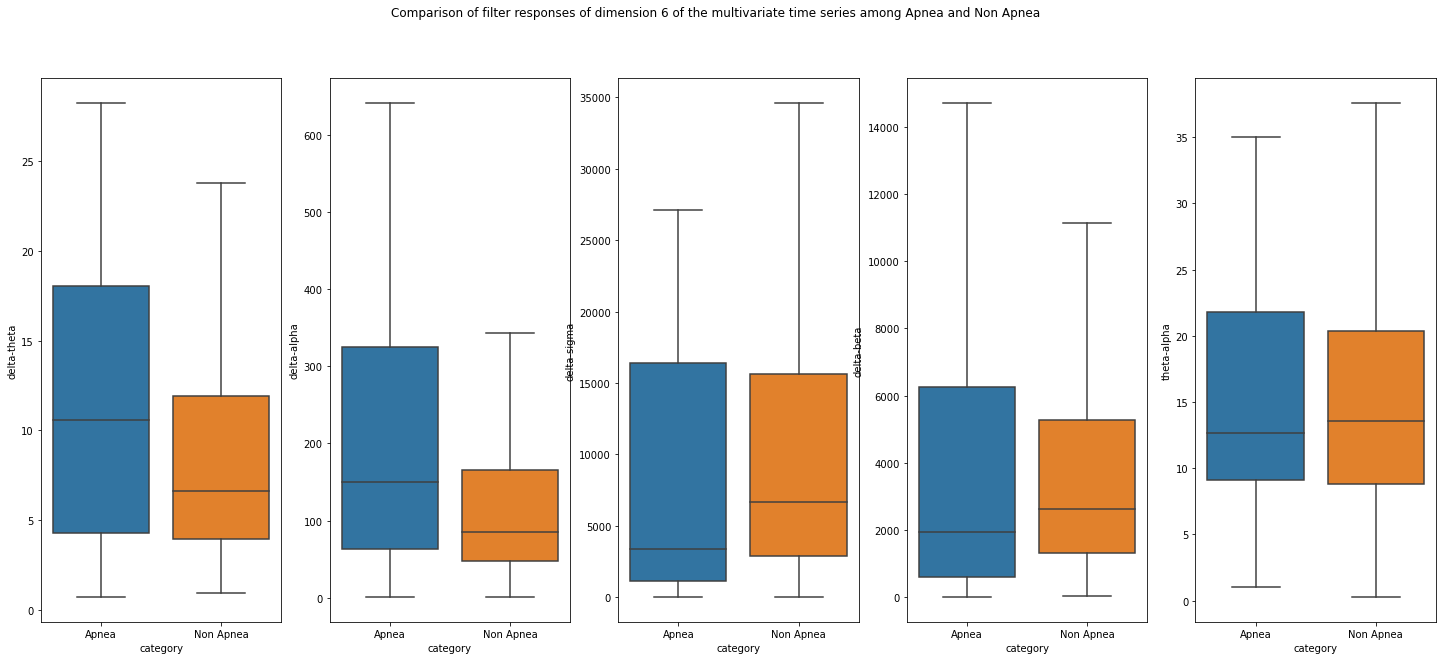

- - - - - - - - - - - - - - - PATIENT 15- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


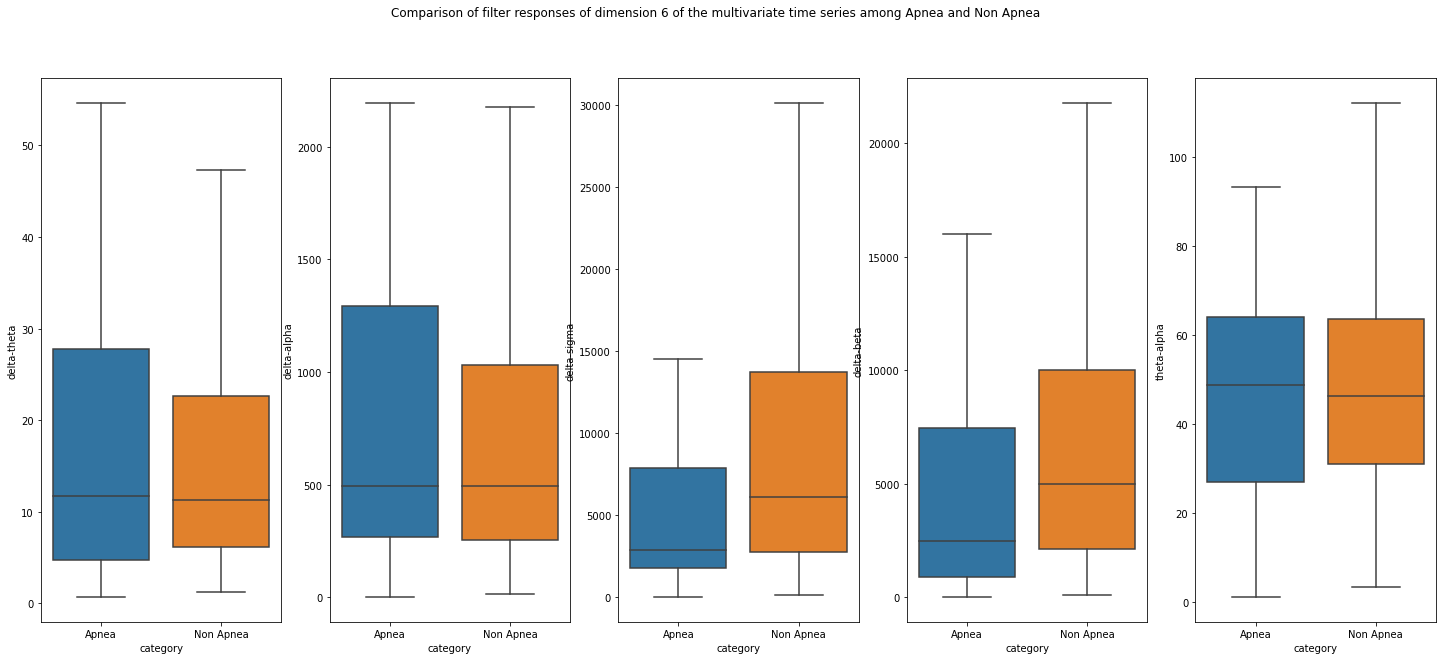

- - - - - - - - - - - - - - - PATIENT 16- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


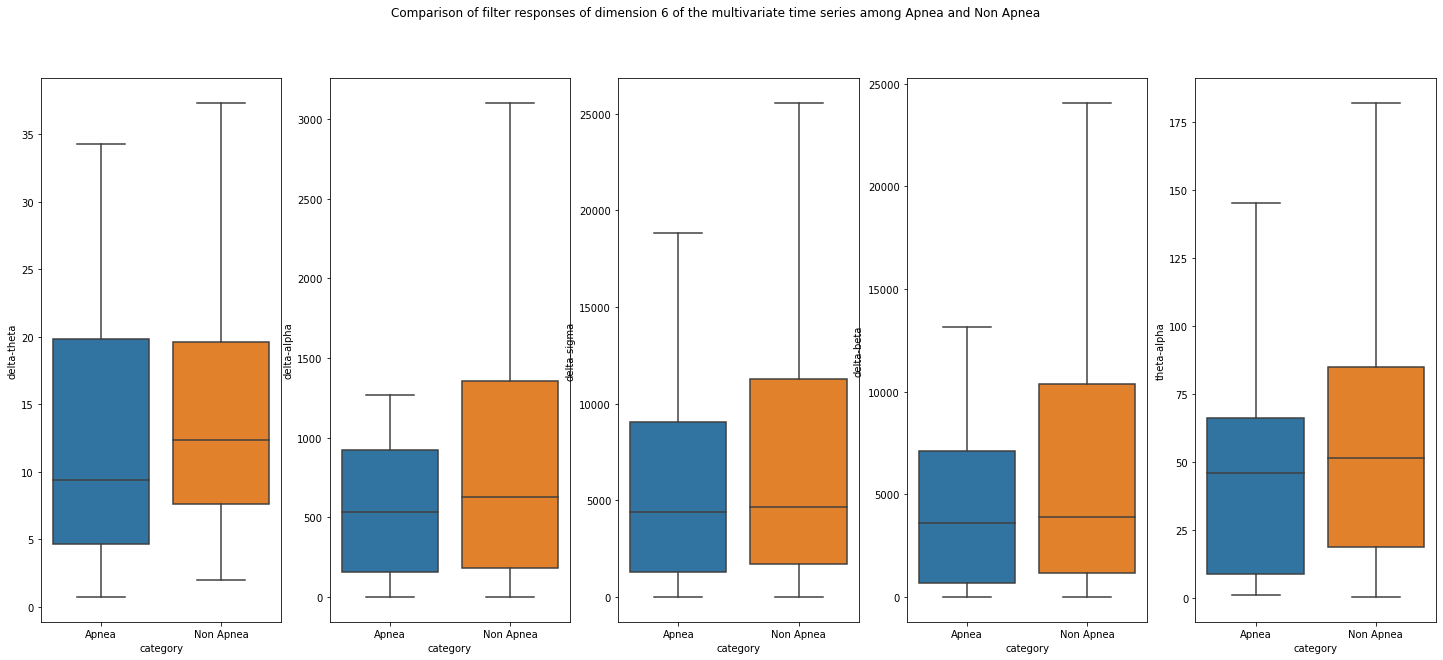

- - - - - - - - - - - - - - - PATIENT 17- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


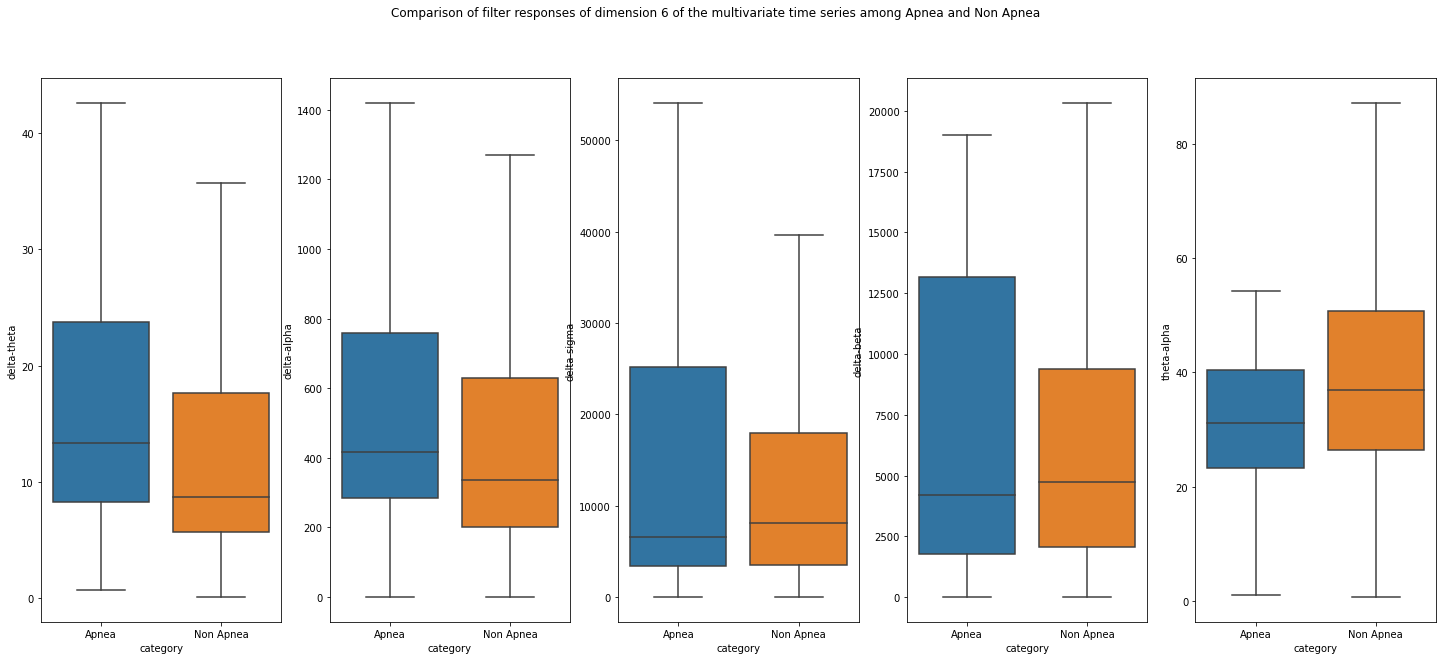

- - - - - - - - - - - - - - - PATIENT 18- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


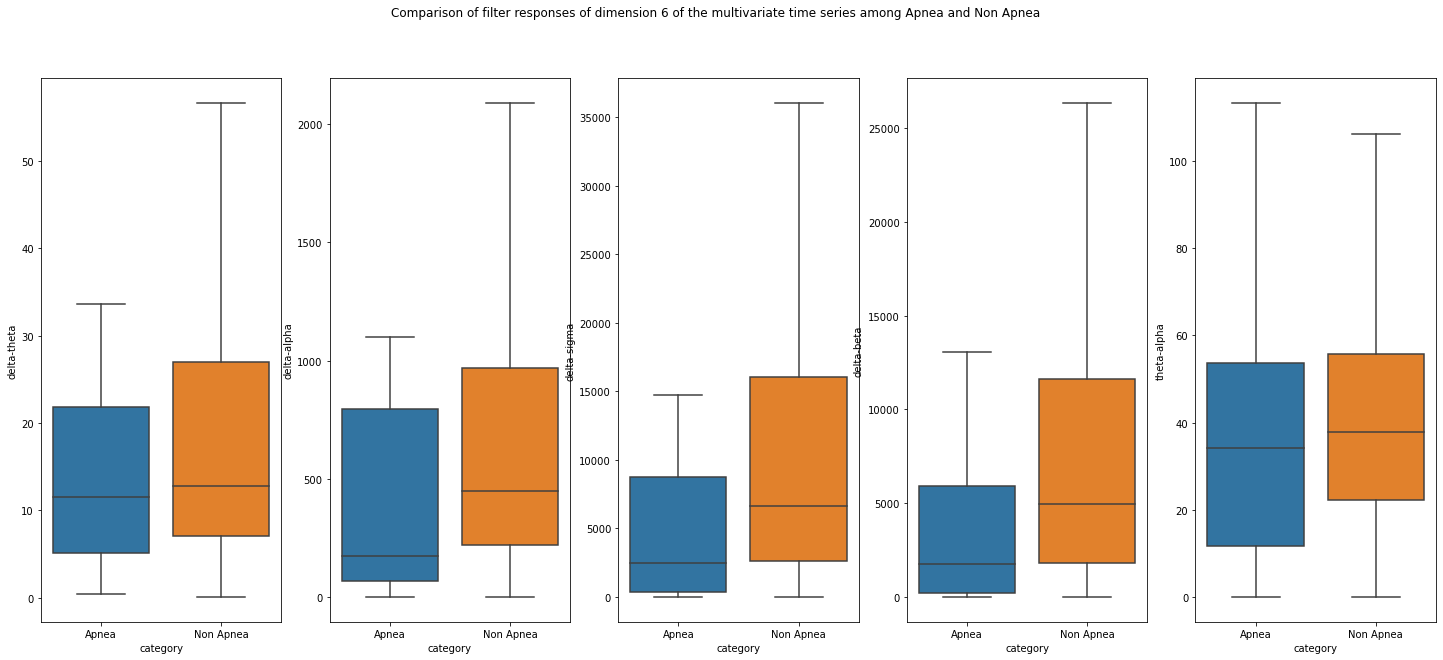

- - - - - - - - - - - - - - - PATIENT 19- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


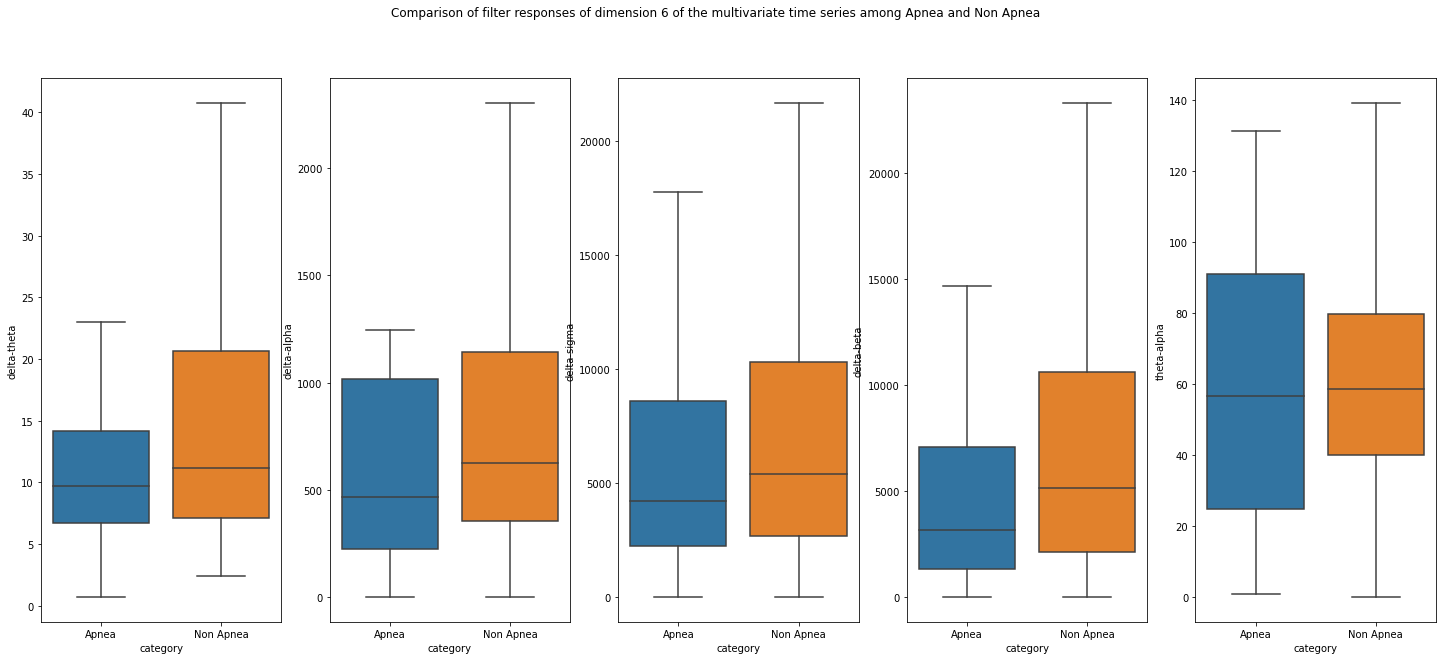

- - - - - - - - - - - - - - - PATIENT 20- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


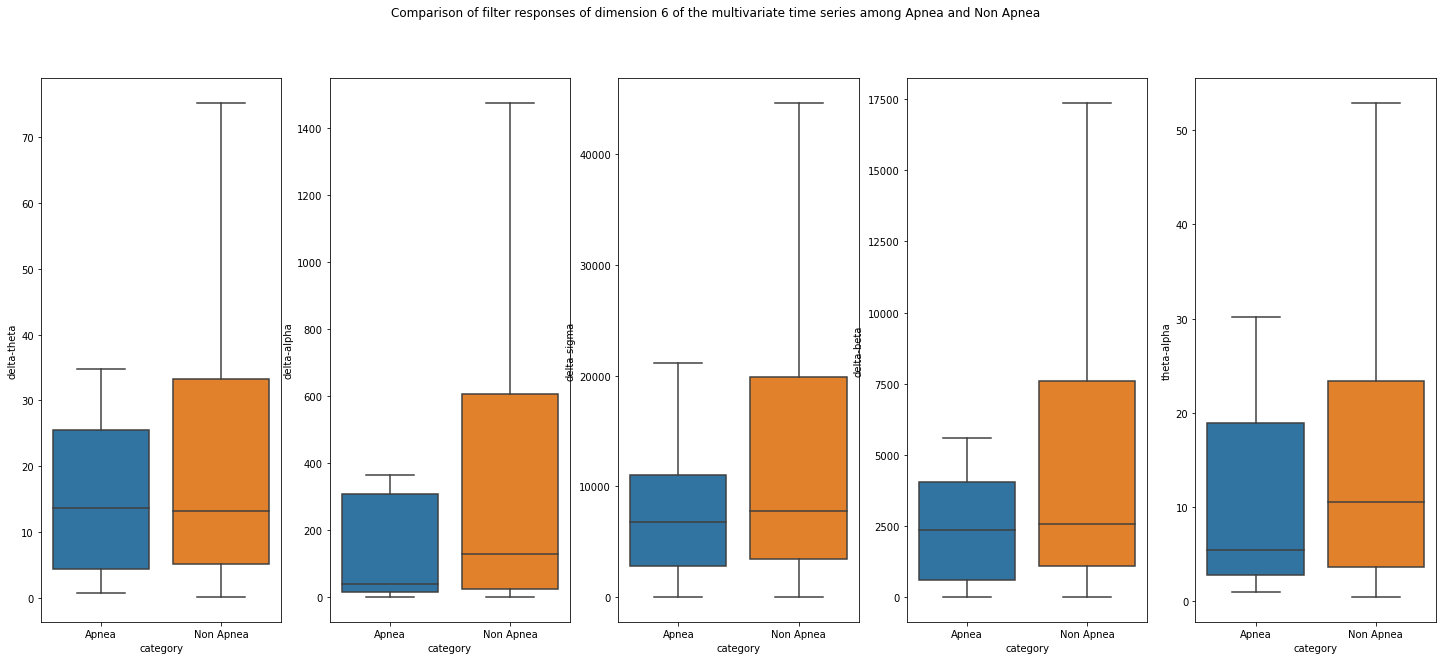

- - - - - - - - - - - - - - - PATIENT 21- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


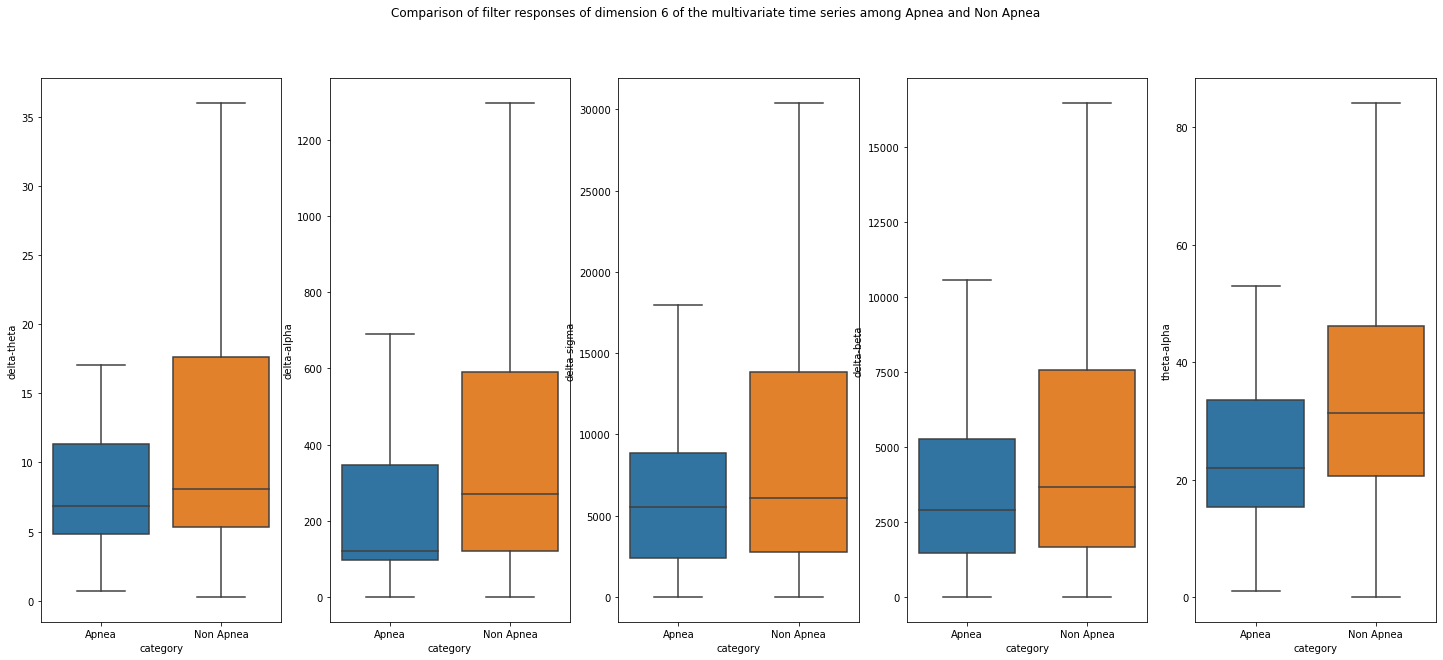

In [72]:
## same but without outliers in the plots

for i in range(22):
    print(15*"- " + 'PATIENT '+str(i) + 15*"- " )
    features_boxplots(X_EEG1[i*200:(i+1)*200,:], 6, outliers_boolean=False)

## Analysis of EEG2

<ipython-input-64-15bc0551fb79>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-64-15bc0551fb79>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


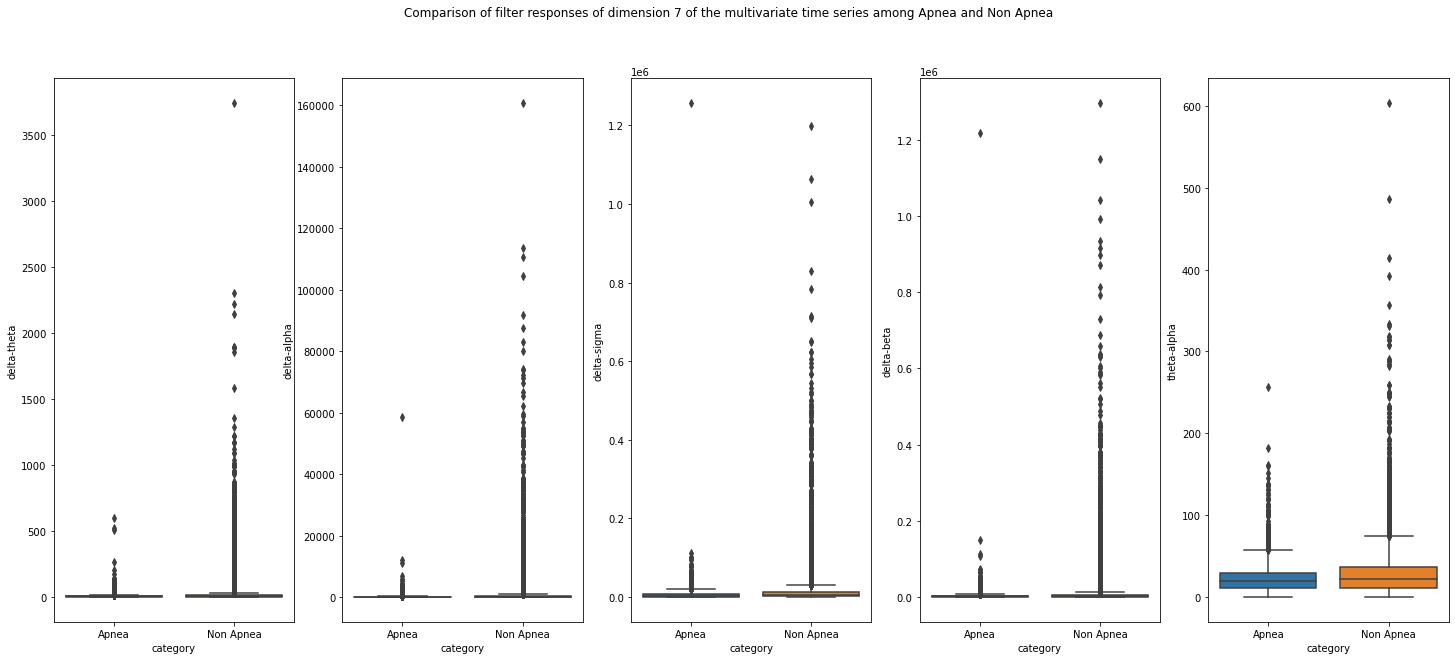

In [68]:
## all patients in one shot -- EEG2

features_boxplots(X_EEG2, 7, outliers_boolean=True)

<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


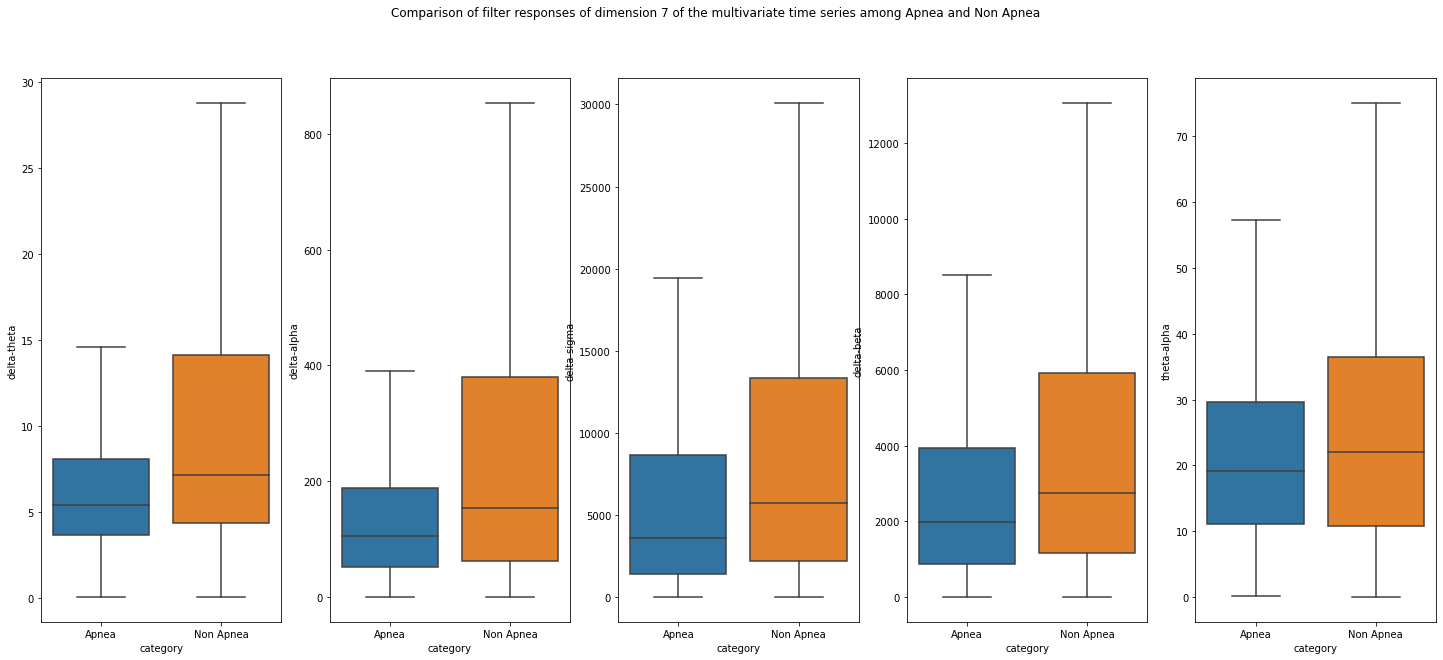

In [73]:
## same but without outliers in the plots

features_boxplots(X_EEG2, 7, outliers_boolean=False)

- - - - - - - - - - - - - - - PATIENT 0- - - - - - - - - - - - - - - 


<ipython-input-76-44aba9a8e99b>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-76-44aba9a8e99b>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


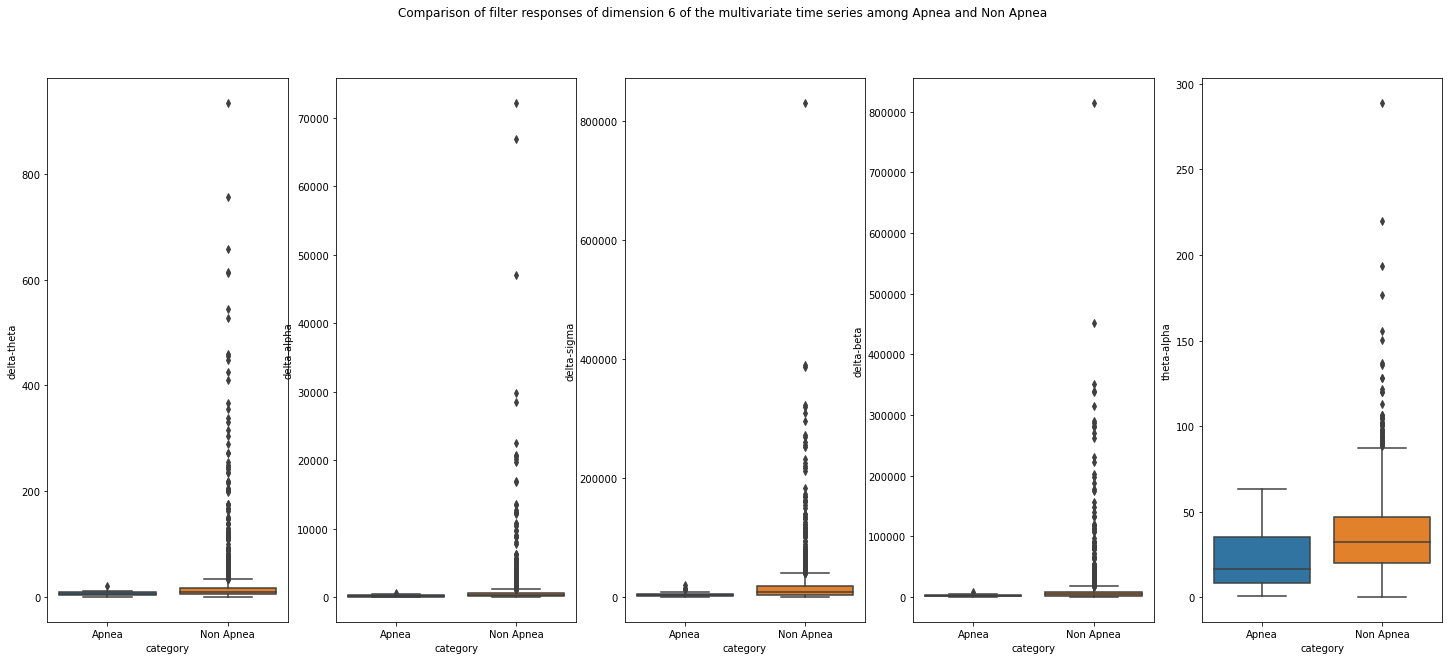

- - - - - - - - - - - - - - - PATIENT 1- - - - - - - - - - - - - - - 


<ipython-input-76-44aba9a8e99b>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-76-44aba9a8e99b>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


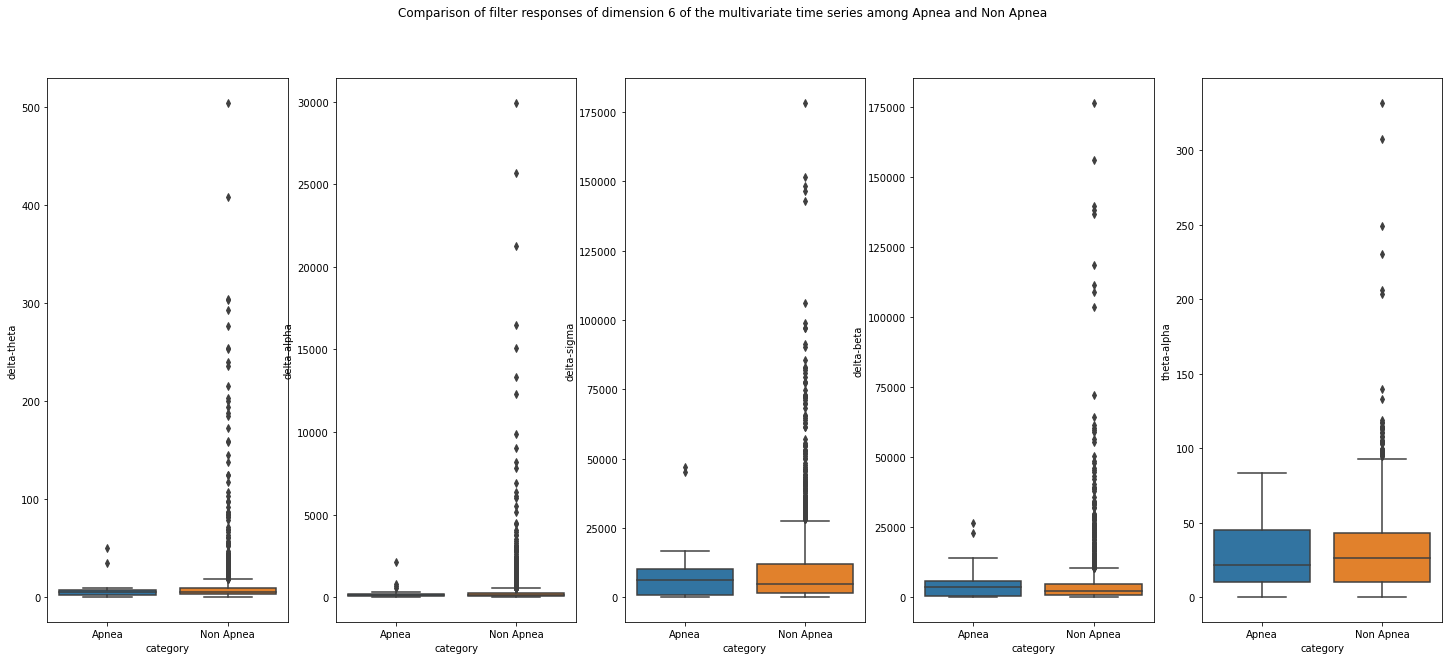

- - - - - - - - - - - - - - - PATIENT 2- - - - - - - - - - - - - - - 


<ipython-input-76-44aba9a8e99b>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-76-44aba9a8e99b>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


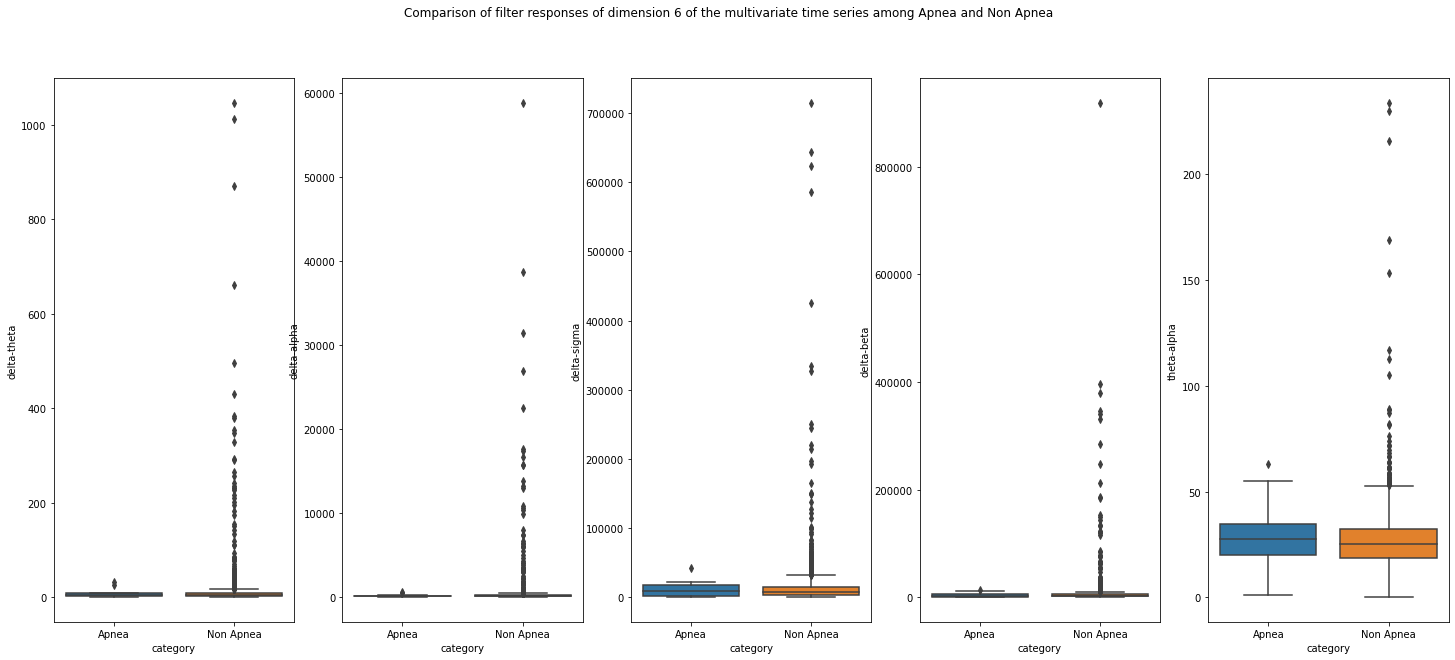

- - - - - - - - - - - - - - - PATIENT 3- - - - - - - - - - - - - - - 


<ipython-input-76-44aba9a8e99b>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-76-44aba9a8e99b>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


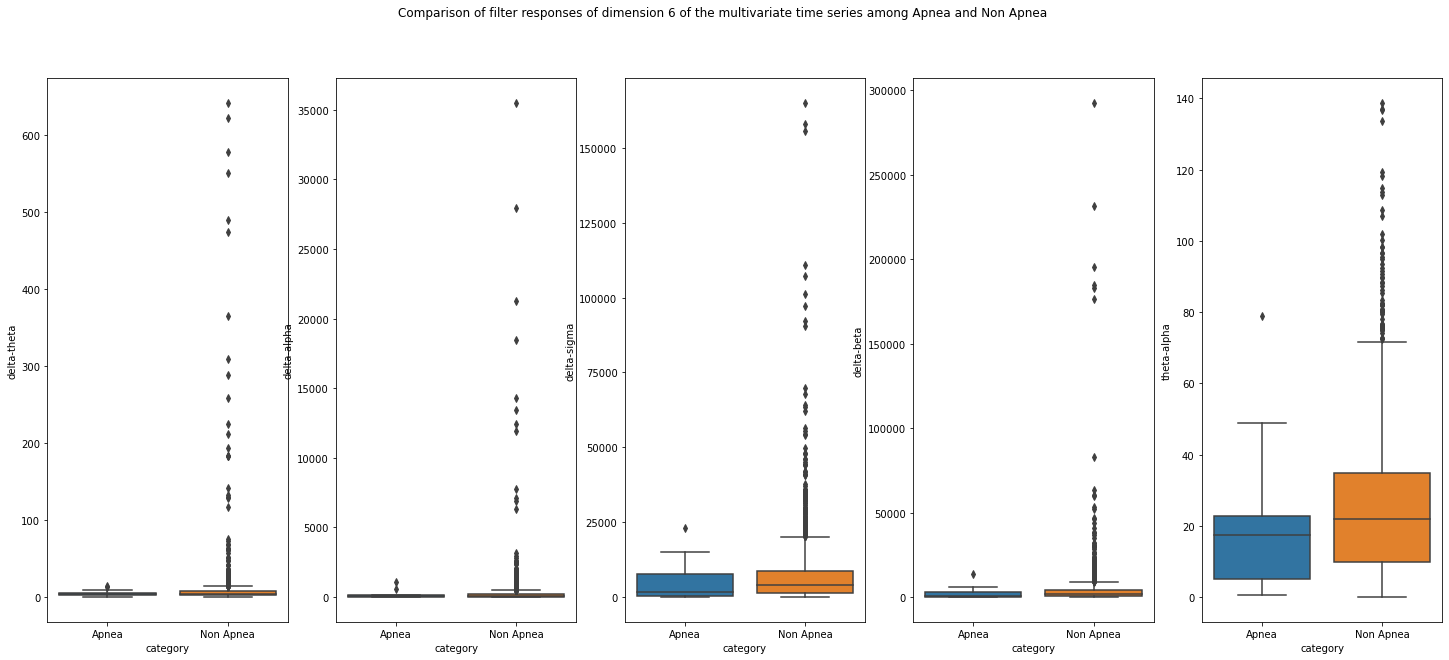

- - - - - - - - - - - - - - - PATIENT 4- - - - - - - - - - - - - - - 


<ipython-input-76-44aba9a8e99b>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-76-44aba9a8e99b>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


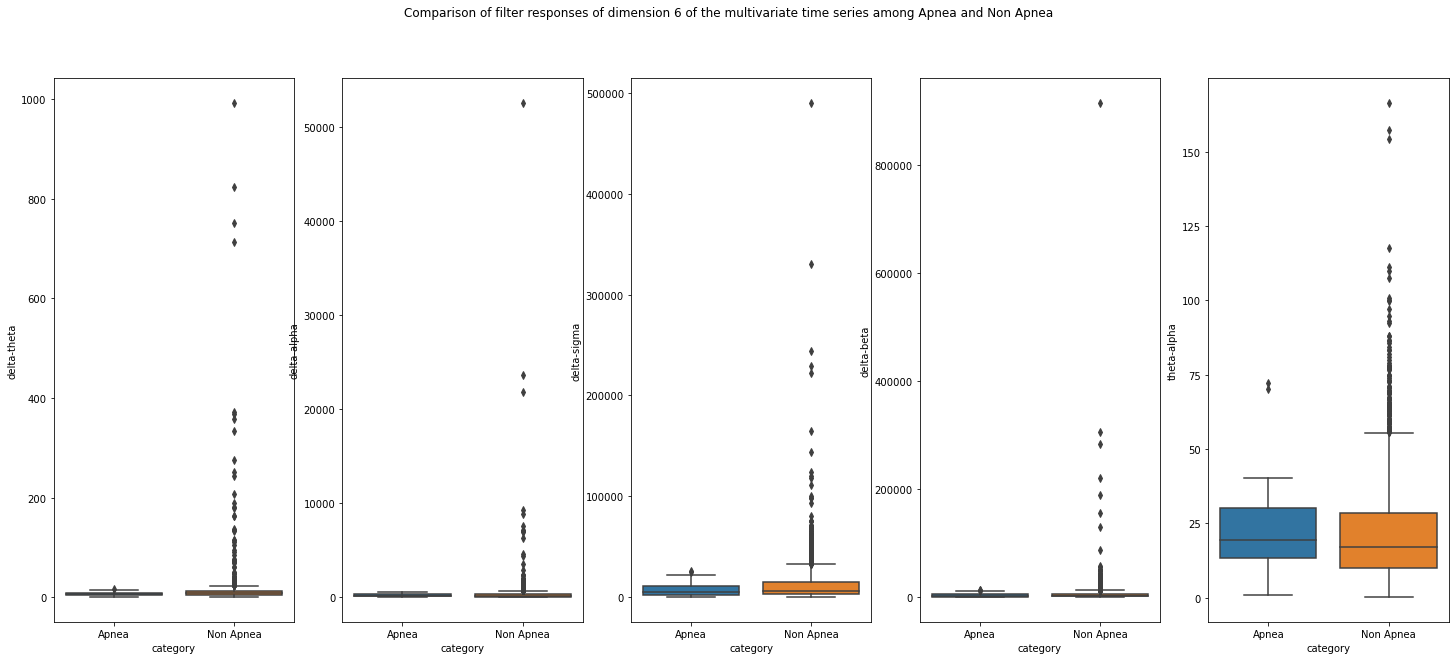

- - - - - - - - - - - - - - - PATIENT 5- - - - - - - - - - - - - - - 


<ipython-input-76-44aba9a8e99b>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-76-44aba9a8e99b>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


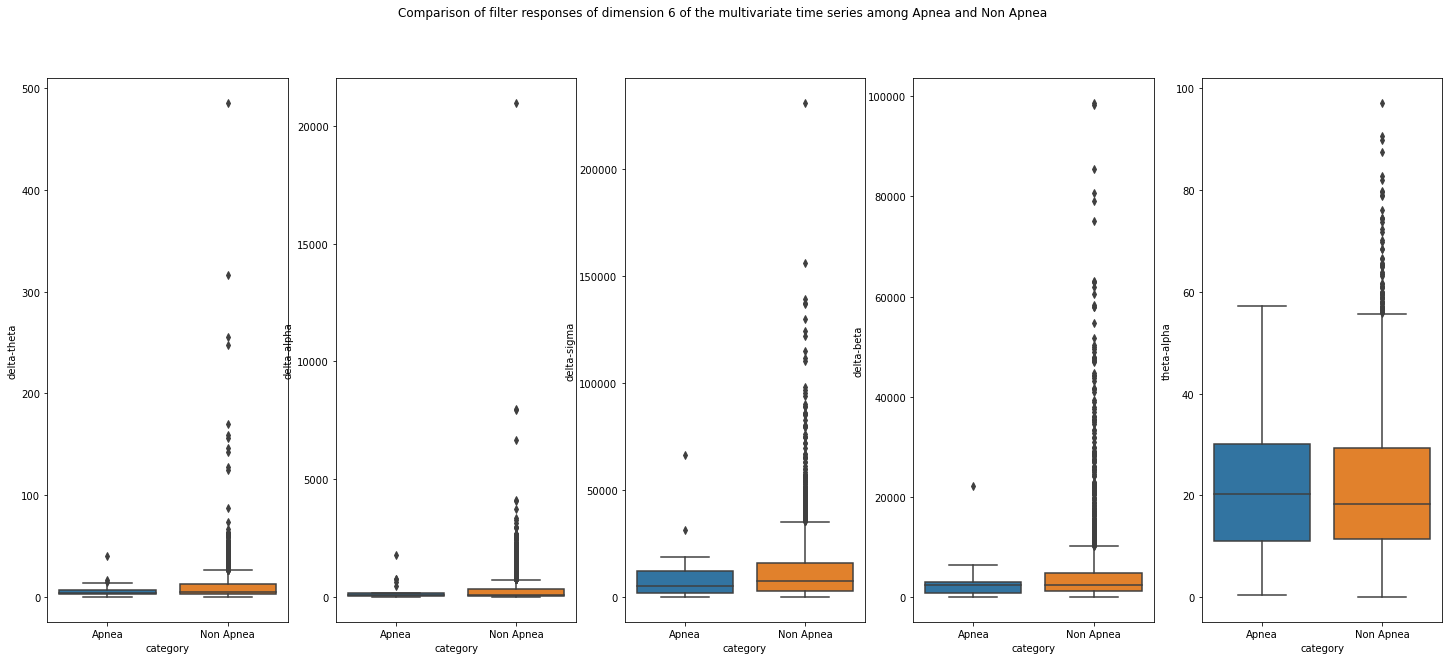

- - - - - - - - - - - - - - - PATIENT 6- - - - - - - - - - - - - - - 


<ipython-input-76-44aba9a8e99b>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-76-44aba9a8e99b>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


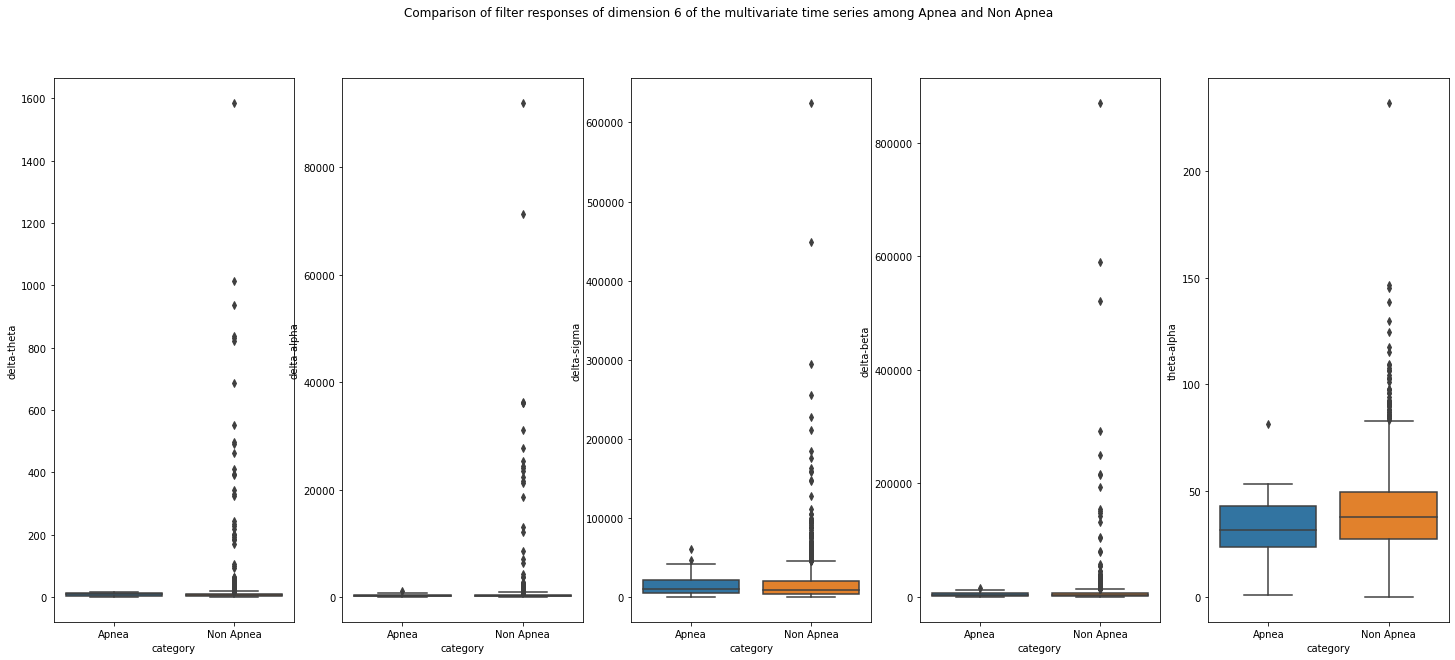

- - - - - - - - - - - - - - - PATIENT 7- - - - - - - - - - - - - - - 


<ipython-input-76-44aba9a8e99b>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-76-44aba9a8e99b>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


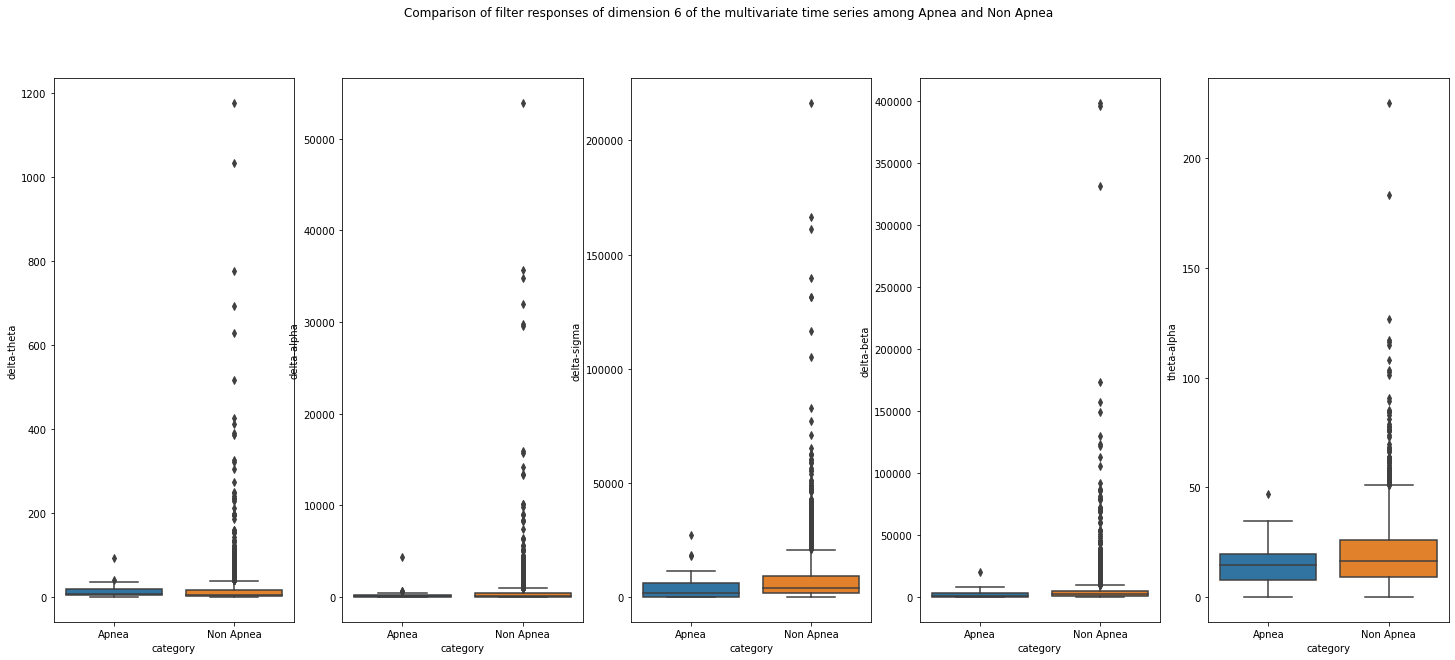

- - - - - - - - - - - - - - - PATIENT 8- - - - - - - - - - - - - - - 


<ipython-input-76-44aba9a8e99b>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-76-44aba9a8e99b>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


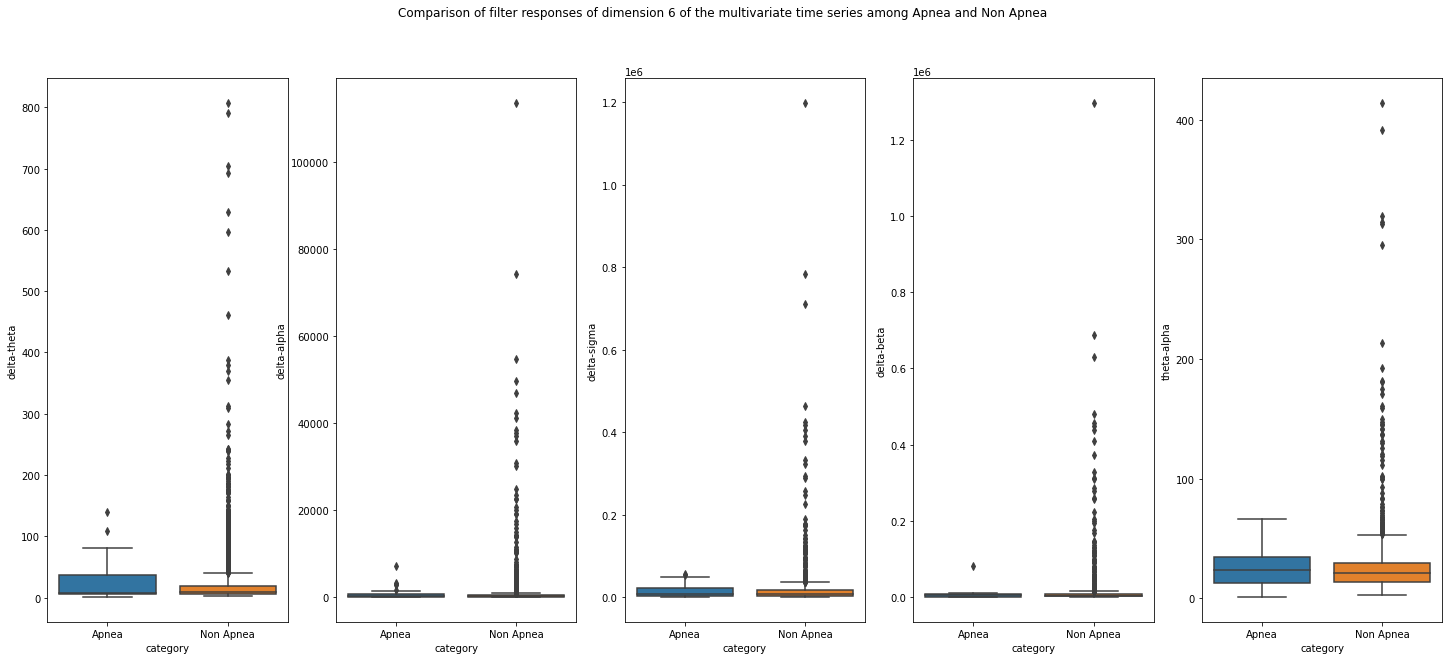

- - - - - - - - - - - - - - - PATIENT 9- - - - - - - - - - - - - - - 


<ipython-input-76-44aba9a8e99b>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-76-44aba9a8e99b>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


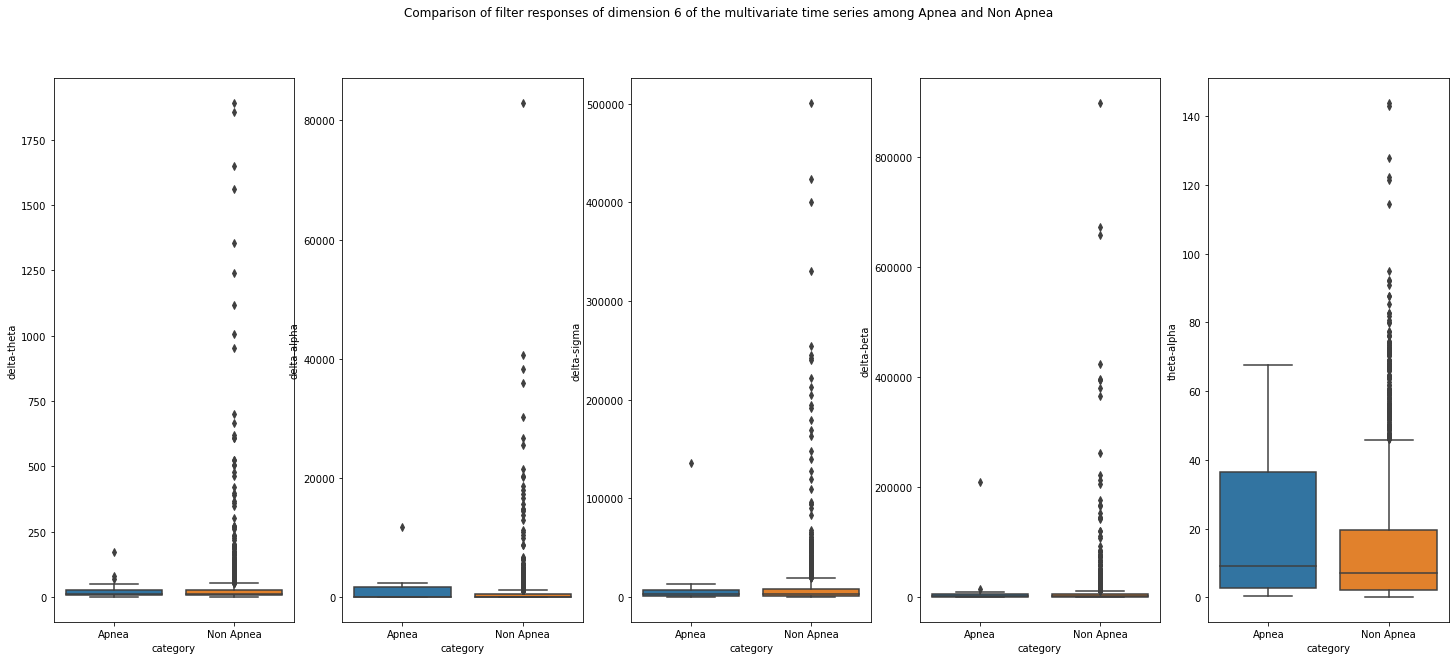

- - - - - - - - - - - - - - - PATIENT 10- - - - - - - - - - - - - - - 


<ipython-input-76-44aba9a8e99b>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-76-44aba9a8e99b>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


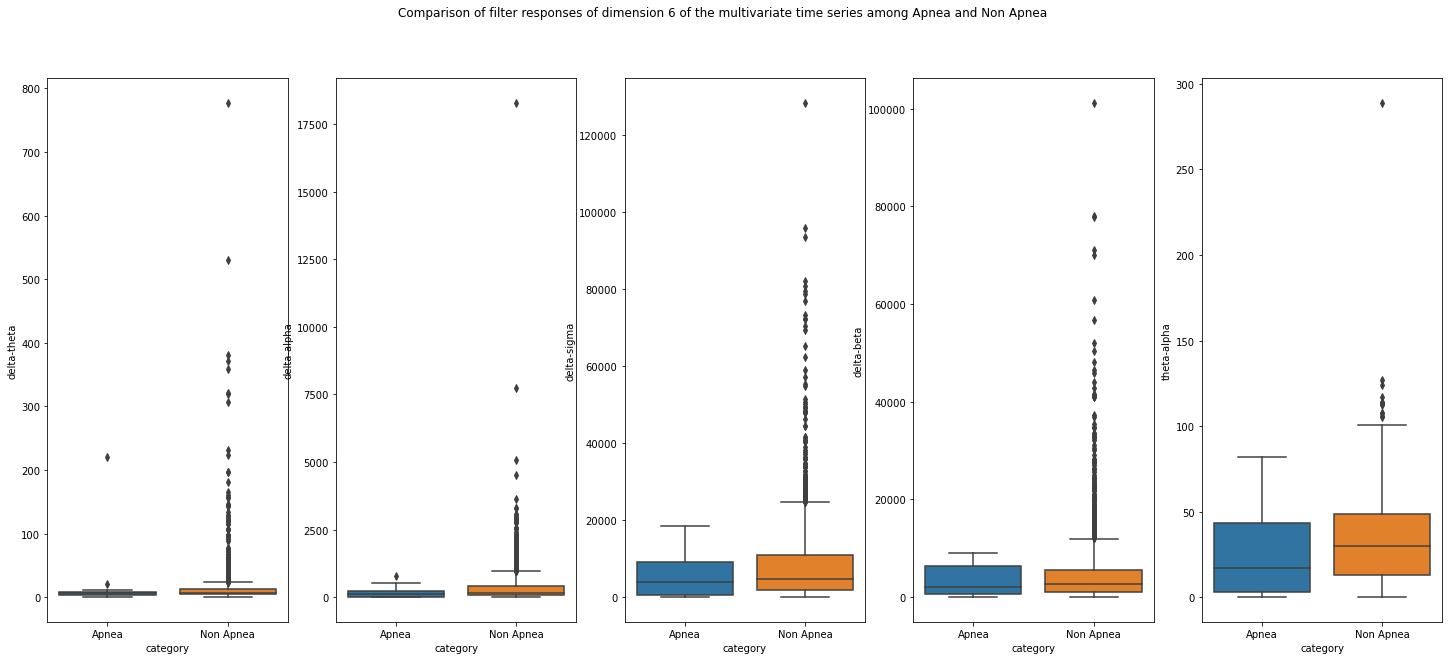

- - - - - - - - - - - - - - - PATIENT 11- - - - - - - - - - - - - - - 


<ipython-input-76-44aba9a8e99b>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-76-44aba9a8e99b>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


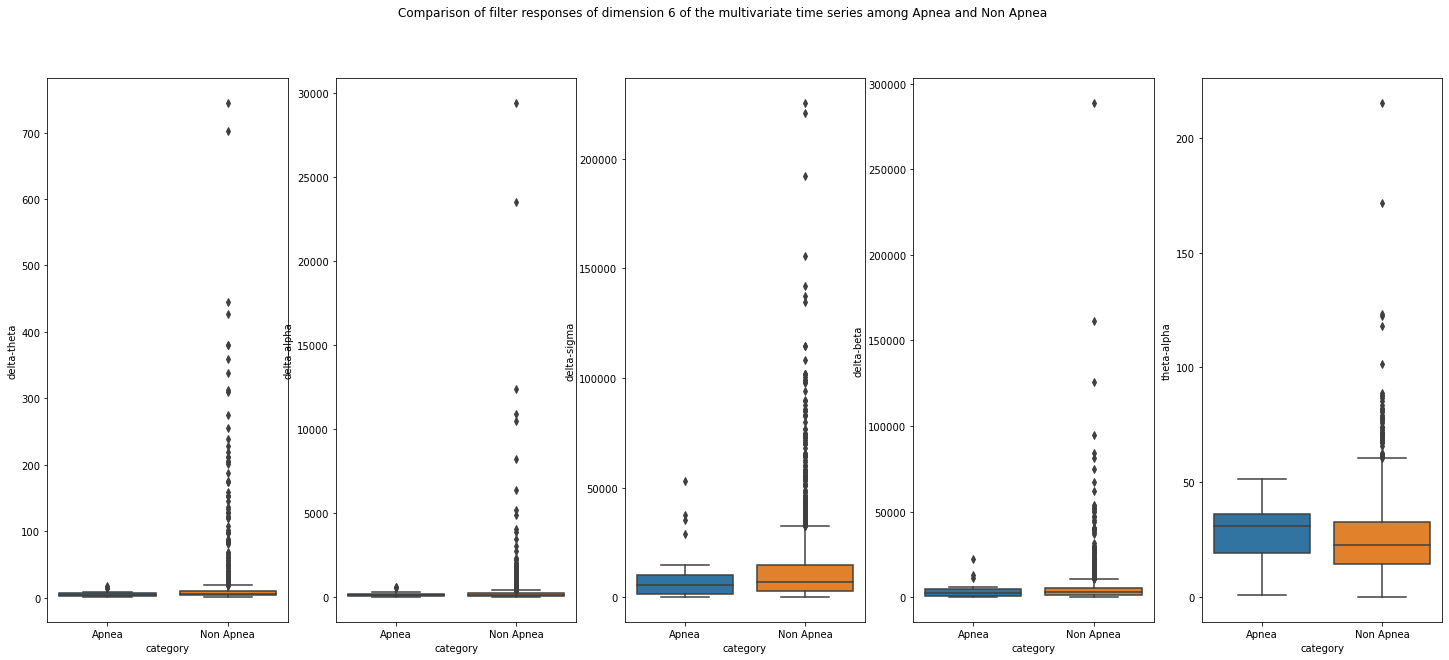

- - - - - - - - - - - - - - - PATIENT 12- - - - - - - - - - - - - - - 


<ipython-input-76-44aba9a8e99b>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-76-44aba9a8e99b>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


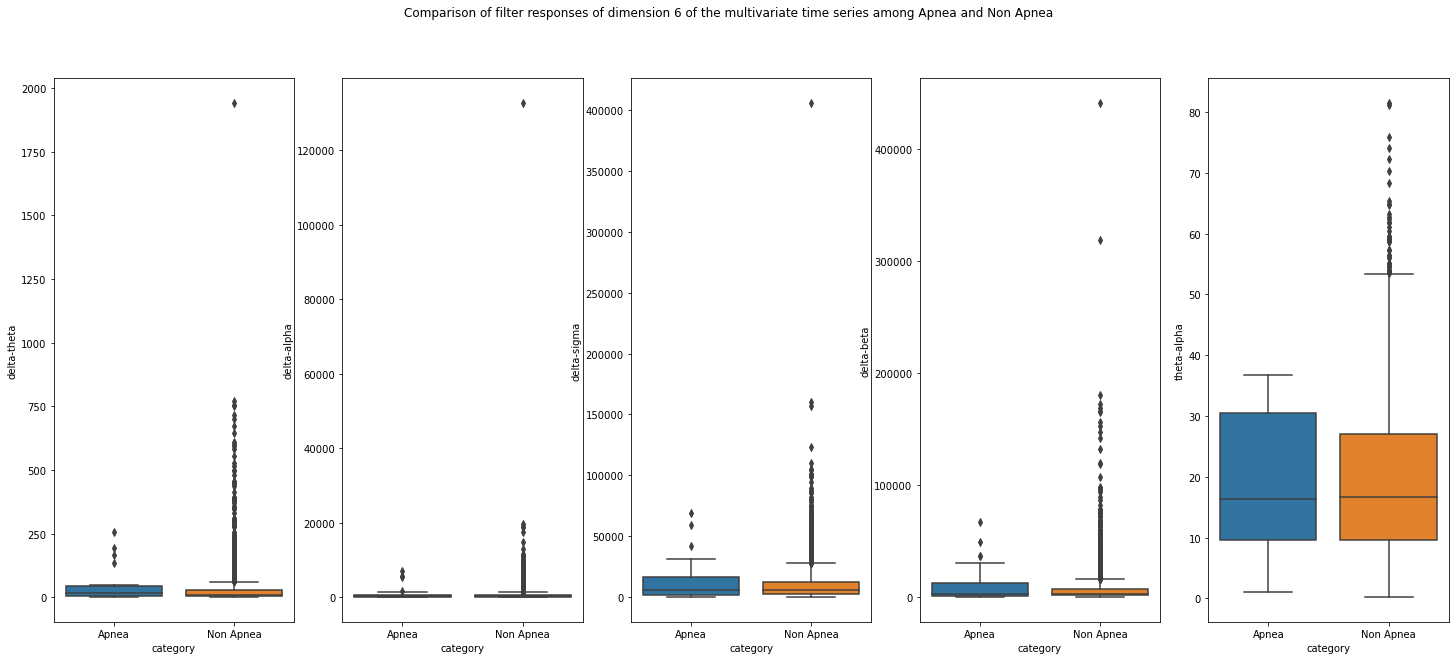

- - - - - - - - - - - - - - - PATIENT 13- - - - - - - - - - - - - - - 


<ipython-input-76-44aba9a8e99b>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-76-44aba9a8e99b>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


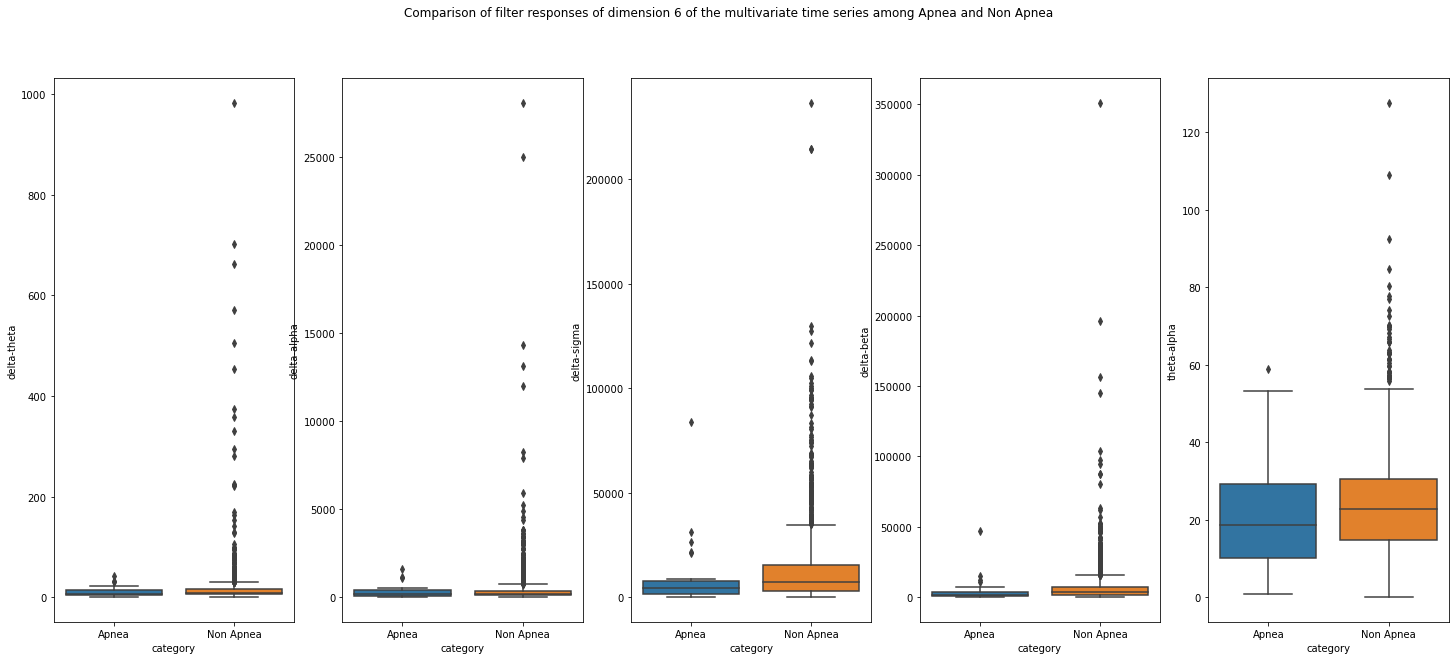

- - - - - - - - - - - - - - - PATIENT 14- - - - - - - - - - - - - - - 


<ipython-input-76-44aba9a8e99b>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-76-44aba9a8e99b>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


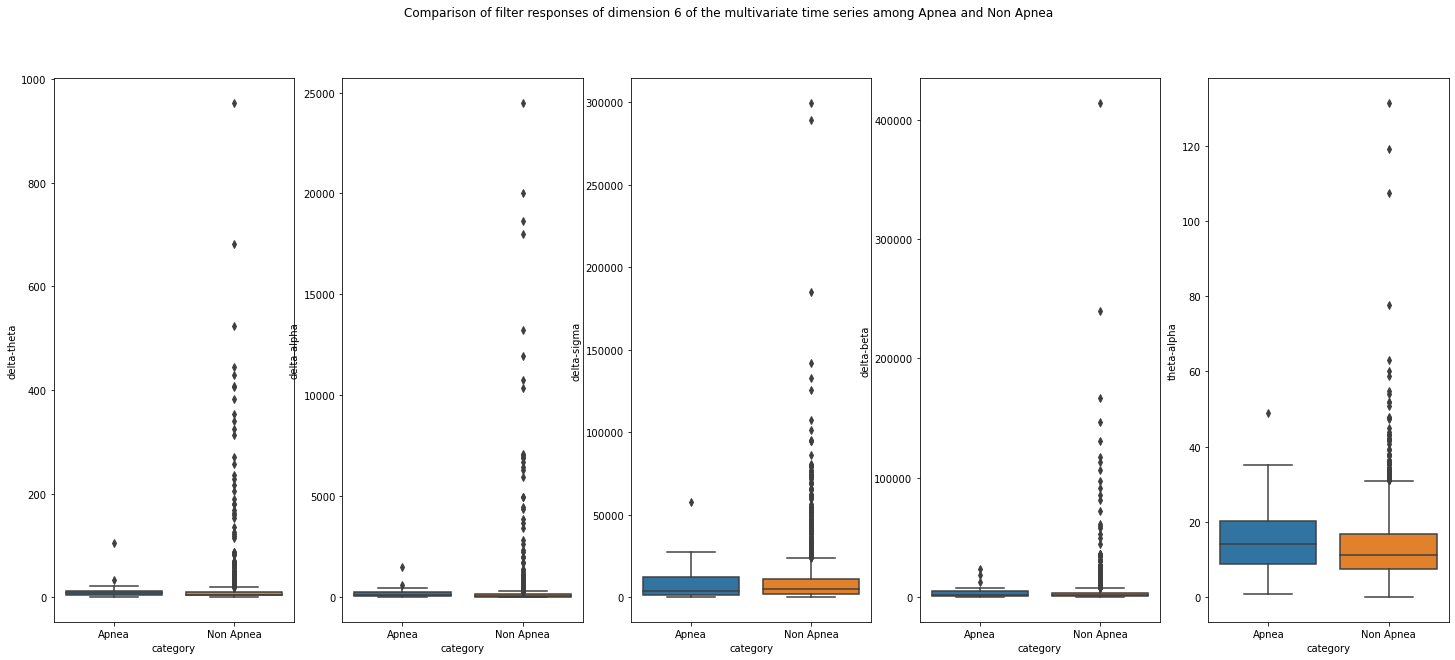

- - - - - - - - - - - - - - - PATIENT 15- - - - - - - - - - - - - - - 


<ipython-input-76-44aba9a8e99b>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-76-44aba9a8e99b>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


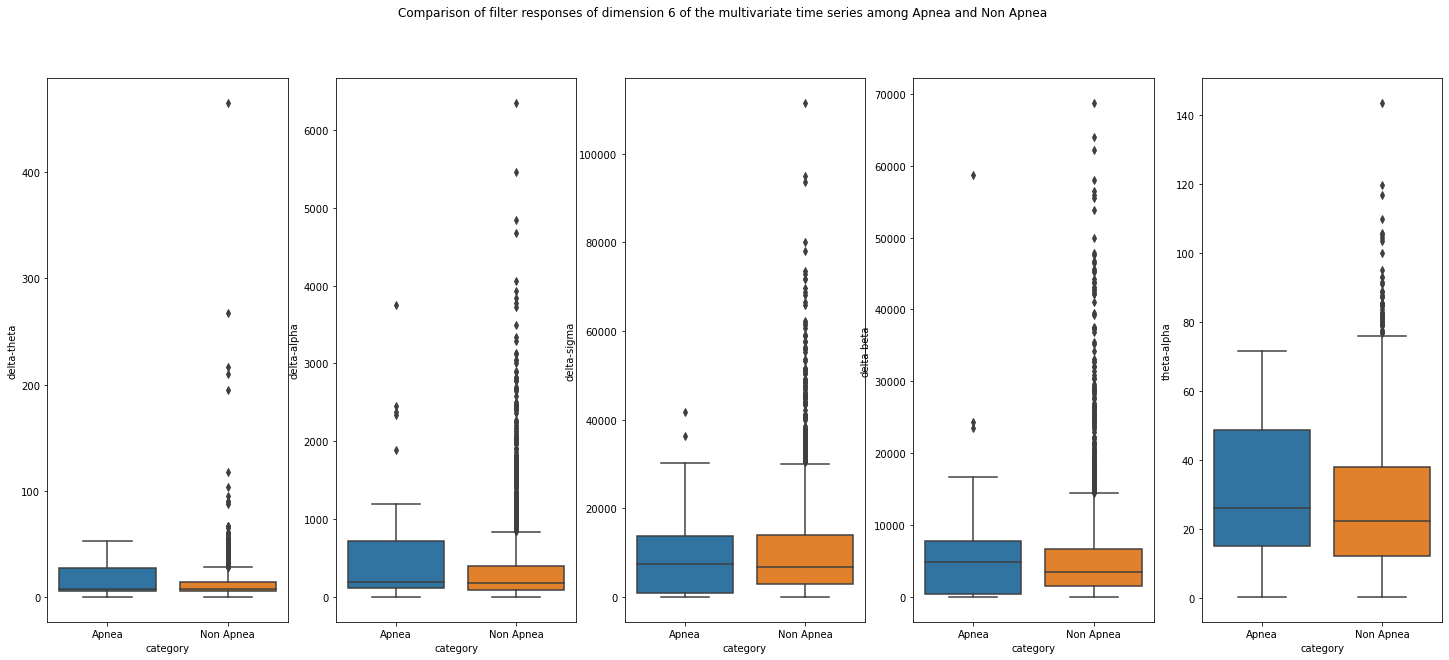

- - - - - - - - - - - - - - - PATIENT 16- - - - - - - - - - - - - - - 


<ipython-input-76-44aba9a8e99b>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-76-44aba9a8e99b>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


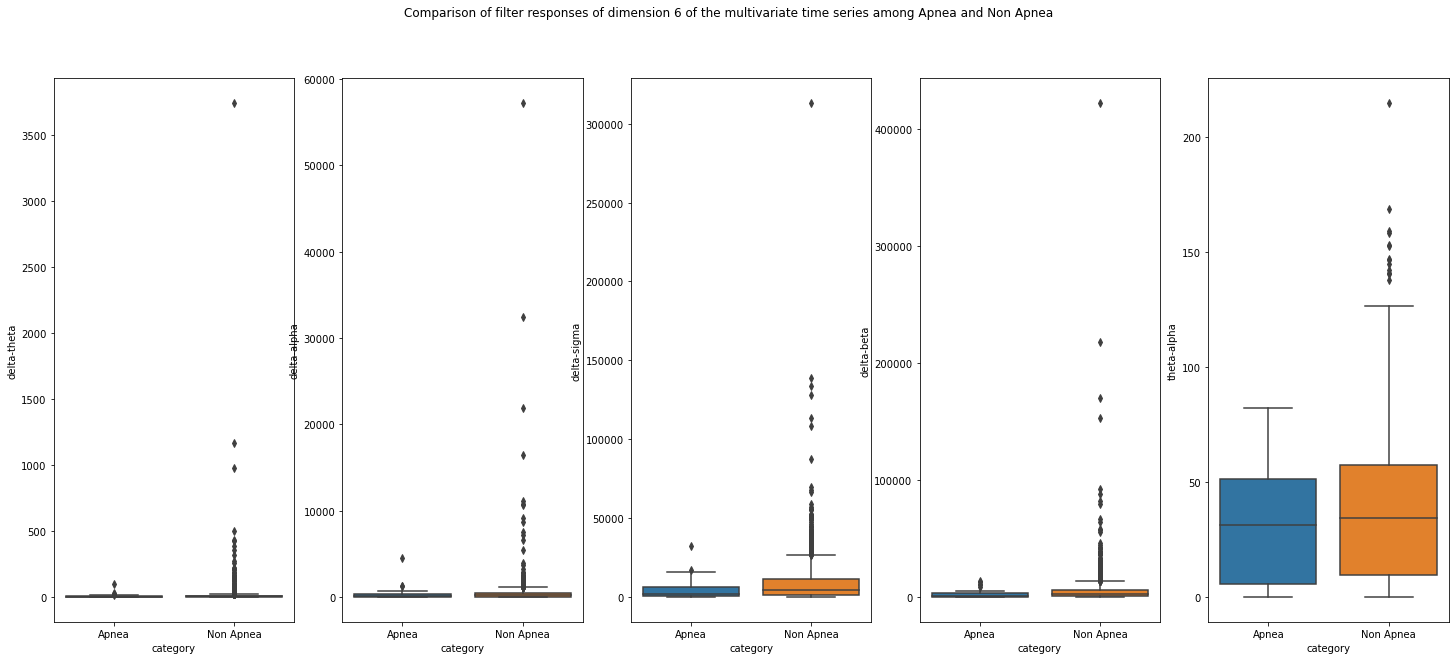

- - - - - - - - - - - - - - - PATIENT 17- - - - - - - - - - - - - - - 


<ipython-input-76-44aba9a8e99b>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-76-44aba9a8e99b>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


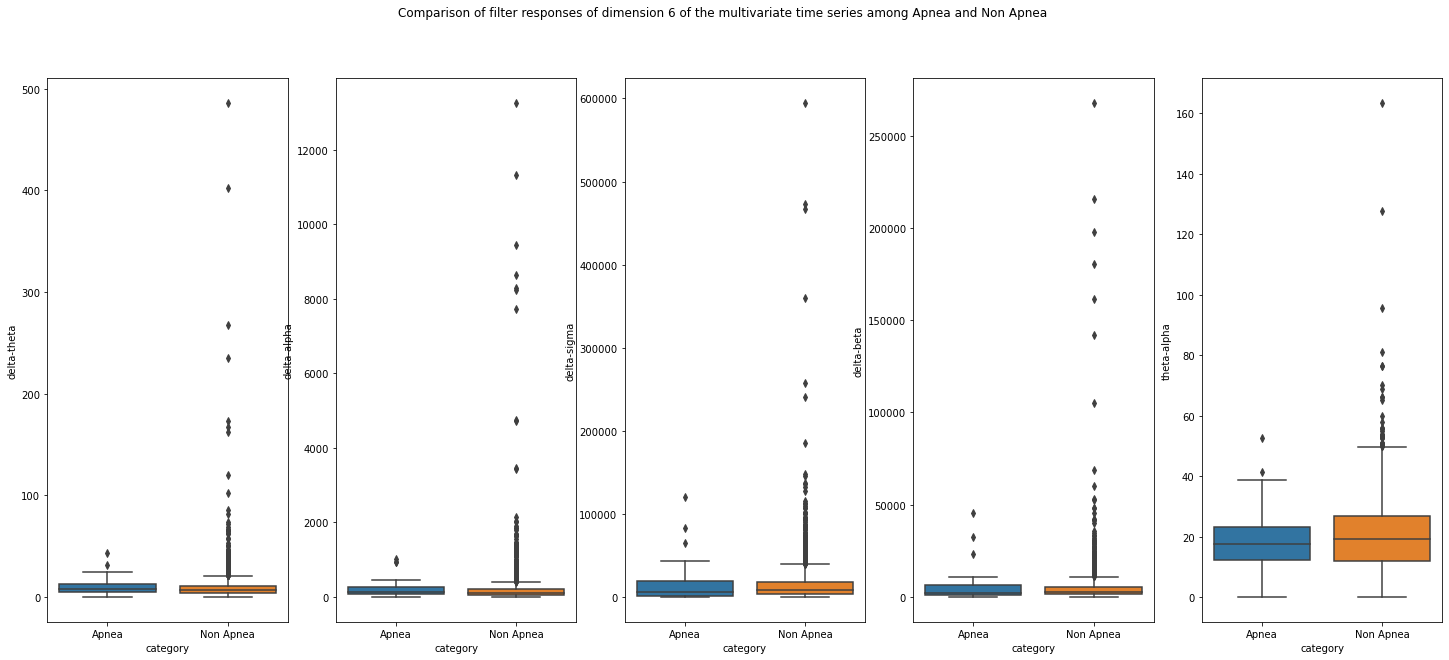

- - - - - - - - - - - - - - - PATIENT 18- - - - - - - - - - - - - - - 


<ipython-input-76-44aba9a8e99b>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-76-44aba9a8e99b>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


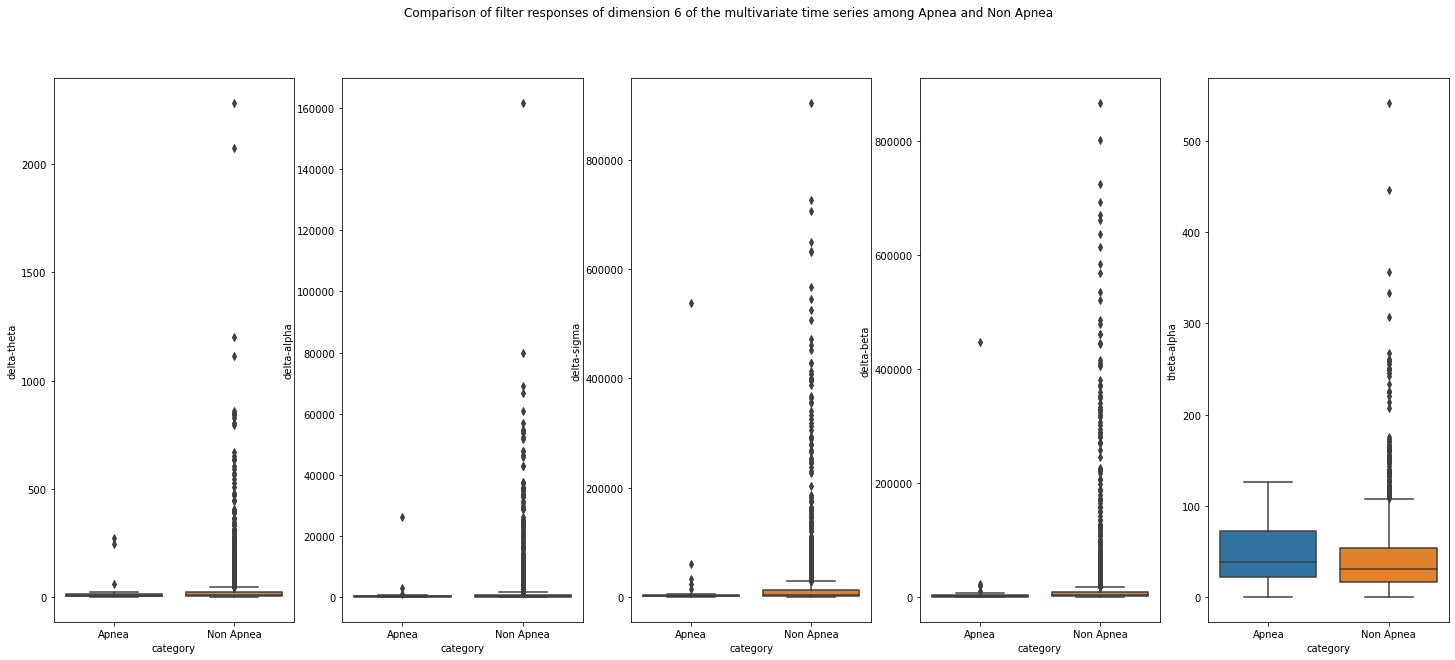

- - - - - - - - - - - - - - - PATIENT 19- - - - - - - - - - - - - - - 


<ipython-input-76-44aba9a8e99b>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-76-44aba9a8e99b>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


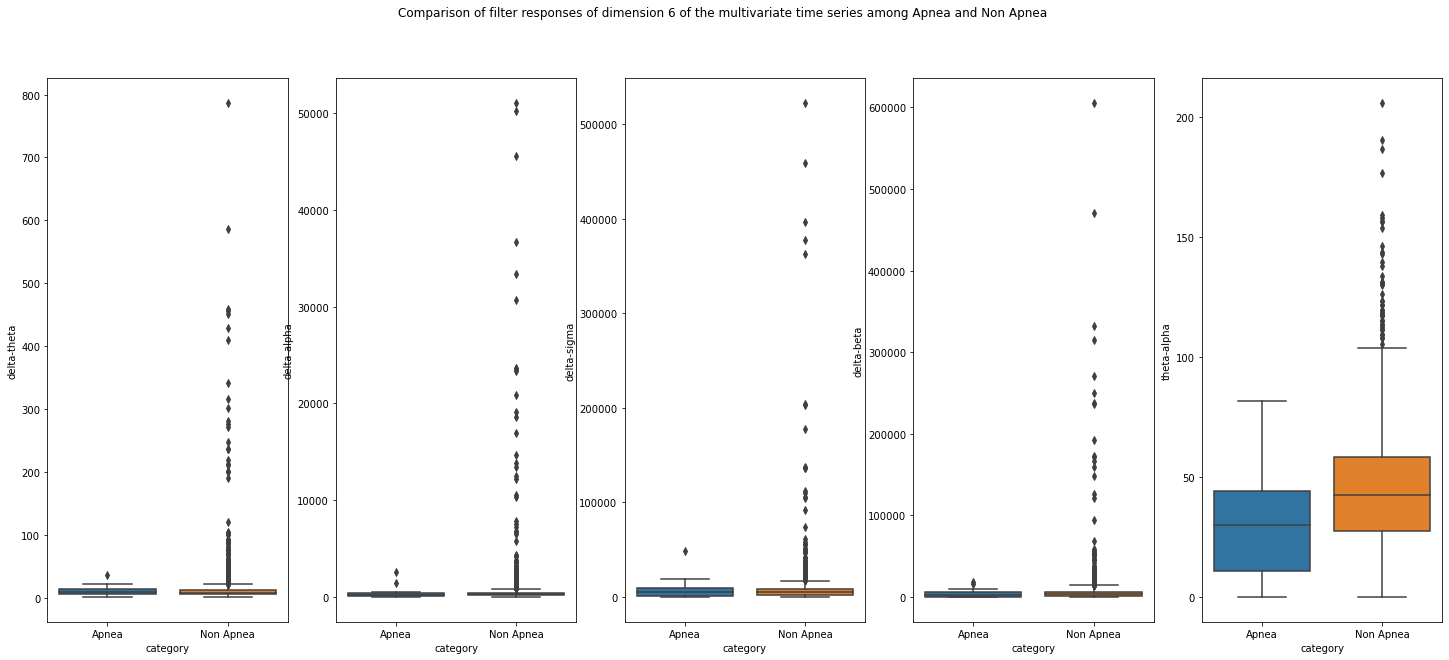

- - - - - - - - - - - - - - - PATIENT 20- - - - - - - - - - - - - - - 


<ipython-input-76-44aba9a8e99b>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-76-44aba9a8e99b>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


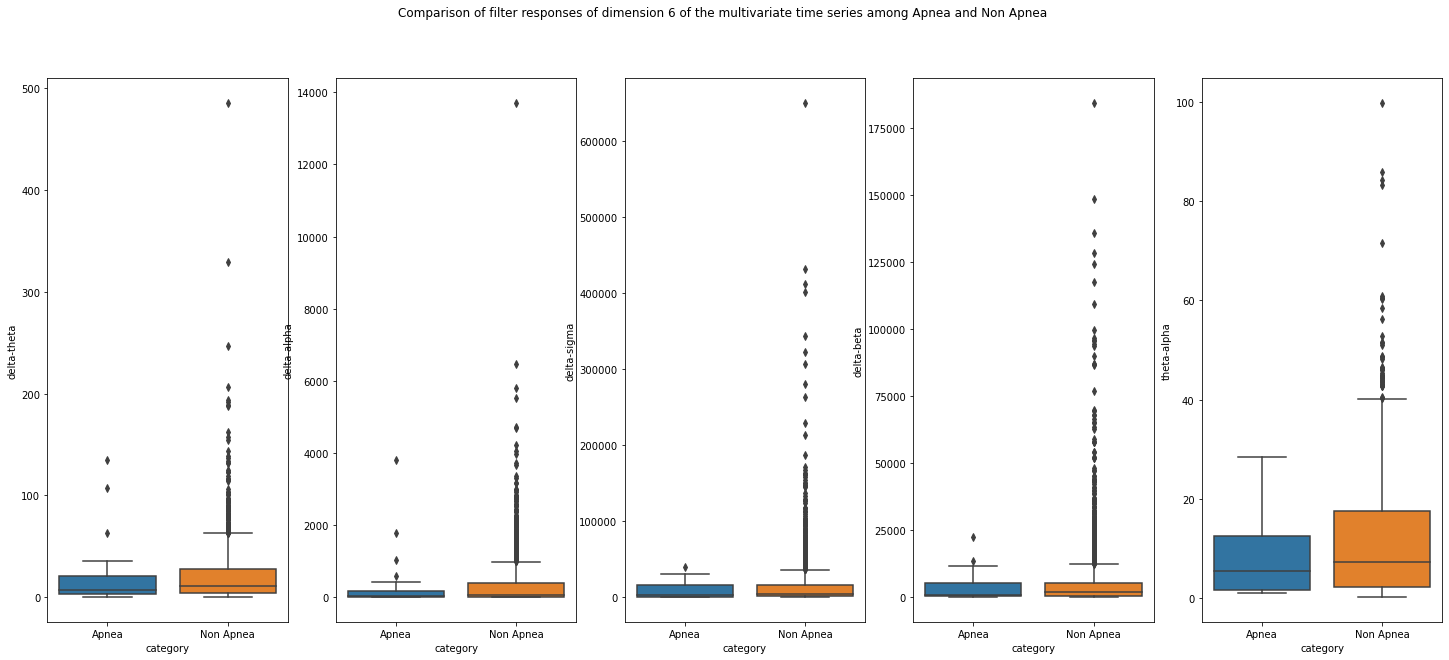

- - - - - - - - - - - - - - - PATIENT 21- - - - - - - - - - - - - - - 


<ipython-input-76-44aba9a8e99b>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-76-44aba9a8e99b>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


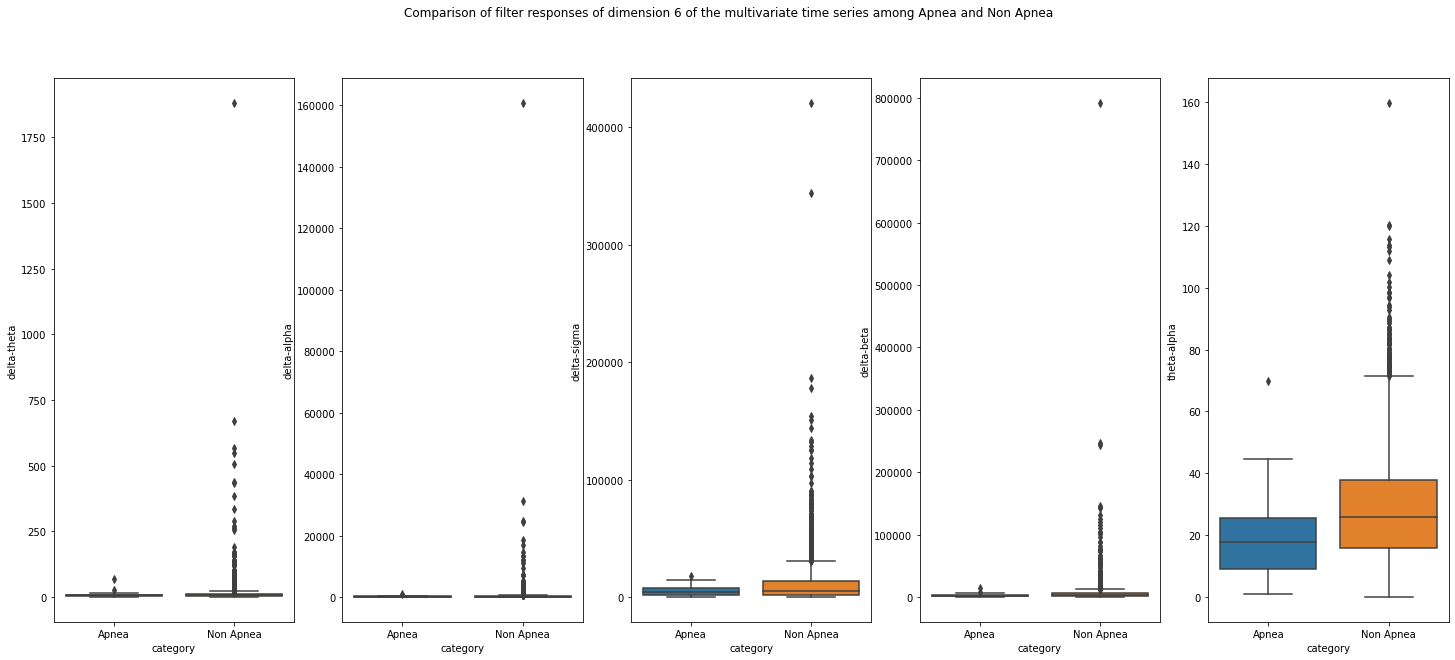

In [77]:
## for each patient individually now (it is said to be subject-specific criterion between A and NA in the paper)
## https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6595536/?fbclid=IwAR1UsmNTauyQKvl1QmunZjow9sSk-SGDrDMt00KyWhhNAkuXnAXkXJc7WRI


for i in range(22):
    print(15*"- " + 'PATIENT '+str(i) + 15*"- " )
    features_boxplots(X_EEG2[i*200:(i+1)*200,:], 6, outliers_boolean=True)

- - - - - - - - - - - - - - - PATIENT 0- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


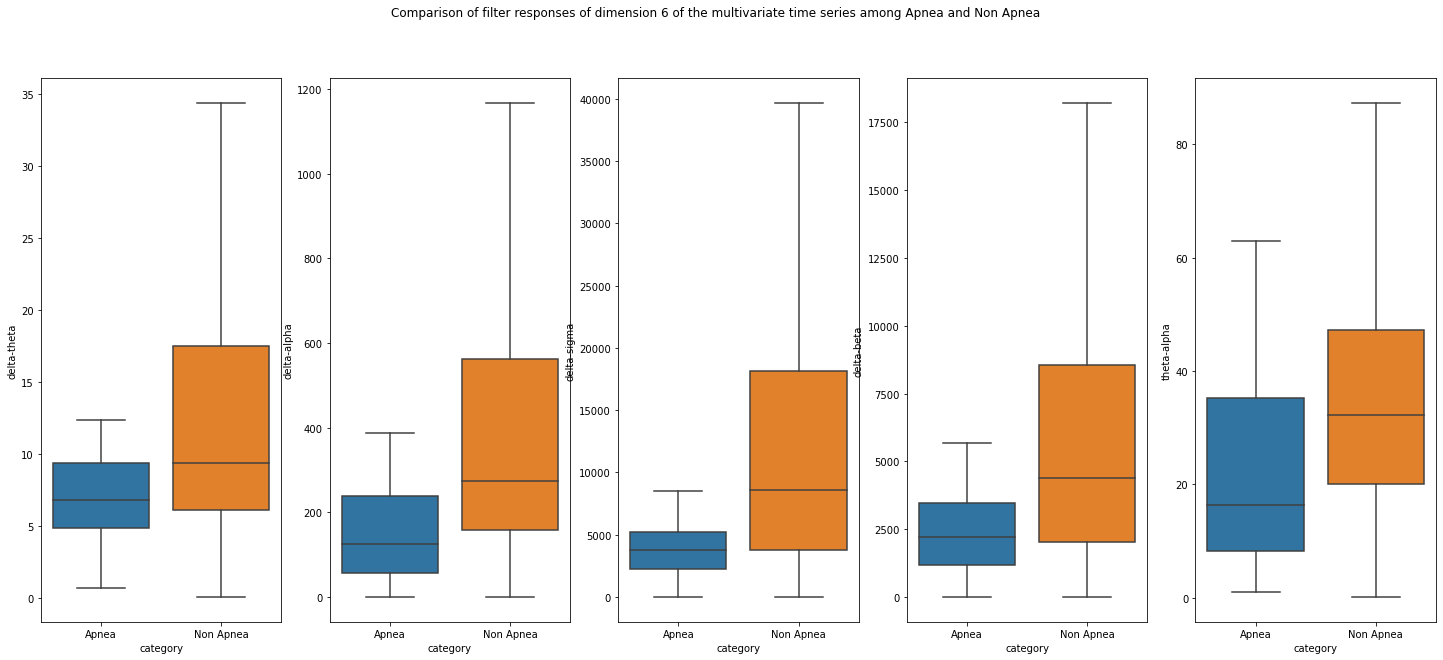

- - - - - - - - - - - - - - - PATIENT 1- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


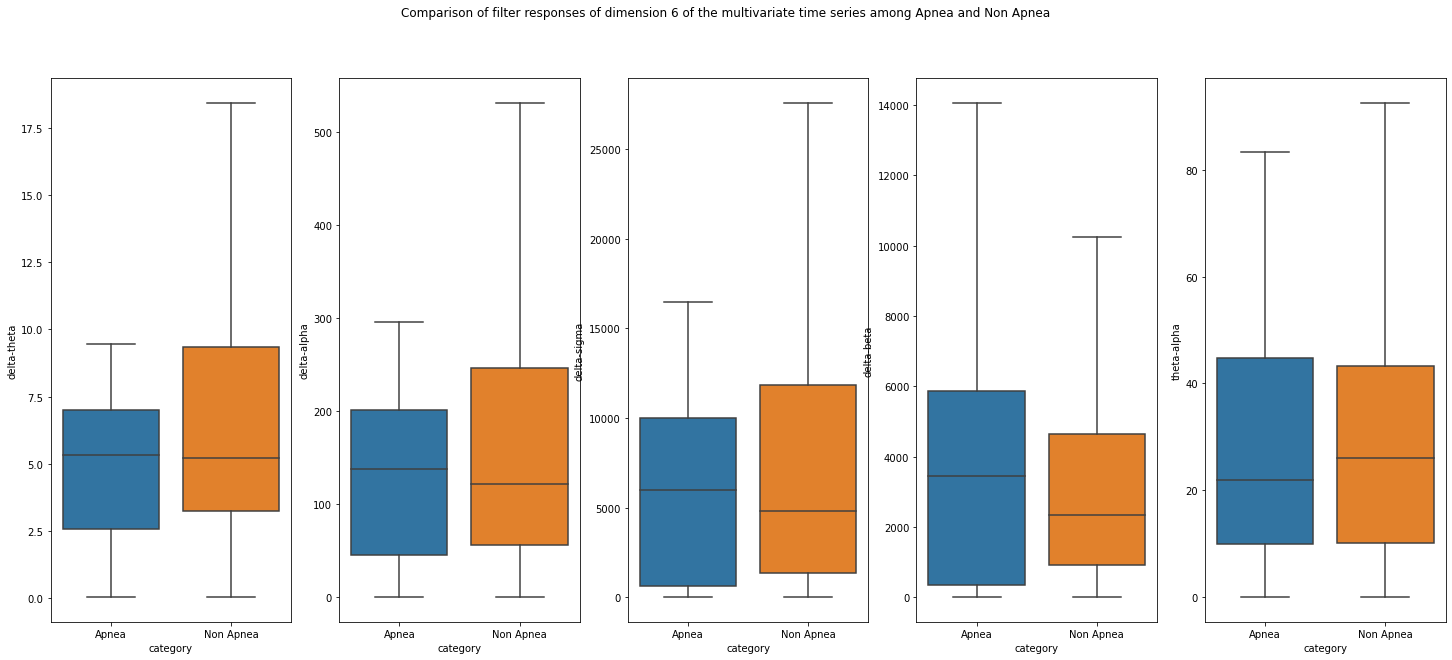

- - - - - - - - - - - - - - - PATIENT 2- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


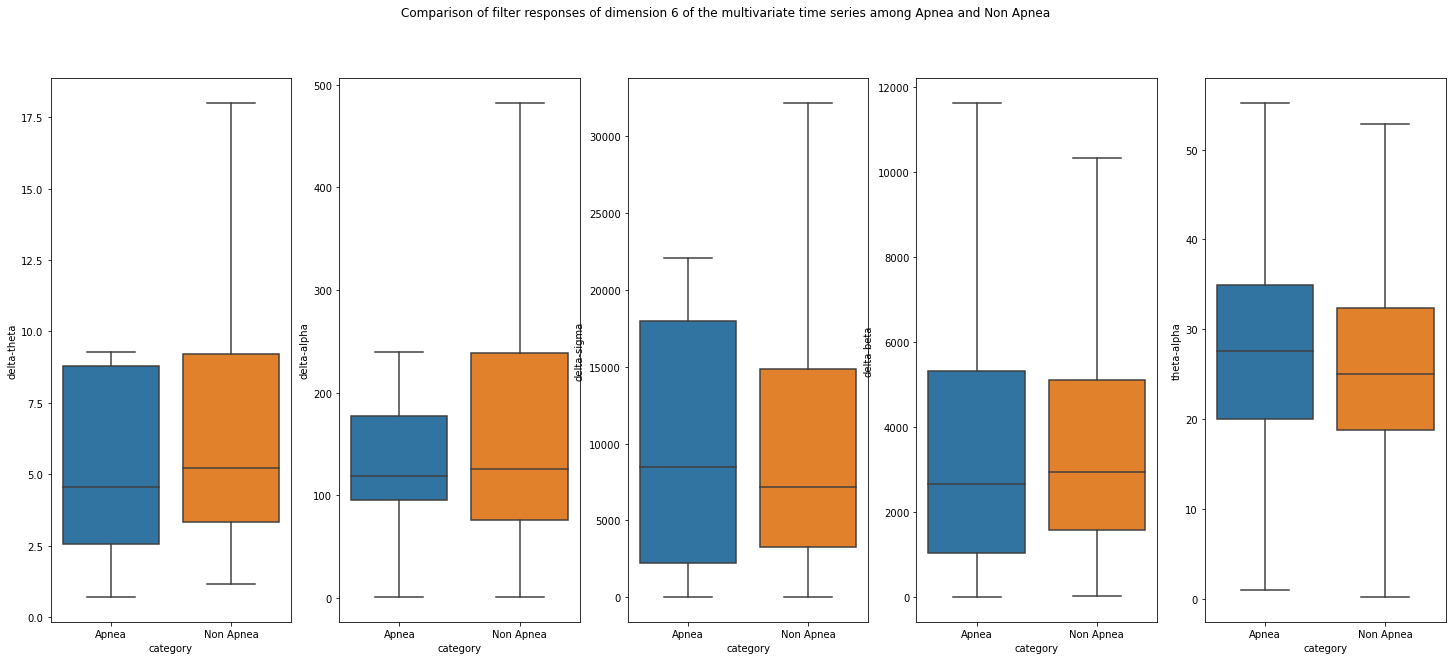

- - - - - - - - - - - - - - - PATIENT 3- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


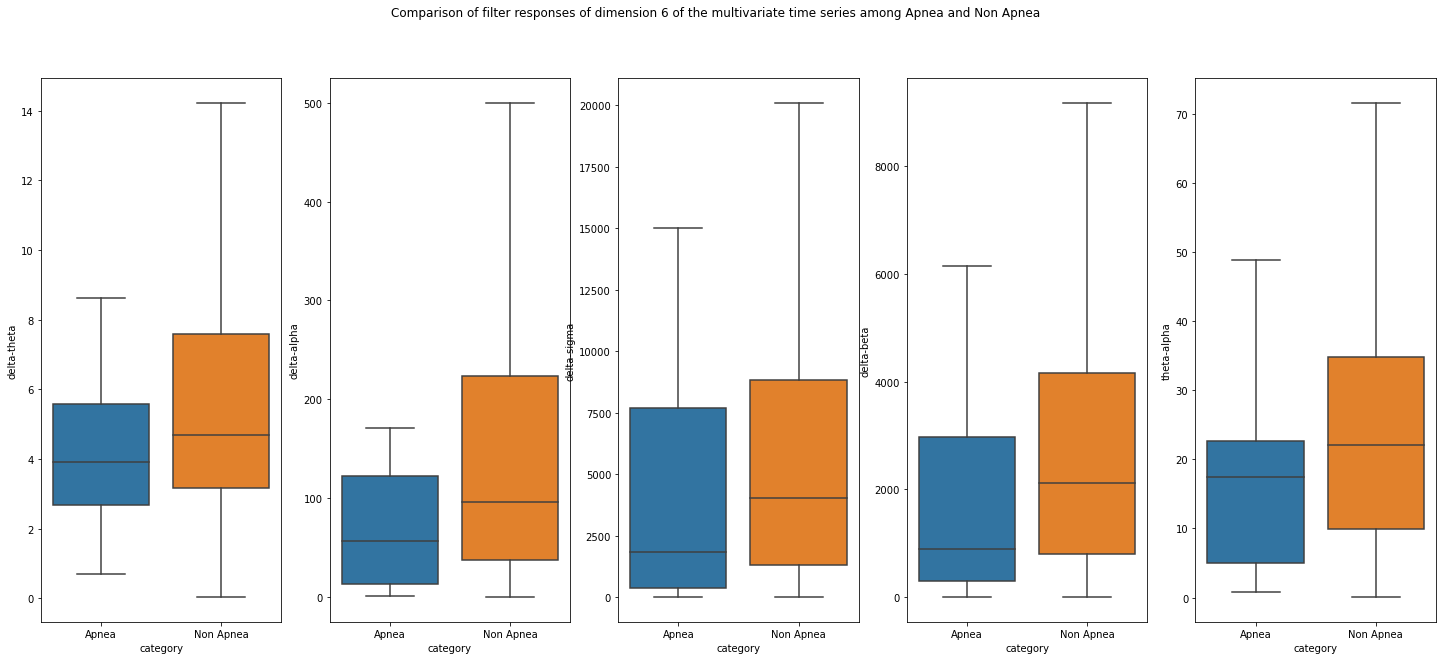

- - - - - - - - - - - - - - - PATIENT 4- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


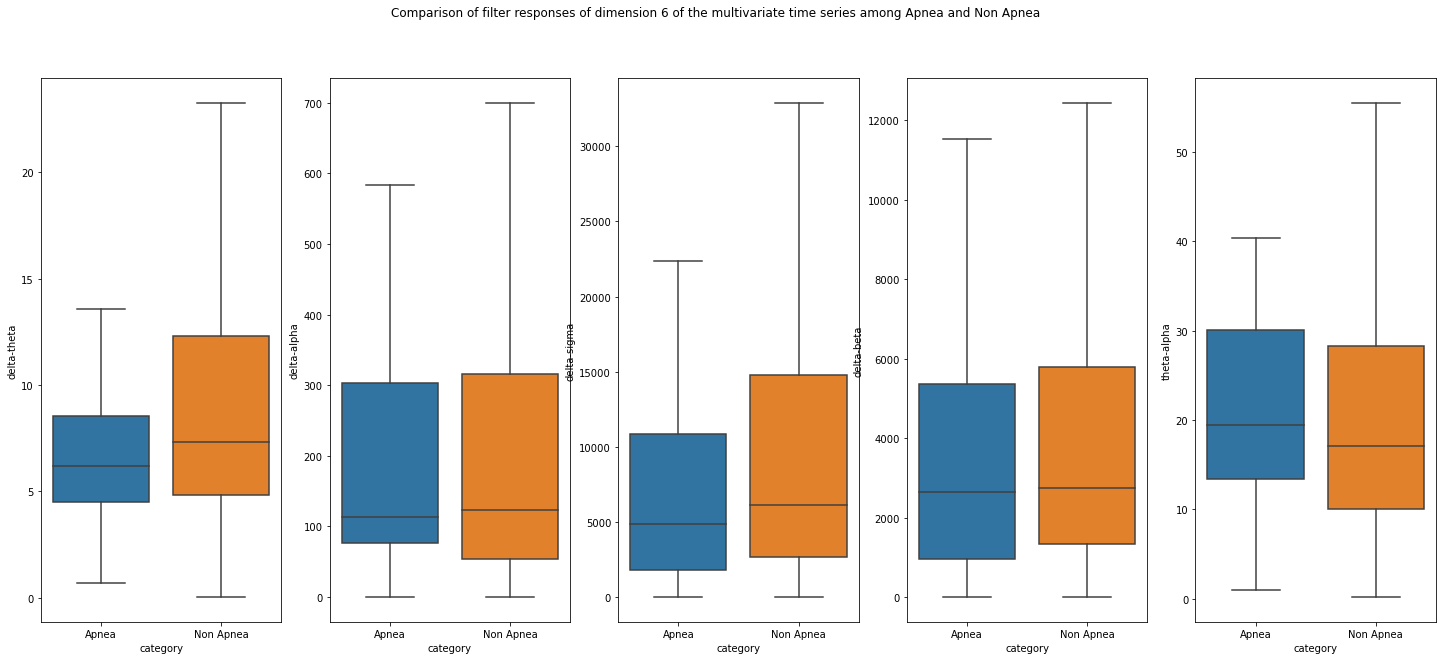

- - - - - - - - - - - - - - - PATIENT 5- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


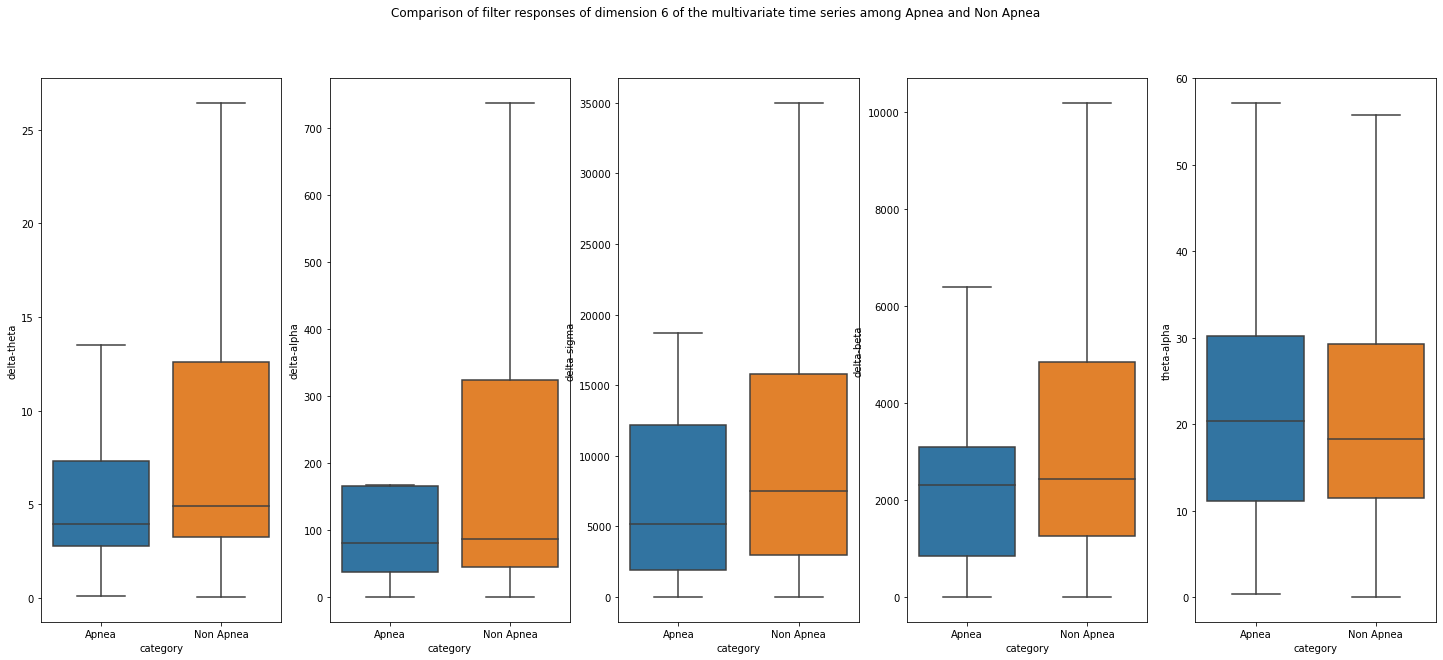

- - - - - - - - - - - - - - - PATIENT 6- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


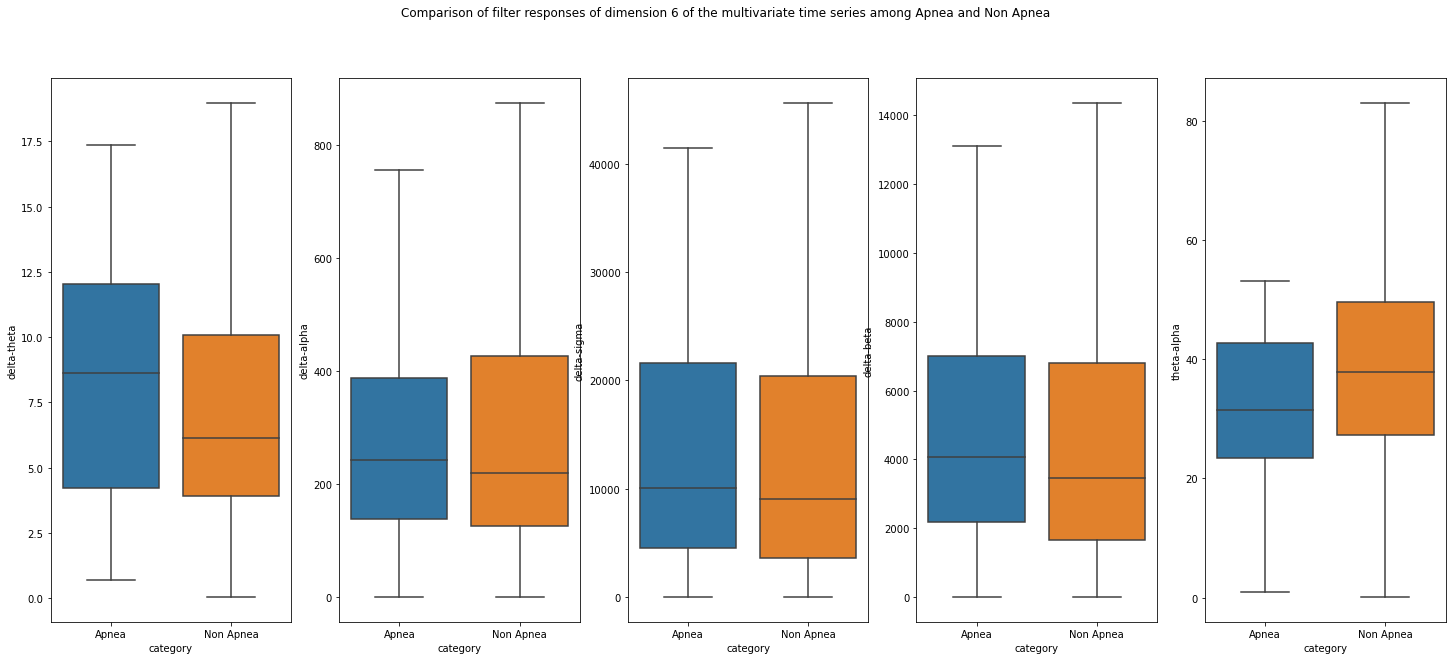

- - - - - - - - - - - - - - - PATIENT 7- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


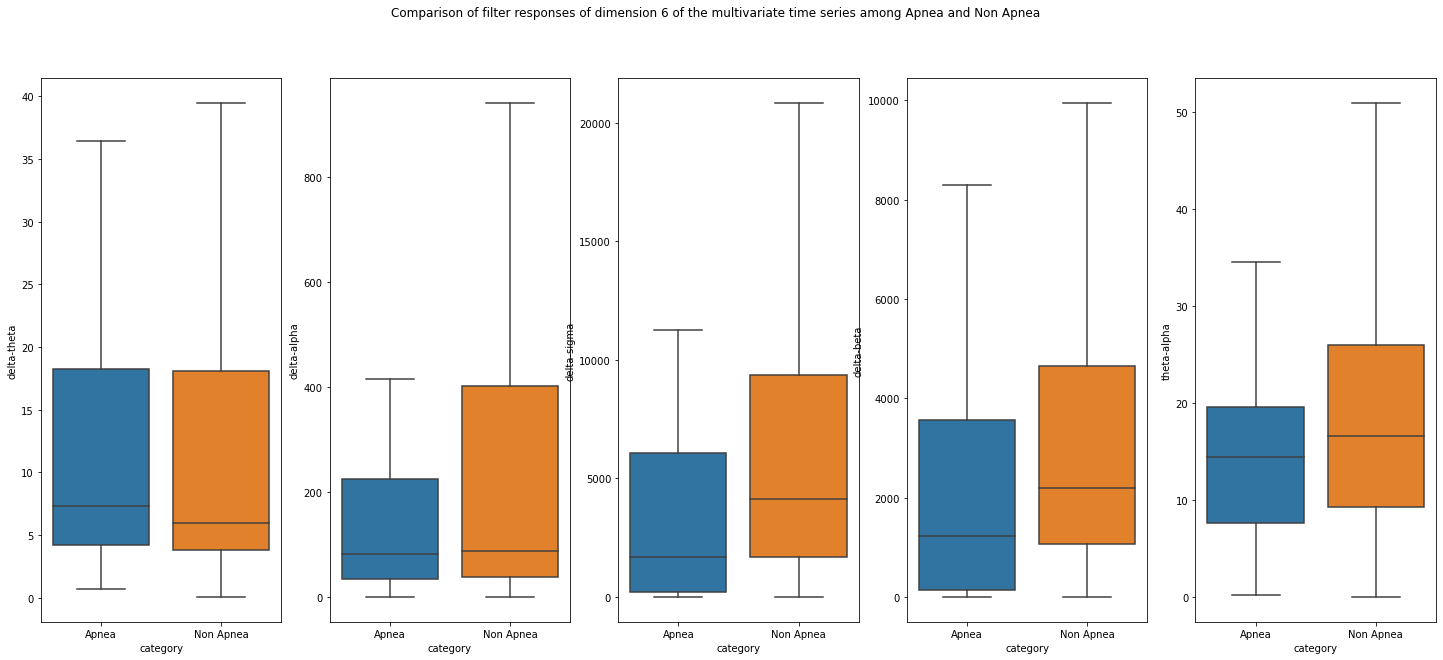

- - - - - - - - - - - - - - - PATIENT 8- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


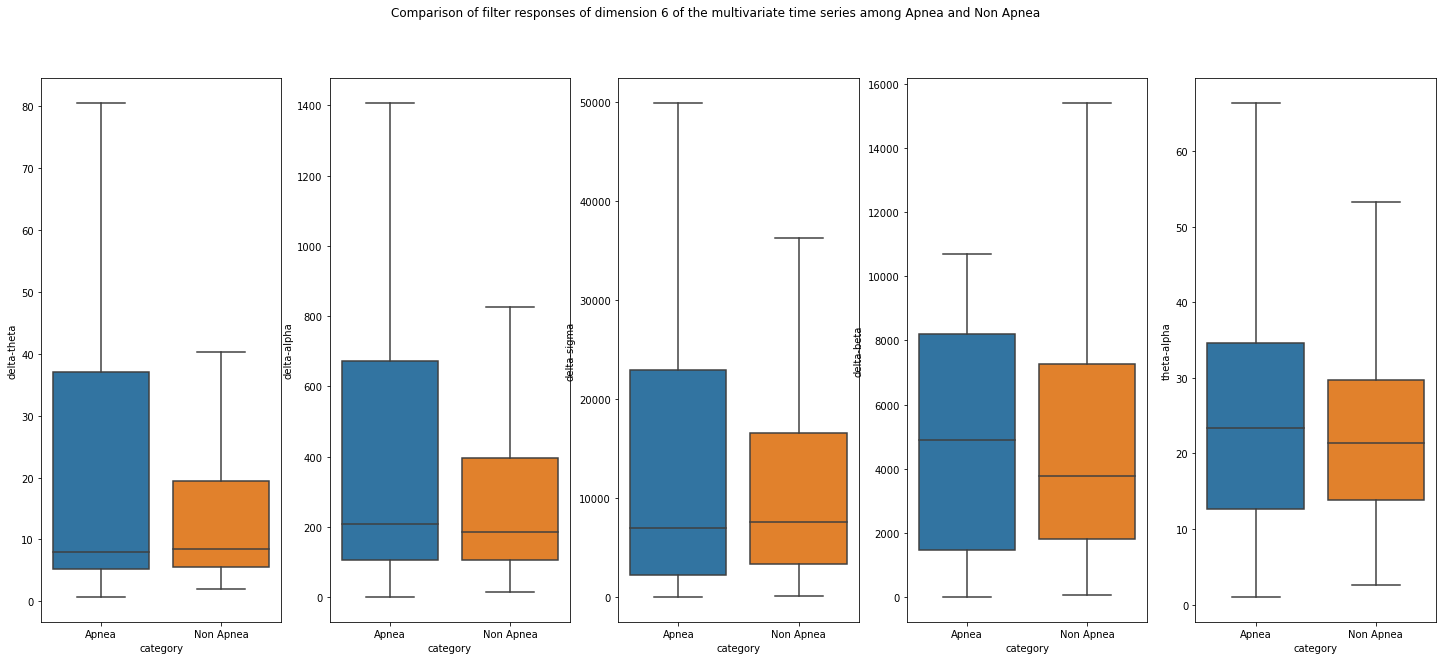

- - - - - - - - - - - - - - - PATIENT 9- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


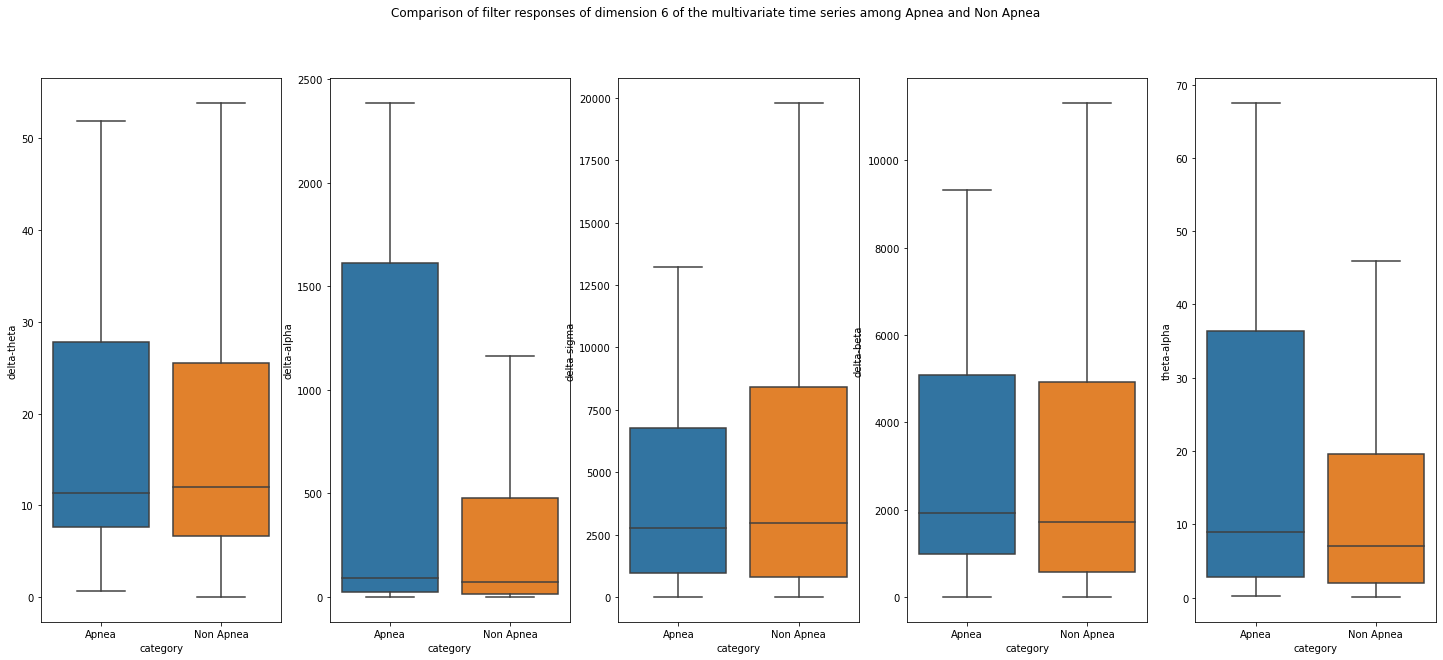

- - - - - - - - - - - - - - - PATIENT 10- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


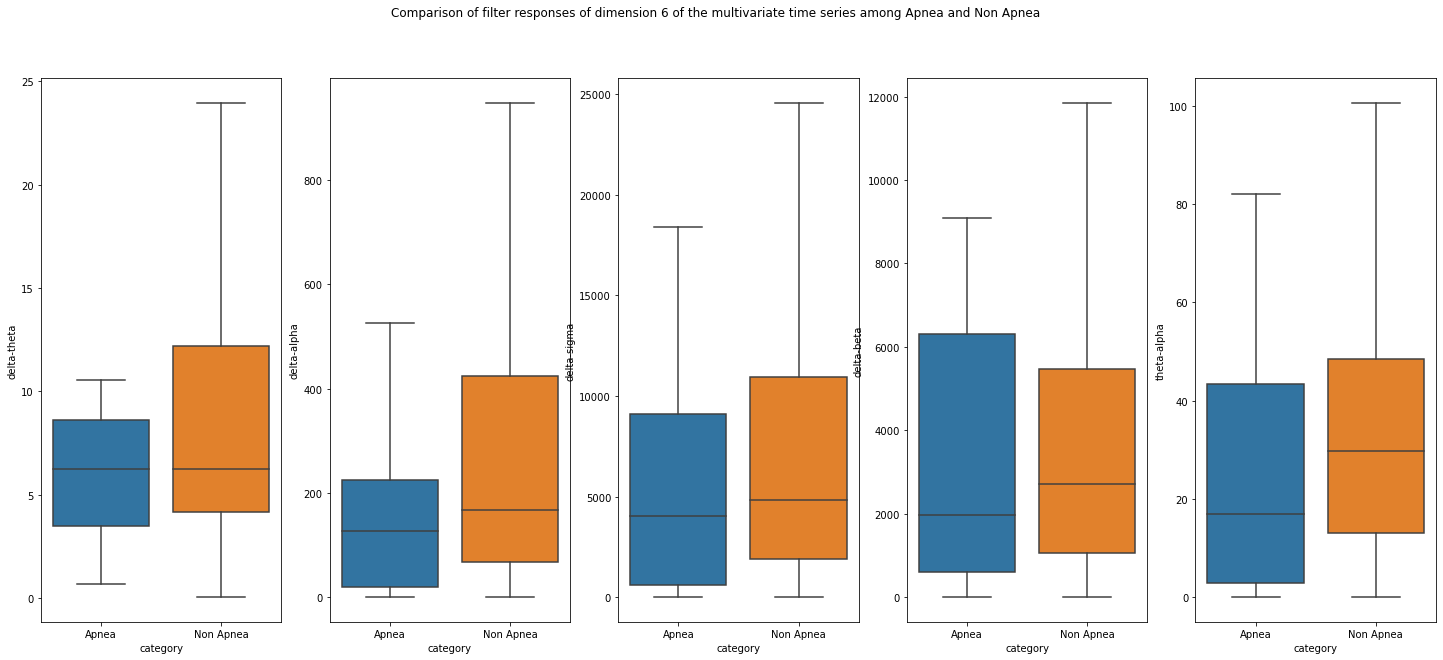

- - - - - - - - - - - - - - - PATIENT 11- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


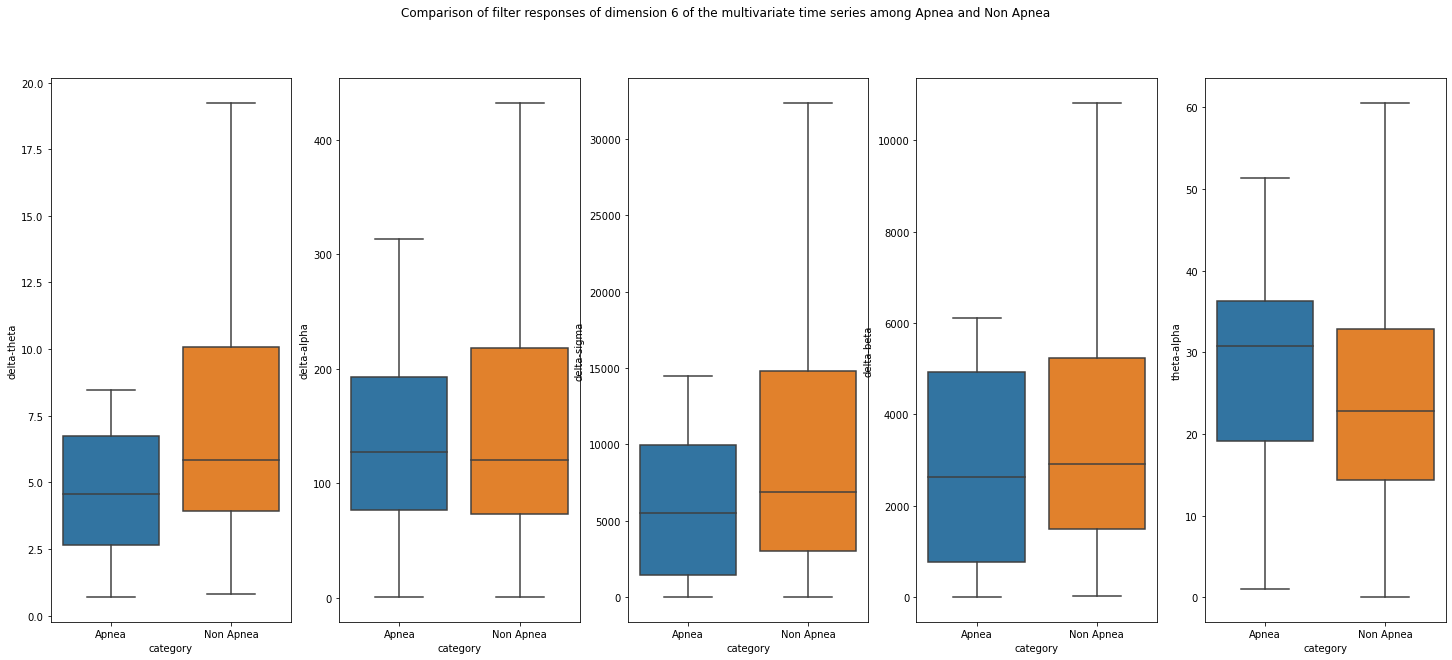

- - - - - - - - - - - - - - - PATIENT 12- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


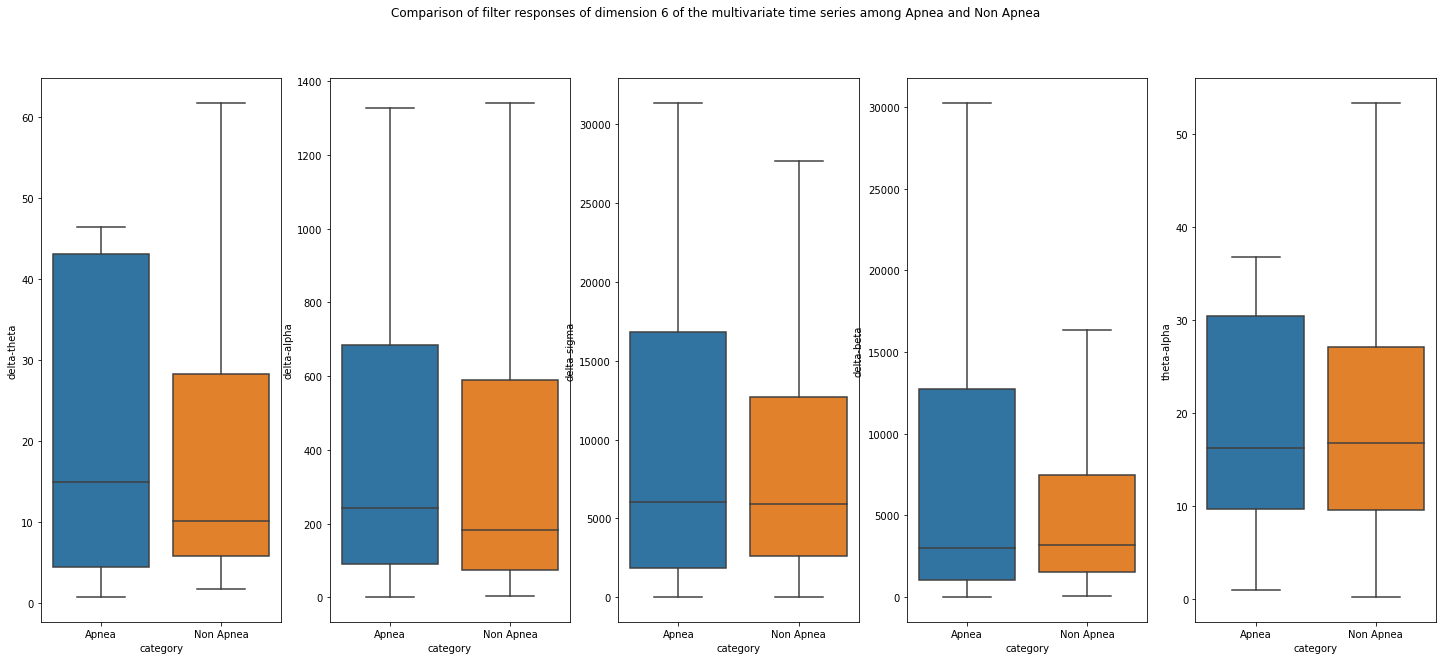

- - - - - - - - - - - - - - - PATIENT 13- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


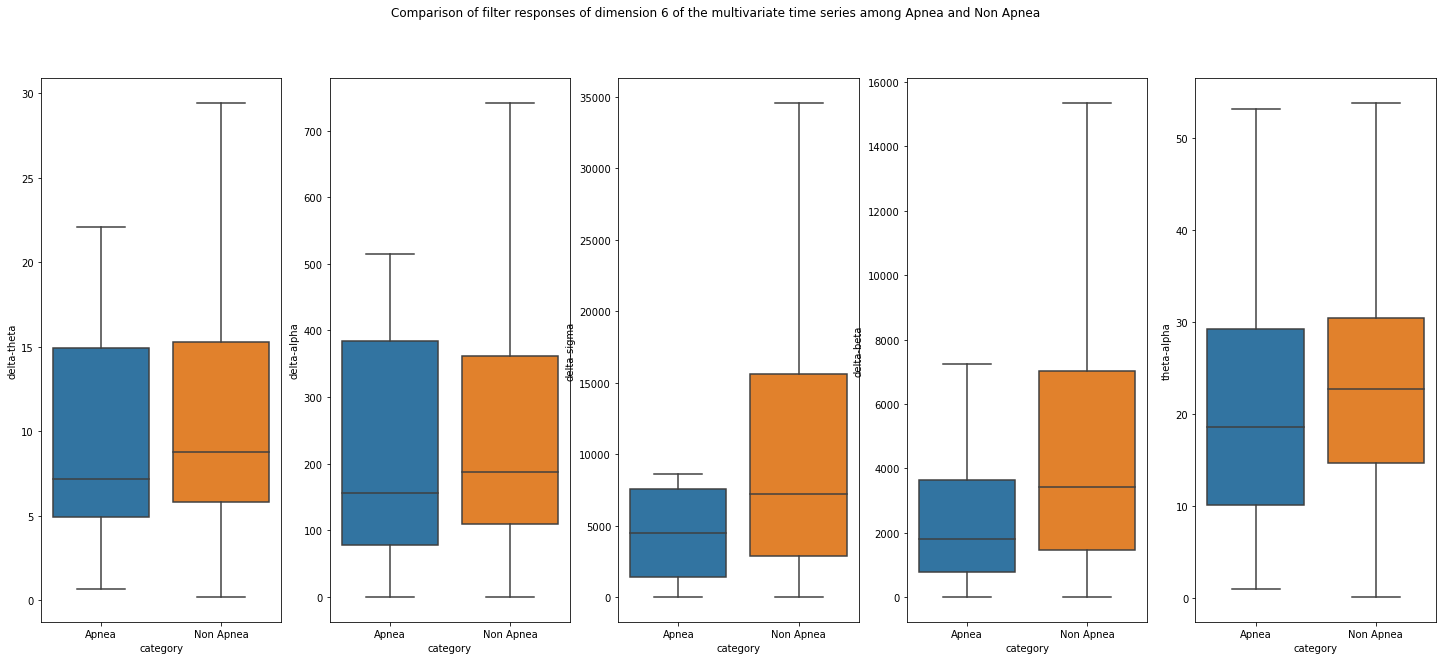

- - - - - - - - - - - - - - - PATIENT 14- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


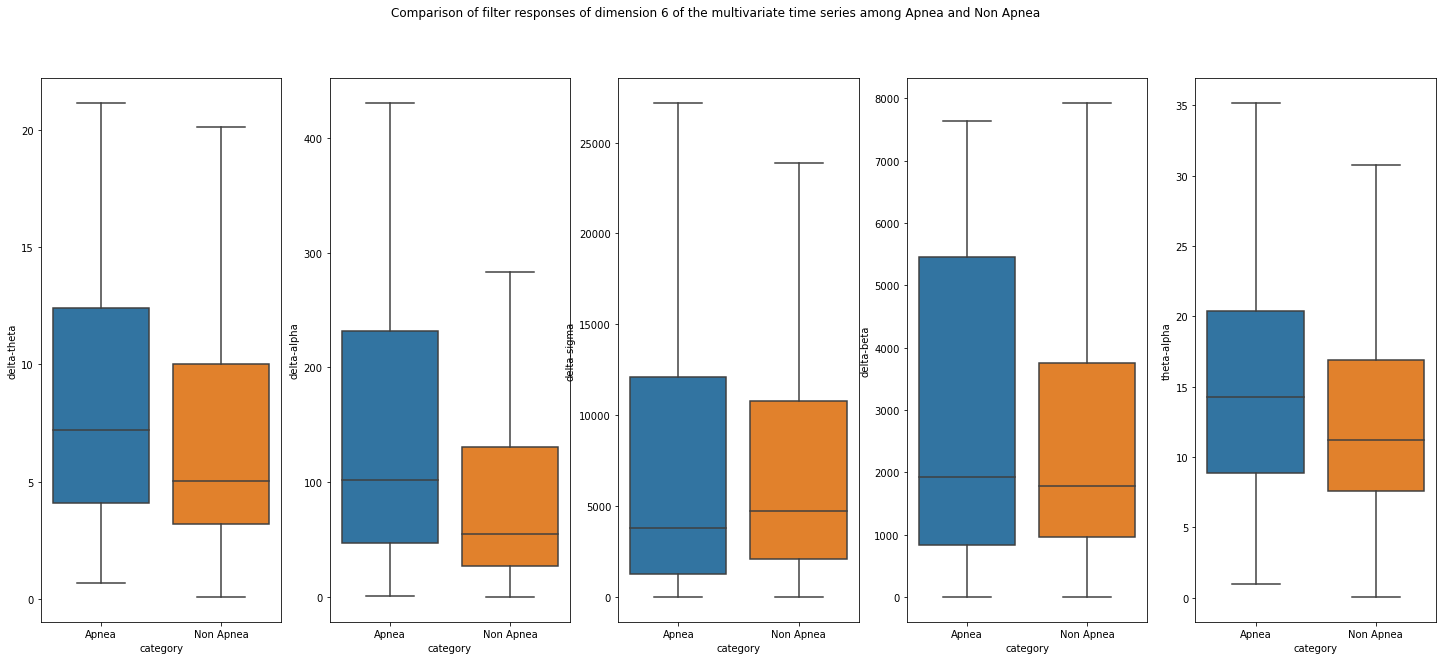

- - - - - - - - - - - - - - - PATIENT 15- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


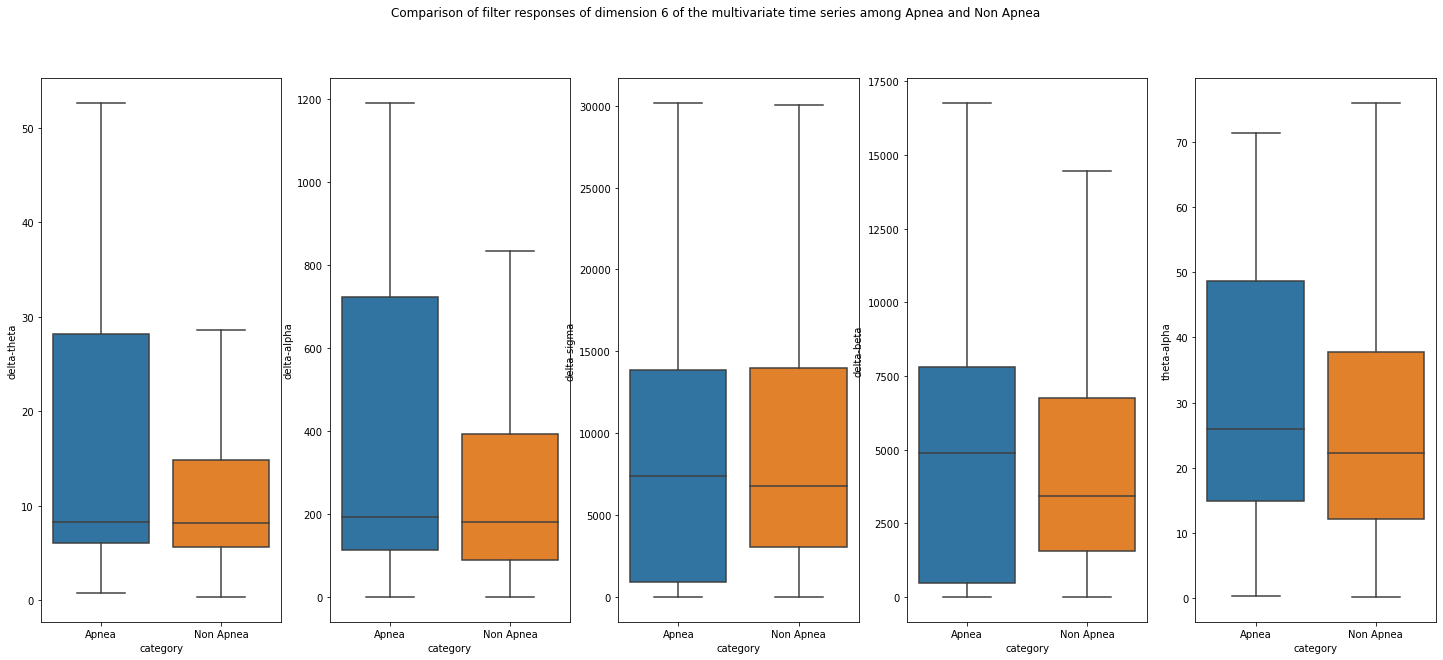

- - - - - - - - - - - - - - - PATIENT 16- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


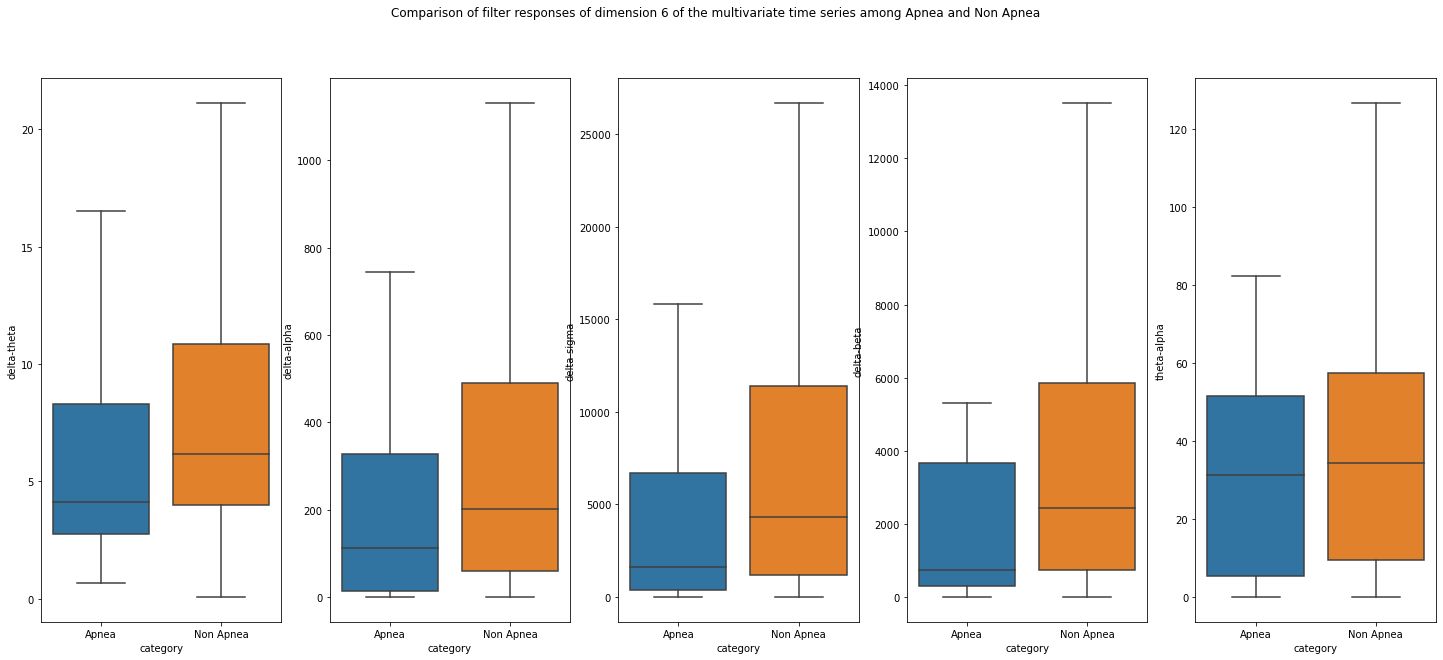

- - - - - - - - - - - - - - - PATIENT 17- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


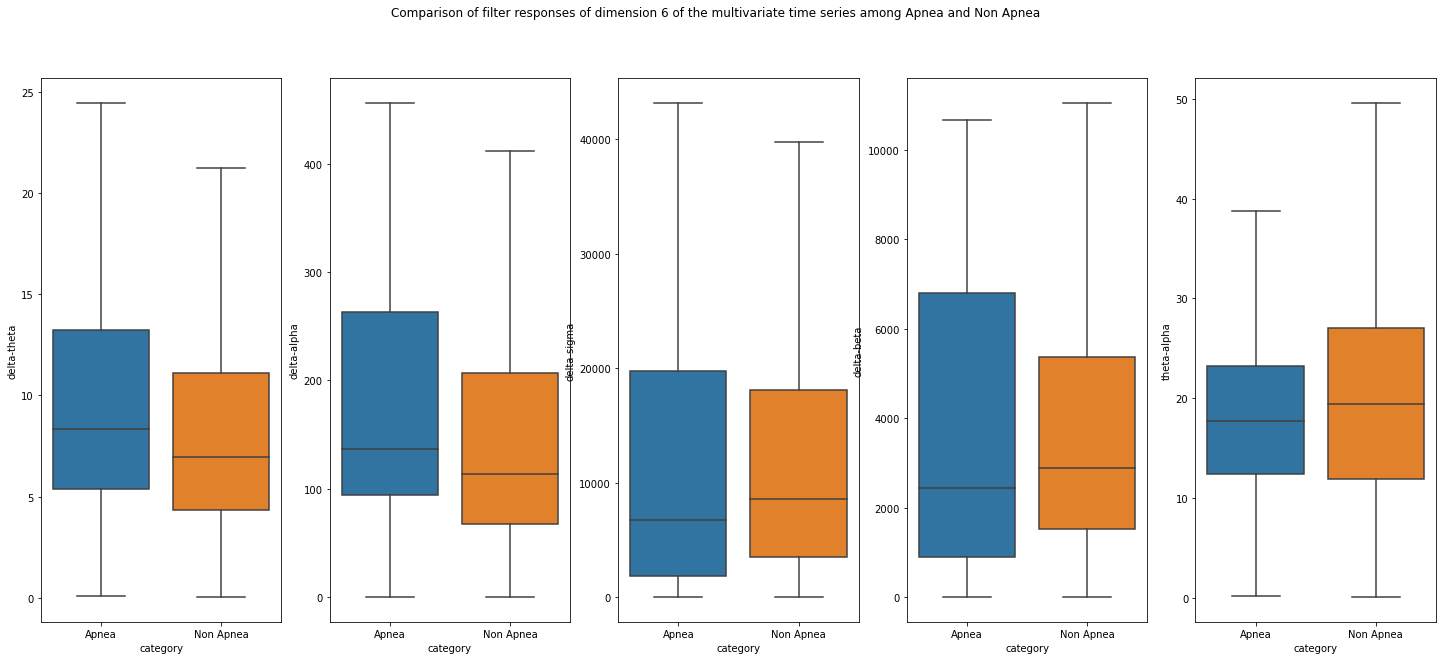

- - - - - - - - - - - - - - - PATIENT 18- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


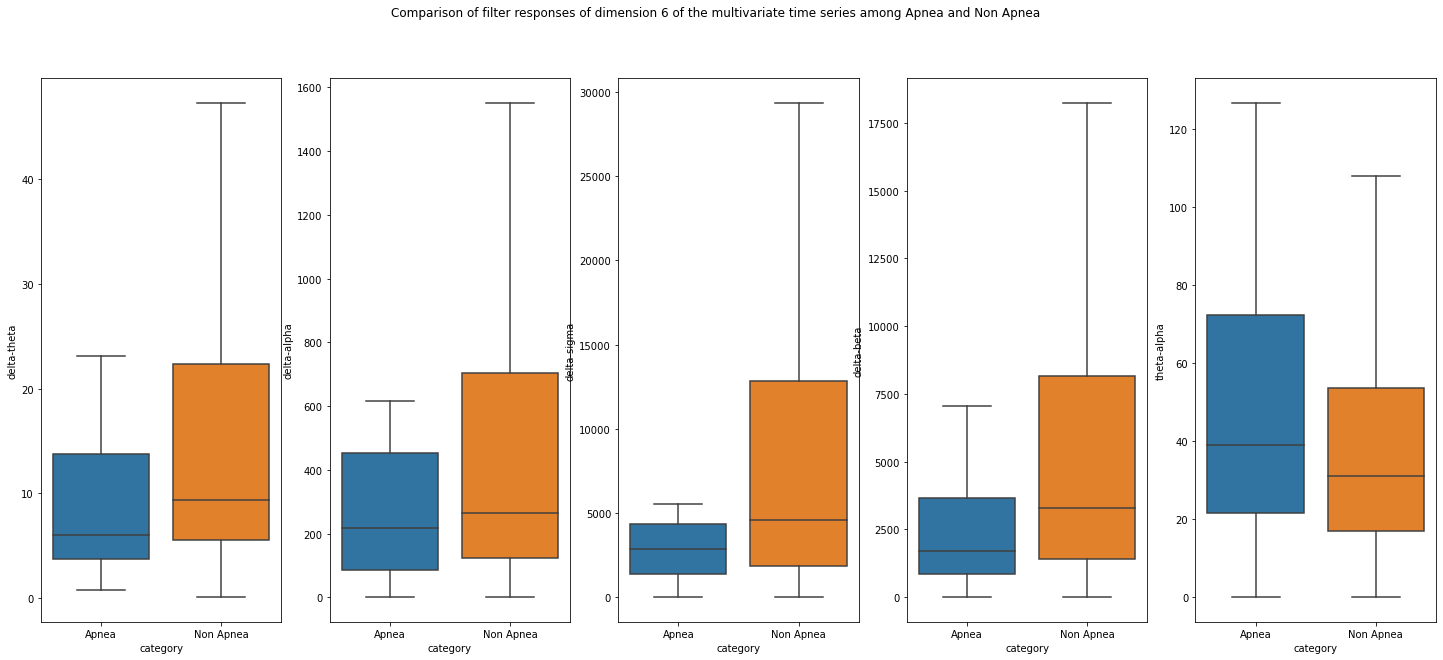

- - - - - - - - - - - - - - - PATIENT 19- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


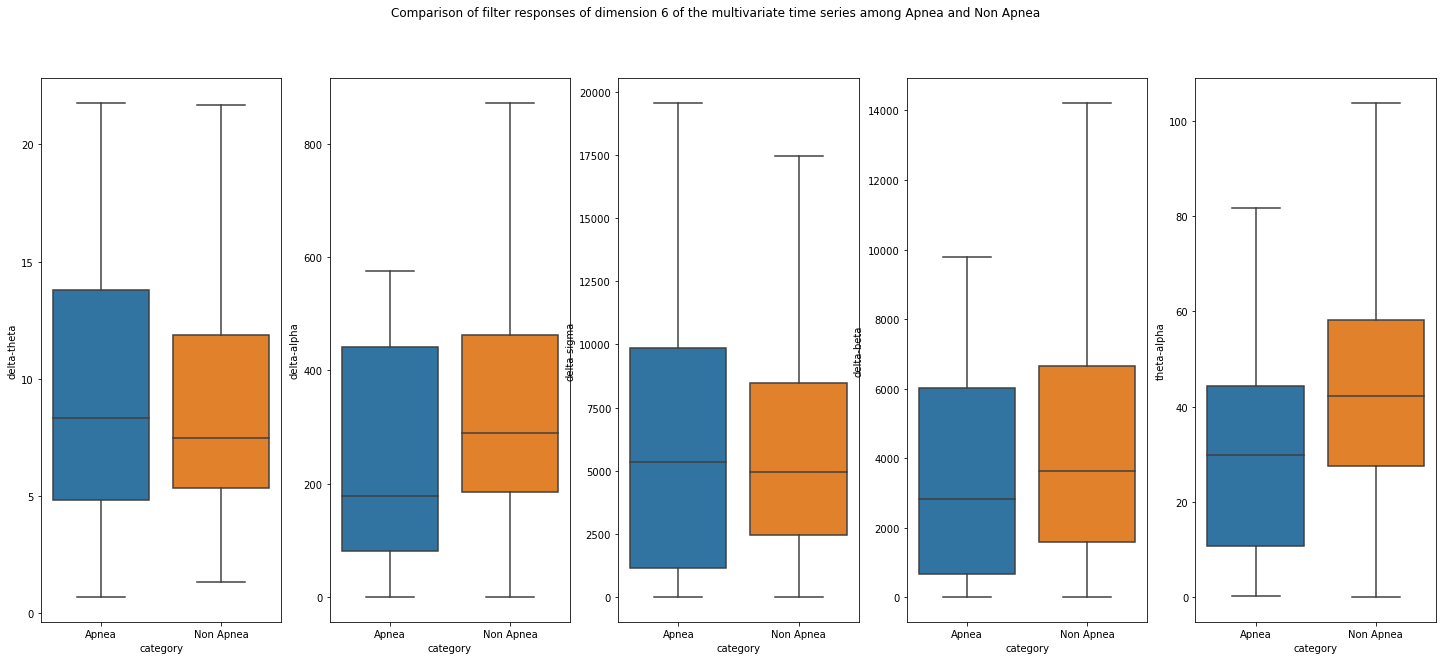

- - - - - - - - - - - - - - - PATIENT 20- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


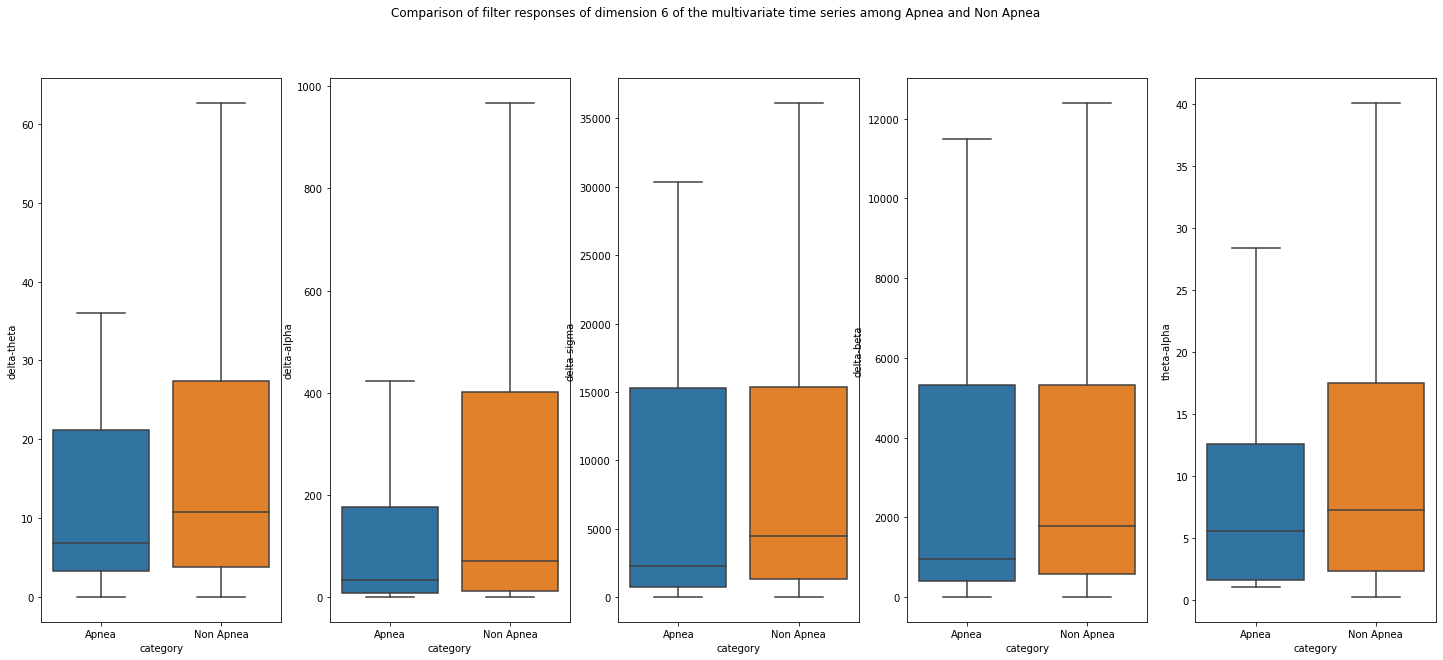

- - - - - - - - - - - - - - - PATIENT 21- - - - - - - - - - - - - - - 


<ipython-input-70-fabf44c8489c>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-70-fabf44c8489c>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


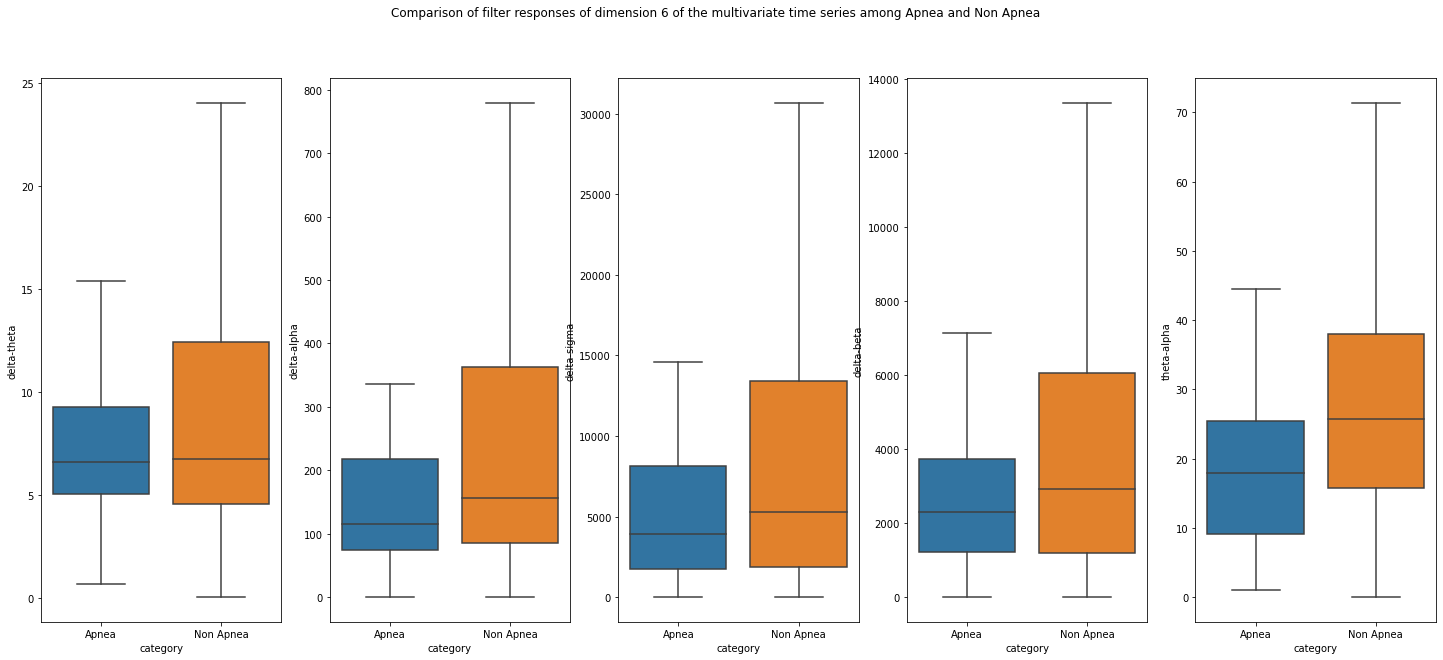

In [75]:
## same but without outliers in the plots

for i in range(22):
    print(15*"- " + 'PATIENT '+str(i) + 15*"- " )
    features_boxplots(X_EEG2[i*200:(i+1)*200,:], 6, outliers_boolean=False)

## See what's going on when reducing the window size to 1 second

<ipython-input-79-13babccf269f>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-79-13babccf269f>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


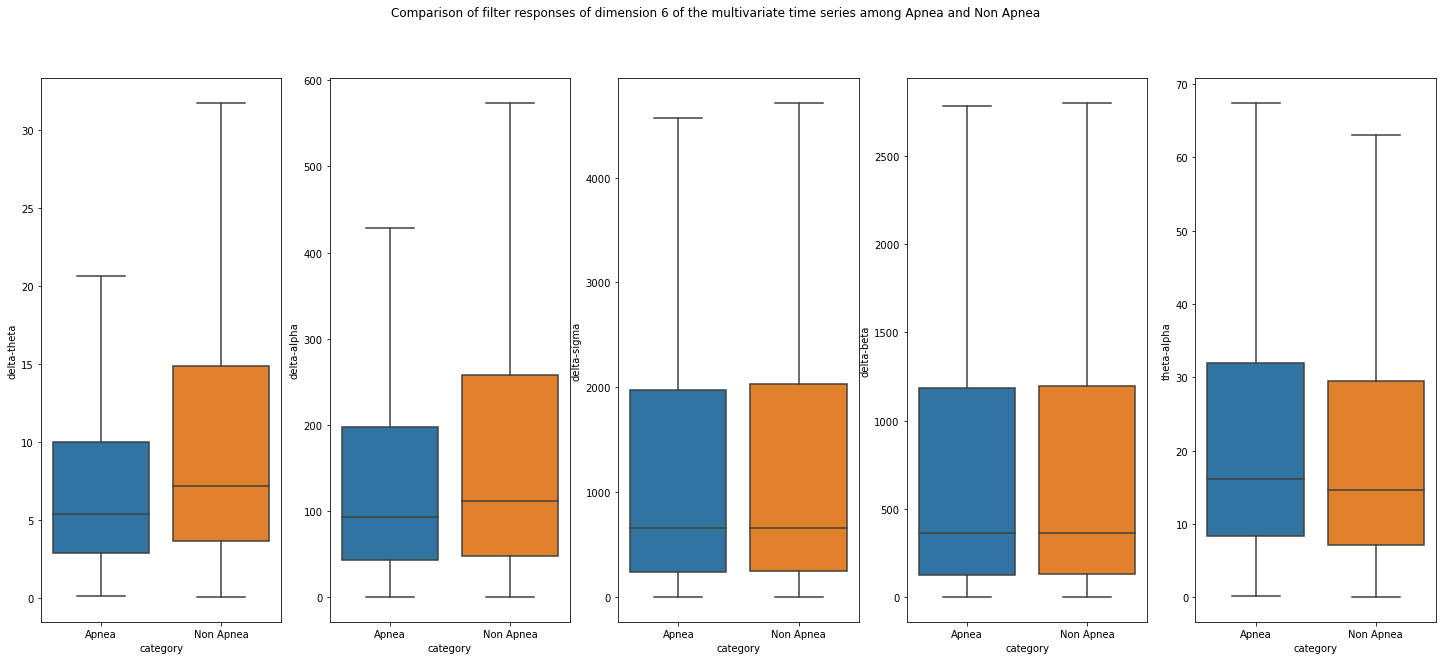

In [80]:
WINDOW_SIZE = 1 * FREQUENCY ## 1 SECONDS

## EEG1

features_boxplots(X_EEG1, 6, outliers_boolean=False)


<ipython-input-79-13babccf269f>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-79-13babccf269f>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


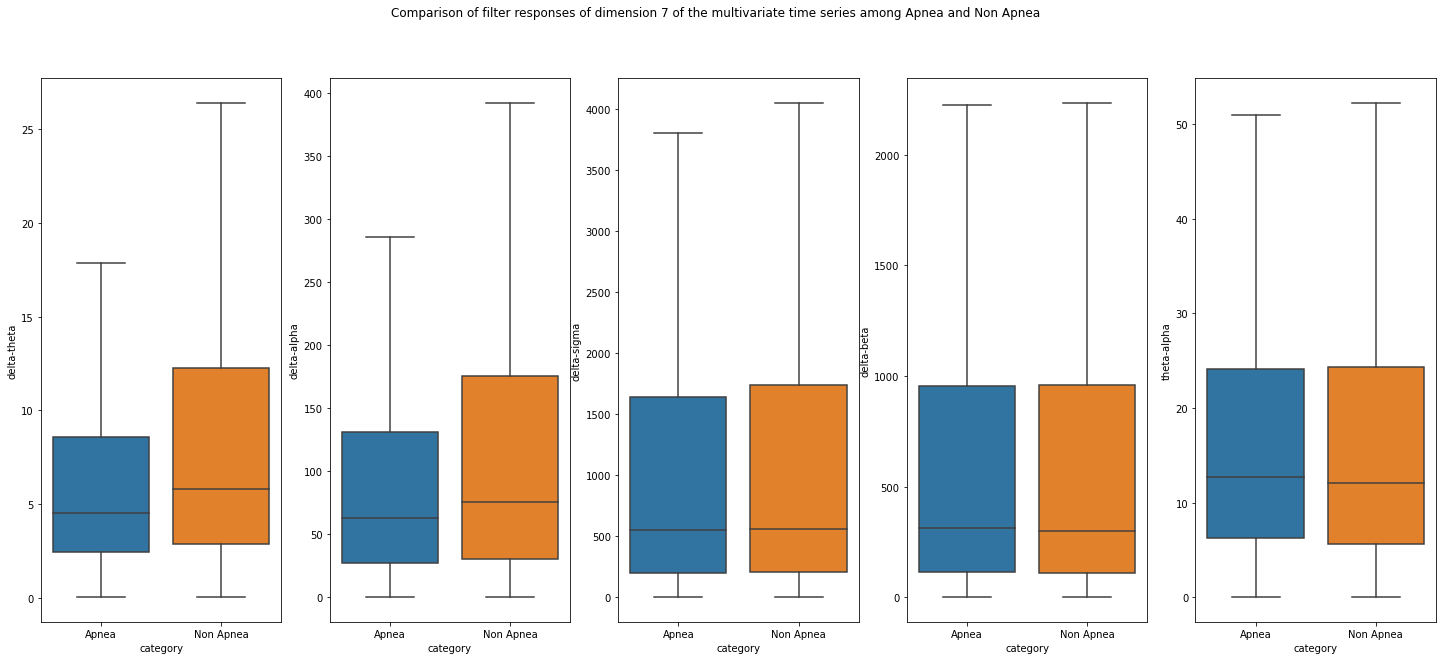

In [81]:
## EEG2

features_boxplots(X_EEG2, 7, outliers_boolean=False)

## See what's going on when reducing the window size to 5 seconds

<ipython-input-79-13babccf269f>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-79-13babccf269f>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


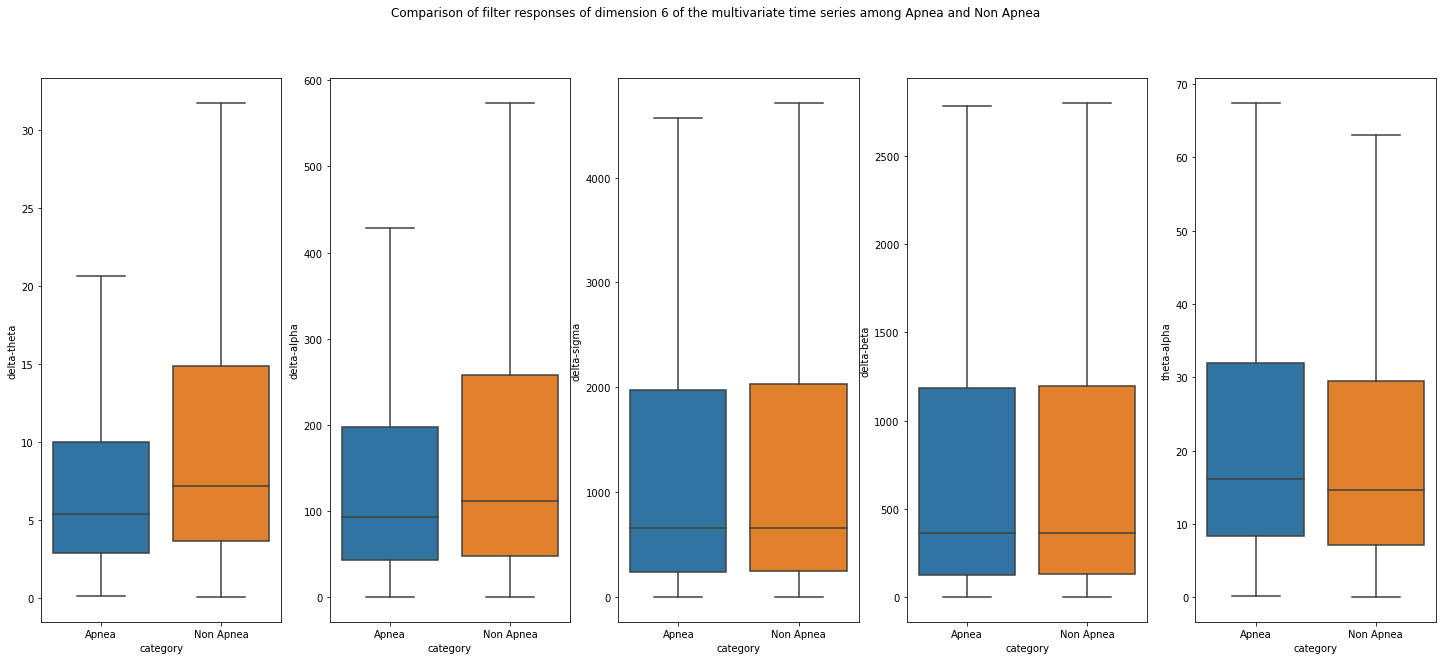

In [82]:
WINDOW_SIZE = 5 * FREQUENCY ## 5 SECONDS

## EEG1
features_boxplots(X_EEG1, 6, outliers_boolean=False)

<ipython-input-79-13babccf269f>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-79-13babccf269f>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


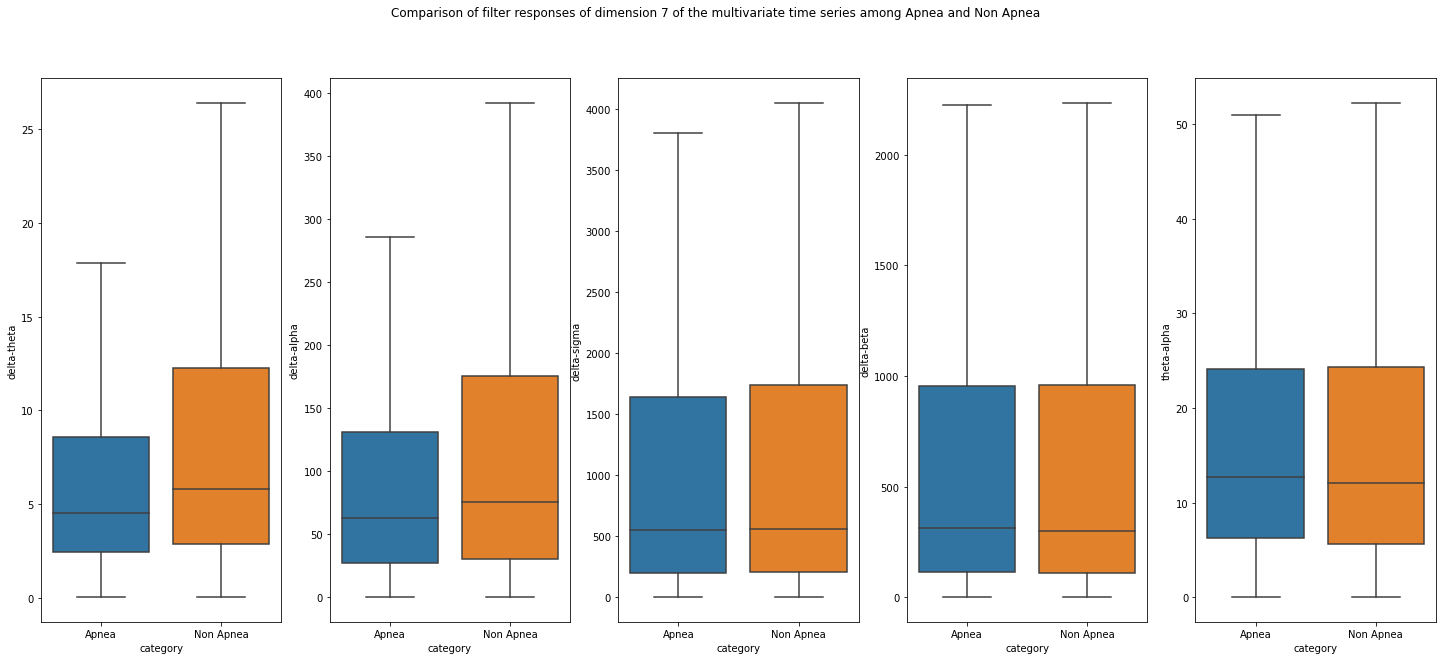

In [83]:
## EEG2

features_boxplots(X_EEG2, 7, outliers_boolean=False)

## See what's going on when reducing the window size to 15 seconds

<ipython-input-79-13babccf269f>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-79-13babccf269f>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


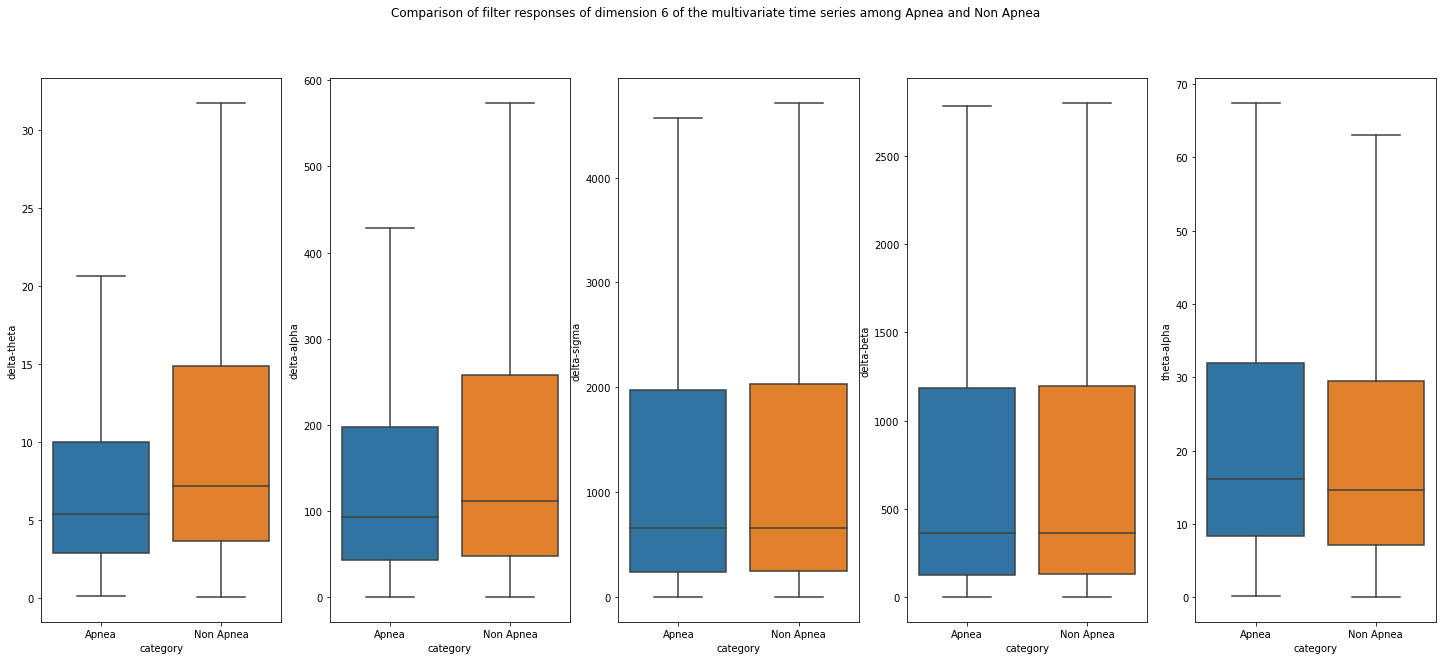

In [84]:
WINDOW_SIZE = 15 * FREQUENCY ## 15 SECONDS

## EEG1
features_boxplots(X_EEG1, 6, outliers_boolean=False)

<ipython-input-79-13babccf269f>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  apneas=np.array(apneas)
<ipython-input-79-13babccf269f>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nonapneas=np.array(nonapneas)


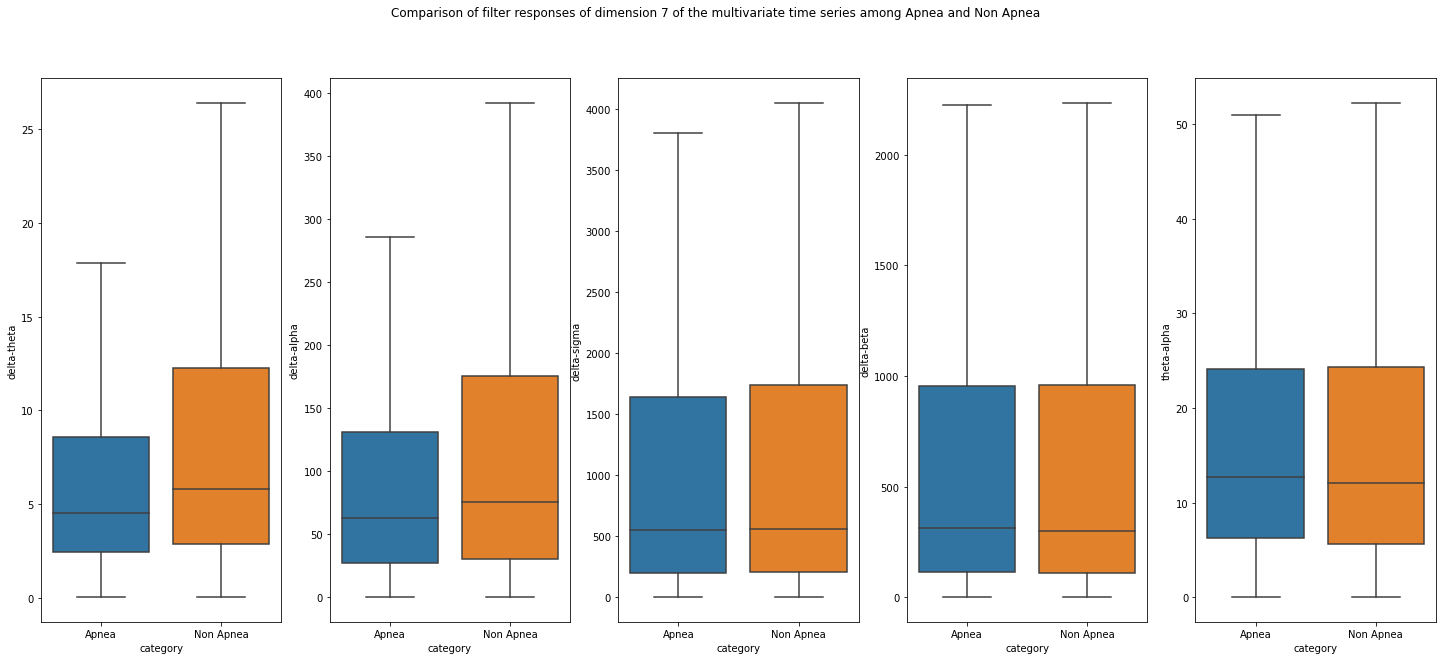

In [85]:
## EEG2

features_boxplots(X_EEG2, 7, outliers_boolean=False)